<a href="https://colab.research.google.com/github/keeprich/AI-Trading-Bot/blob/main/Cybernetics_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

[*********************100%***********************]  1 of 1 completed


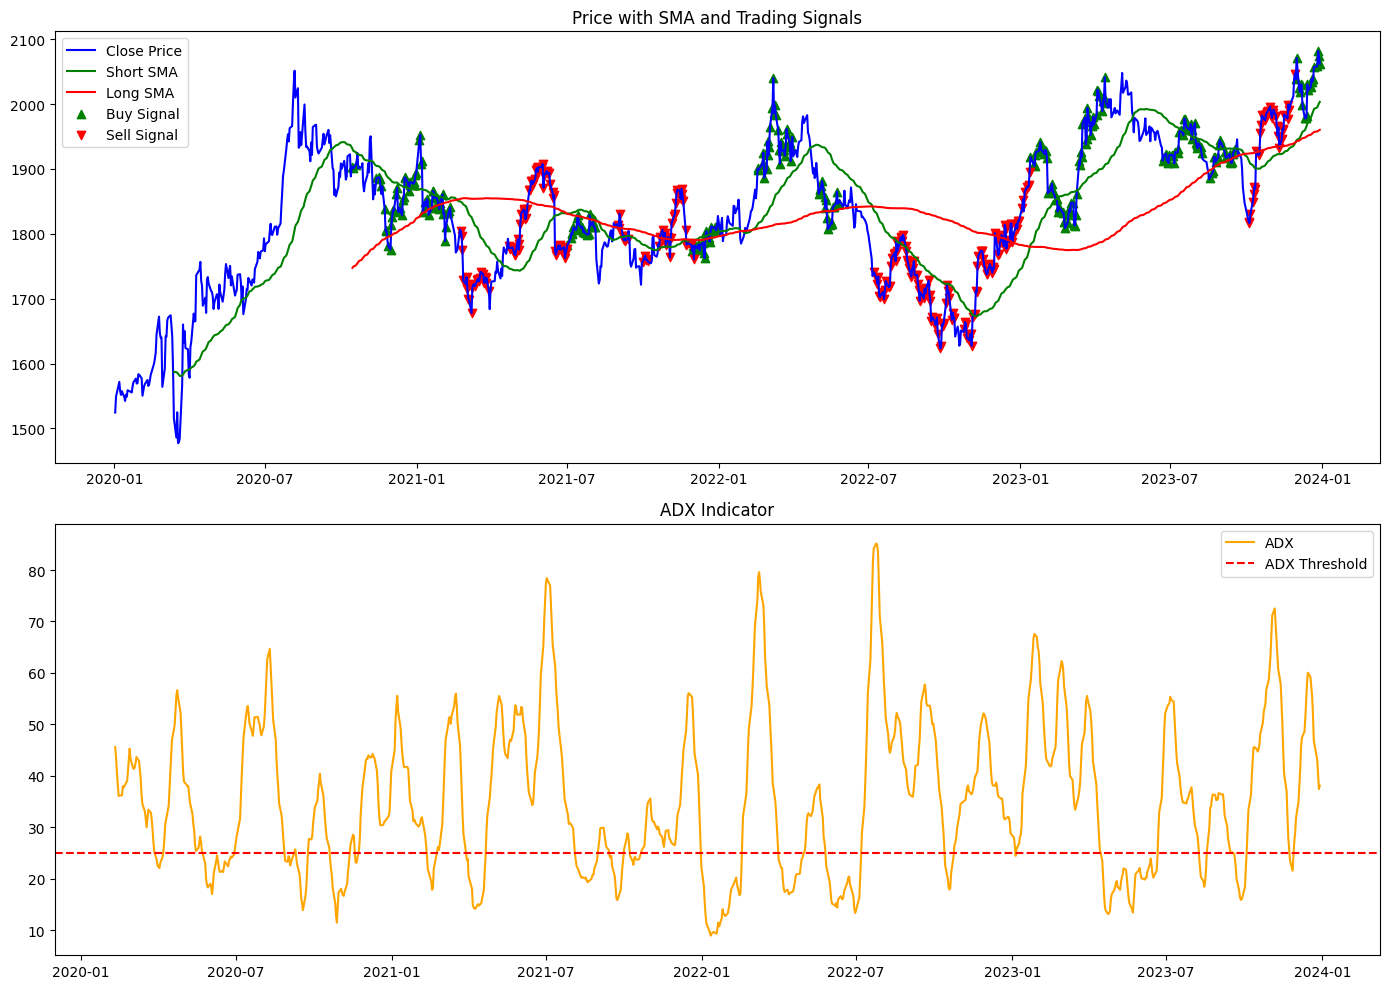

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Calculate ADX and SMA
def calculate_adx(data, period=14):
    """Calculates ADX, +DI, and -DI."""
    data['High-Low'] = data['High'] - data['Low']
    data['High-PrevClose'] = abs(data['High'] - data['Close'].shift(1))
    data['Low-PrevClose'] = abs(data['Low'] - data['Close'].shift(1))

    # True Range
    data['TR'] = data[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
    data['ATR'] = data['TR'].rolling(window=period).mean()

    # Directional Movement
    data['+DM'] = data['High'].diff()
    data['-DM'] = -data['Low'].diff()
    data['+DM'] = data['+DM'].where((data['+DM'] > data['-DM']) & (data['+DM'] > 0), 0)
    data['-DM'] = data['-DM'].where((data['-DM'] > data['+DM']) & (data['-DM'] > 0), 0)

    # Smooth +DM and -DM
    data['+DI'] = 100 * (data['+DM'].rolling(window=period).mean() / data['ATR'])
    data['-DI'] = 100 * (data['-DM'].rolling(window=period).mean() / data['ATR'])

    # ADX Calculation
    data['DX'] = 100 * abs(data['+DI'] - data['-DI']) / (data['+DI'] + data['-DI'])
    data['ADX'] = data['DX'].rolling(window=period).mean()

    return data


def calculate_sma(data, short_window=50, long_window=200):
    """Calculates Short and Long SMAs."""
    data['SMA_Short'] = data['Close'].rolling(window=short_window).mean()
    data['SMA_Long'] = data['Close'].rolling(window=long_window).mean()
    return data


# Trading Strategy
def adx_sma_strategy(data, adx_threshold=25):
    """Combines ADX and SMA for buy/sell signals."""
    data['Signal'] = 0  # No position by default

    # Buy signal: SMA Short > SMA Long and ADX > threshold
    data.loc[(data['SMA_Short'] > data['SMA_Long']) & (data['ADX'] > adx_threshold), 'Signal'] = 1

    # Sell signal: SMA Short < SMA Long and ADX > threshold
    data.loc[(data['SMA_Short'] < data['SMA_Long']) & (data['ADX'] > adx_threshold), 'Signal'] = -1

    return data


# Visualization
def plot_trading_strategy(data):
    """Plots ADX, SMA, and buy/sell signals."""
    plt.figure(figsize=(14, 10))

    # Price and SMA
    plt.subplot(2, 1, 1)
    plt.plot(data['Close'], label='Close Price', color='blue')
    plt.plot(data['SMA_Short'], label='Short SMA', color='green')
    plt.plot(data['SMA_Long'], label='Long SMA', color='red')
    plt.scatter(data.index[data['Signal'] == 1], data['Close'][data['Signal'] == 1], label='Buy Signal', marker='^', color='green', alpha=1)
    plt.scatter(data.index[data['Signal'] == -1], data['Close'][data['Signal'] == -1], label='Sell Signal', marker='v', color='red', alpha=1)
    plt.title('Price with SMA and Trading Signals')
    plt.legend()

    # ADX
    plt.subplot(2, 1, 2)
    plt.plot(data['ADX'], label='ADX', color='orange')
    plt.axhline(25, color='red', linestyle='--', label='ADX Threshold')
    plt.title('ADX Indicator')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Main Function
def main():
    # Fetch data
    ticker = "GC=F"  # Gold to USD
    start_date = "2020-01-01"
    end_date = "2024-01-01"
    data = yf.download(ticker, start=start_date, end=end_date)

    # Calculate indicators
    data = calculate_adx(data)
    data = calculate_sma(data)
    data = adx_sma_strategy(data)

    # Plot results
    plot_trading_strategy(data)


if __name__ == "__main__":
    main()


# Back testing

In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the ticker symbols and date range
start_date = "2020-04-21"
end_date = "2024-01-01"
spy = yf.download("SPY", start=start_date, end=end_date)
tlt = yf.download("TLT", start=start_date, end=end_date)

# Clean the data by flattening the MultiIndex columns
spy.columns = spy.columns.droplevel(1)  # Drop the second level, leaving only one level for column names
tlt.columns = tlt.columns.droplevel(1)  # Drop the second level, leaving only one level for column names

# Calculate moving averages for SPY and TLT *before* aligning
spy['SMA_12'] = spy['Close'].rolling(window=12).mean()
tlt['SMA_26'] = tlt['Close'].rolling(window=26).mean()

# Align the two DataFrames based on their indexes (dates)
spy, tlt = spy.align(tlt, join='inner')

# Create trading signal based on the strategy:
# 1: Buy (when SPY < SMA_12 and TLT > SMA_26)
# -1: Sell (when SPY > SMA_12 and TLT < SMA_26)
spy['Signal'] = np.where((spy['Close'] < spy['SMA_12']) & (tlt['Close'] > tlt['SMA_26']), 1, 0)
spy['Signal'] = np.where((spy['Close'] > spy['SMA_12']) & (tlt['Close'] < tlt['SMA_26']), -1, spy['Signal'])

# Shift the signals to simulate buy/sell at the next open
spy['Signal'] = spy['Signal'].shift(1)

# Visualizing the data and signals
plt.figure(figsize=(12,6))

# Plot SPY and its 12-period moving average
plt.subplot(2, 1, 1)
plt.plot(spy['Close'], label='SPY Close Price', color='blue')
plt.plot(spy['SMA_12'], label='12-period SMA', color='orange')
plt.title('SPY Price and 12-period Moving Average')
plt.legend()

# Plot the trading signals
plt.subplot(2, 1, 2)
plt.plot(spy['Signal'], label='Trading Signal', color='green')
plt.title('Trading Signal: Buy (1) and Sell (-1)')
plt.legend()

plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


KeyError: 'SMA_12'

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


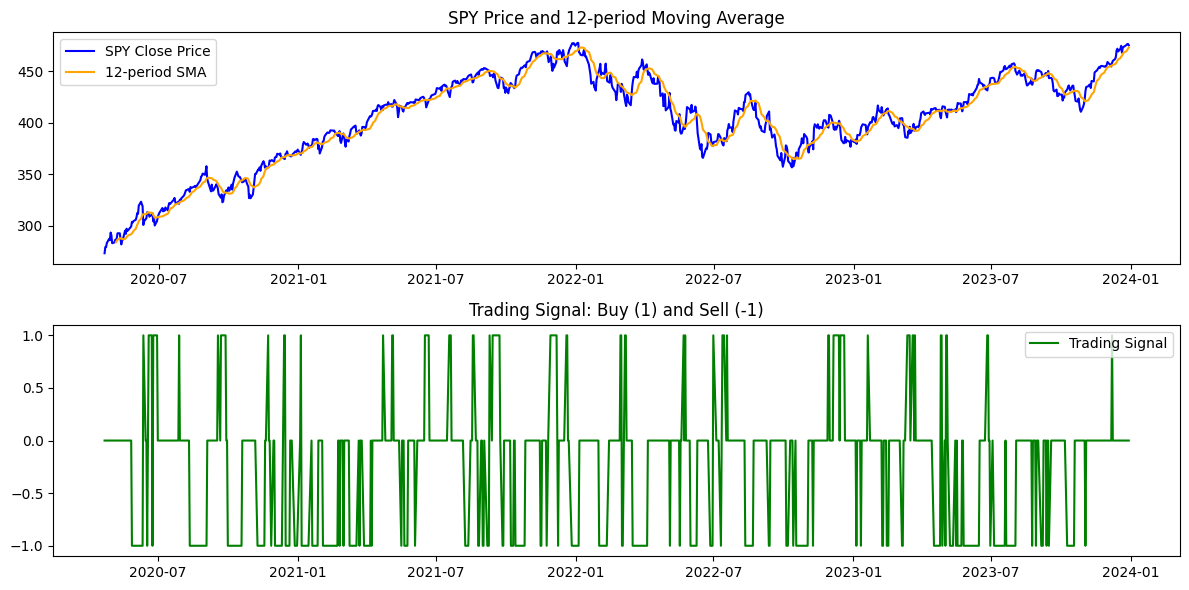

In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the ticker symbols and date range
start_date = "2020-04-21"
end_date = "2024-01-01"
spy = yf.download("SPY", start=start_date, end=end_date)
tlt = yf.download("TLT", start=start_date, end=end_date)

# Clean the data by flattening the MultiIndex columns
spy.columns = spy.columns.droplevel(1)  # Drop the second level, leaving only one level for column names
tlt.columns = tlt.columns.droplevel(1)  # Drop the second level, leaving only one level for column names

# Align the two DataFrames based on their indexes (dates) *before* calculating SMAs
spy, tlt = spy.align(tlt, join='inner')

# Calculate moving averages for SPY and TLT *after* aligning
spy['SMA_12'] = spy['Close'].rolling(window=12).mean()
tlt['SMA_26'] = tlt['Close'].rolling(window=26).mean()

# Create trading signal based on the strategy:
# 1: Buy (when SPY < SMA_12 and TLT > SMA_26)
# -1: Sell (when SPY > SMA_12 and TLT < SMA_26)
spy['Signal'] = np.where((spy['Close'] < spy['SMA_12']) & (tlt['Close'] > tlt['SMA_26']), 1, 0)
spy['Signal'] = np.where((spy['Close'] > spy['SMA_12']) & (tlt['Close'] < tlt['SMA_26']), -1, spy['Signal'])

# Shift the signals to simulate buy/sell at the next open
spy['Signal'] = spy['Signal'].shift(1)

# Visualizing the data and signals
plt.figure(figsize=(12,6))

# Plot SPY and its 12-period moving average
plt.subplot(2, 1, 1)
plt.plot(spy['Close'], label='SPY Close Price', color='blue')
plt.plot(spy['SMA_12'], label='12-period SMA', color='orange')
plt.title('SPY Price and 12-period Moving Average')
plt.legend()

# Plot the trading signals
plt.subplot(2, 1, 2)
plt.plot(spy['Signal'], label='Trading Signal', color='green')
plt.title('Trading Signal: Buy (1) and Sell (-1)')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
import yfinance as yf
import pandas as pd
import numpy as np

# Download market and intermarket data
start_date = '2020-04-21'
end_date = '2024-01-01'
spy = yf.download('SPY', start=start_date, end=end_date)
tlt = yf.download('TLT', start=start_date, end=end_date)

# Clean data by flattening MultiIndex columns
spy.columns = spy.columns.droplevel(1)  # Flatten the MultiIndex columns for SPY
tlt.columns = tlt.columns.droplevel(1)  # Flatten the MultiIndex columns for TLT

# Align data to the same index (dates)
spy, tlt = spy.align(tlt, join='inner')

# Check for missing values and remove them if necessary
spy = spy.dropna()
tlt = tlt.dropna()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [19]:
spy.head()

Price        Adj Close       Close        High         Low        Open  \
Date                                                                     
2020-04-21  255.487610  273.040009  278.040009  272.019989  276.730011   
2020-04-22  261.157959  279.100006  281.000000  276.910004  278.350006   
2020-04-23  261.139282  279.079987  283.940002  278.750000  280.489990   
2020-04-24  264.779205  282.970001  283.700012  278.500000  280.730011   
2020-04-27  268.596985  287.049988  288.269989  284.619995  285.119995   

Price          Volume  
Date                   
2020-04-21  126385700  
2020-04-22   92951600  
2020-04-23  104709700  
2020-04-24   85063200  
2020-04-27   77896600

In [20]:
tlt.head()

Price        Adj Close       Close        High         Low        Open  \
Date                                                                     
2020-04-21  152.031876  171.289993  172.149994  170.779999  171.929993   
2020-04-22  150.478653  169.539993  170.389999  168.710007  169.970001   
2020-04-23  151.277405  170.440002  170.929993  169.610001  169.869995   
2020-04-24  151.632477  170.839996  170.839996  169.570007  169.610001   
2020-04-27  148.810013  167.660004  169.750000  167.440002  169.660004   

Price        Volume  
Date                 
2020-04-21  7850700  
2020-04-22  6230200  
2020-04-23  5968600  
2020-04-24  6211800  
2020-04-27  9039500

In [21]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=444b47725f0da05b9d9f13fb44db6c882f4baafc9bced2926c6f8b767417ede2
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [22]:
import pandas as pd
import pandas_ta as ta


In [24]:
spy[['ADX_10', 'DMP_10', 'DMN_10']] = ta.adx(spy['High'], spy['Low'], spy['Close'], length=10)


In [25]:
spy['SMA_12'] = ta.sma(spy['Close'], length=12)
spy['SMA_26'] = ta.sma(spy['Close'], length=26)


In [26]:
spy['RSI_14'] = ta.rsi(spy['Close'], length=14)


In [27]:
stoch = ta.stoch(spy['High'], spy['Low'], spy['Close'], k=14, d=3)
spy['SlowK'], spy['SlowD'] = stoch['STOCHk_14_3_3'], stoch['STOCHd_14_3_3']


In [28]:
spy['Pct_Change'] = spy['Close'].pct_change(periods=5) * 100


In [29]:
# Assuming 'tlt' DataFrame contains TLT market data
spy['Short_Corr'] = spy['Close'].rolling(15).corr(tlt['Close'])  # 15-period correlation
spy['Long_Corr'] = spy['Close'].rolling(40).corr(tlt['Close'])  # 40-period correlation


In [30]:
print(spy.head())

Price        Adj Close       Close        High         Low        Open  \
Date                                                                     
2020-04-21  255.487610  273.040009  278.040009  272.019989  276.730011   
2020-04-22  261.157959  279.100006  281.000000  276.910004  278.350006   
2020-04-23  261.139282  279.079987  283.940002  278.750000  280.489990   
2020-04-24  264.779205  282.970001  283.700012  278.500000  280.730011   
2020-04-27  268.596985  287.049988  288.269989  284.619995  285.119995   

Price          Volume  ADX_10  DMP_10  DMN_10  SMA_12  SMA_26  RSI_14  SlowK  \
Date                                                                           
2020-04-21  126385700     NaN     NaN     NaN     NaN     NaN     NaN    NaN   
2020-04-22   92951600     NaN     NaN     NaN     NaN     NaN     NaN    NaN   
2020-04-23  104709700     NaN     NaN     NaN     NaN     NaN     NaN    NaN   
2020-04-24   85063200     NaN     NaN     NaN     NaN     NaN     NaN    NaN   
2

In [31]:
print(spy.tail())  # Show the last few rows


Price        Adj Close       Close        High         Low        Open  \
Date                                                                     
2023-12-22  469.225250  473.649994  475.380005  471.700012  473.859985   
2023-12-26  471.206573  475.649994  476.579987  473.989990  474.070007   
2023-12-27  472.058563  476.510010  476.660004  474.890015  475.440002   
2023-12-28  472.236877  476.690002  477.549988  476.260010  476.880005   
2023-12-29  470.869751  475.309998  477.029999  473.299988  476.489990   

Price          Volume     ADX_10     DMP_10     DMN_10      SMA_12  \
Date                                                                 
2023-12-22   67126600  57.884936  36.065988  13.329419  468.148336   
2023-12-26   55387000  57.017323  36.409164  12.393805  469.600001   
2023-12-27   68000300  56.258542  34.974383  11.836161  470.959167   
2023-12-28   77158100  55.833365  36.170259  11.420068  472.184168   
2023-12-29  122234100  53.041602  32.499606  18.314478  473.1

In [32]:
spy.to_csv("processed_SPY_data.csv")


In [33]:
# load data
spy = pd.read_csv("processed_SPY_data.csv")

In [34]:
# remove nan values
spy = spy.dropna()

In [35]:
spy.head()

Date   Adj Close       Close        High         Low        Open  \
39  2020-06-16  292.841339  312.959991  315.640015  307.670013  315.480011   
40  2020-06-17  291.624939  311.660004  314.390015  310.859985  314.070007   
41  2020-06-18  291.737244  311.779999  312.299988  309.510010  310.010010   
42  2020-06-19  290.069916  308.640015  314.380005  306.529999  314.170013   
43  2020-06-22  291.930756  310.619995  311.049988  306.750000  307.989990   

       Volume     ADX_10     DMP_10     DMN_10      SMA_12      SMA_26  \
39  137627500  28.076497  27.667531  27.604750  312.027494  302.325767   
40   83398900  25.169290  26.287109  26.227461  312.536662  303.062690   
41   80828700  22.953398  25.183690  27.157606  312.844996  304.028459   
42  135549600  21.836955  22.262270  28.410951  312.549998  305.068459   
43   74649400  20.838899  20.794122  26.537311  312.488332  306.054997   

       RSI_14      SlowK      SlowD  Pct_Change  Short_Corr  Long_Corr  
39  59.367740  43.593634  40.711036   -2.440854   -0.855741  -0.900663  
40  57.934502  51.806013  42.293413   -2.300939   -0.845223  -0.893782  
41  58.035210  57.717785  51.039144    3.715783   -0.820196  -0.883554  
42  54.367272  52.318492  53.947430    1.456239   -0.803537  -0.874384  
43  56.245180  51.018644  53.684974    1.162680   -0.785250  -0.870489

In [36]:
pip install scikit-learn


In [37]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd


In [38]:
# Select only the columns you want to use in PCA (exclude non-numeric columns like dates)
features = ['ADX_10', 'DMP_10', 'DMN_10', 'SMA_12', 'SMA_26', 'RSI_14', 'SlowK', 'SlowD', 'Pct_Change', 'Short_Corr', 'Long_Corr']
data_for_pca = spy[features].dropna()  # Drop rows with NaN values




In [39]:
features

['ADX_10',
 'DMP_10',
 'DMN_10',
 'SMA_12',
 'SMA_26',
 'RSI_14',
 'SlowK',
 'SlowD',
 'Pct_Change',
 'Short_Corr',
 'Long_Corr']

In [40]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_pca)

In [41]:
# Initialize PCA, keeping enough components to explain 95% of the variance
pca = PCA(n_components=0.95)  # Retain 95% of variance
pca_data = pca.fit_transform(scaled_data)

# Create a DataFrame with the principal components
pca_columns = [f'PC{i+1}' for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_data, columns=pca_columns, index=data_for_pca.index)


In [42]:
print(pca_df.head())

         PC1       PC2       PC3       PC4       PC5       PC6       PC7
39 -0.246492 -4.209885  0.379766  1.756627 -0.118325 -0.532322 -0.634954
40 -0.161616 -4.251427  0.213031  1.449771 -0.101615 -0.558104 -0.561667
41  0.784162 -4.270366  0.151777  0.508488 -0.085173  1.429242  0.232278
42  0.079694 -4.336627  0.027954  0.600284 -0.137323  0.642548  0.242305
43  0.100018 -4.321608  0.006095  0.574677 -0.116846  0.539251  0.099931


In [43]:
# Print the explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

# Cumulative explained variance
cumulative_variance = explained_variance.cumsum()
print("Cumulative Variance Explained:", cumulative_variance)


Explained Variance Ratio: [0.44239829 0.21494155 0.10544805 0.08395266 0.05574701 0.04487067
 0.02528946]
Cumulative Variance Explained: [0.44239829 0.65733984 0.76278788 0.84674054 0.90248756 0.94735823
 0.97264769]


In [44]:
# Merge PCA components back into the main DataFrame
spy_with_pca = spy.join(pca_df)

# Check the updated DataFrame
print(spy_with_pca.tail())


           Date   Adj Close       Close        High         Low        Open  \
926  2023-12-22  469.225250  473.649994  475.380005  471.700012  473.859985   
927  2023-12-26  471.206573  475.649994  476.579987  473.989990  474.070007   
928  2023-12-27  472.058563  476.510010  476.660004  474.890015  475.440002   
929  2023-12-28  472.236877  476.690002  477.549988  476.260010  476.880005   
930  2023-12-29  470.869751  475.309998  477.029999  473.299988  476.489990   

        Volume     ADX_10     DMP_10     DMN_10  ...  Pct_Change  Short_Corr  \
926   67126600  57.884936  36.065988  13.329419  ...    0.920463    0.839599   
927   55387000  57.017323  36.409164  12.393805  ...    0.779709    0.825215   
928   68000300  56.258542  34.974383  11.836161  ...    0.351700    0.823210   
929   77158100  55.833365  36.170259  11.420068  ...    1.800280    0.869982   
930  122234100  53.041602  32.499606  18.314478  ...    0.552144    0.866594   

     Long_Corr       PC1       PC2       PC3

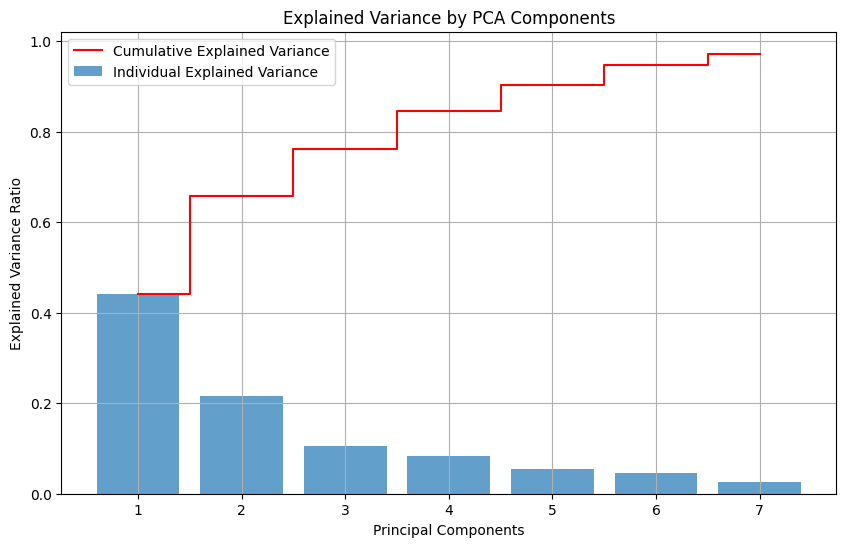

In [45]:
# Plot explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='Individual Explained Variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative Explained Variance', color='red')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by PCA Components')
plt.legend(loc='best')
plt.grid()
plt.show()


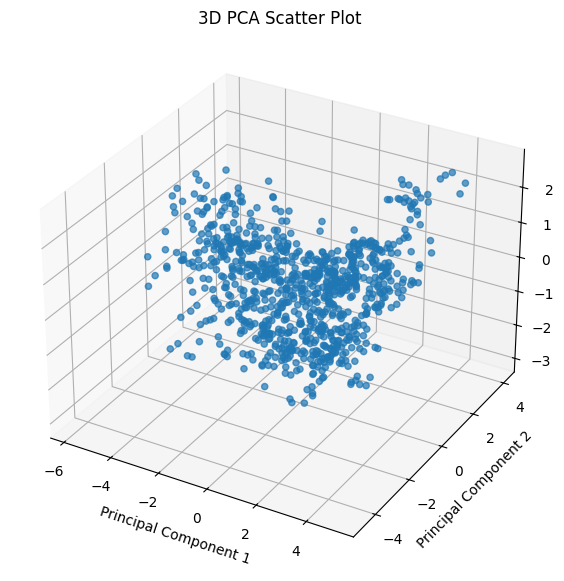

In [47]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], alpha=0.7)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('3D PCA Scatter Plot')
plt.show()


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns


In [51]:
# import data
spy = pd.read_csv("processed_SPY_data.csv")

In [52]:
spy.head()

Date   Adj Close       Close        High         Low        Open  \
0  2020-04-21  255.487610  273.040009  278.040009  272.019989  276.730011   
1  2020-04-22  261.157959  279.100006  281.000000  276.910004  278.350006   
2  2020-04-23  261.139282  279.079987  283.940002  278.750000  280.489990   
3  2020-04-24  264.779205  282.970001  283.700012  278.500000  280.730011   
4  2020-04-27  268.596985  287.049988  288.269989  284.619995  285.119995   

      Volume  ADX_10  DMP_10  DMN_10  SMA_12  SMA_26  RSI_14  SlowK  SlowD  \
0  126385700     NaN     NaN     NaN     NaN     NaN     NaN    NaN    NaN   
1   92951600     NaN     NaN     NaN     NaN     NaN     NaN    NaN    NaN   
2  104709700     NaN     NaN     NaN     NaN     NaN     NaN    NaN    NaN   
3   85063200     NaN     NaN     NaN     NaN     NaN     NaN    NaN    NaN   
4   77896600     NaN     NaN     NaN     NaN     NaN     NaN    NaN    NaN   

   Pct_Change  Short_Corr  Long_Corr  
0         NaN         NaN        NaN  
1         NaN         NaN        NaN  
2         NaN         NaN        NaN  
3         NaN         NaN        NaN  
4         NaN         NaN        NaN

In [53]:
# remove NAN values
spy = spy.dropna()

In [56]:
spy.head()

Date   Adj Close       Close        High         Low        Open  \
39  2020-06-16  292.841339  312.959991  315.640015  307.670013  315.480011   
40  2020-06-17  291.624939  311.660004  314.390015  310.859985  314.070007   
41  2020-06-18  291.737244  311.779999  312.299988  309.510010  310.010010   
42  2020-06-19  290.069916  308.640015  314.380005  306.529999  314.170013   
43  2020-06-22  291.930756  310.619995  311.049988  306.750000  307.989990   

       Volume     ADX_10     DMP_10     DMN_10      SMA_12      SMA_26  \
39  137627500  28.076497  27.667531  27.604750  312.027494  302.325767   
40   83398900  25.169290  26.287109  26.227461  312.536662  303.062690   
41   80828700  22.953398  25.183690  27.157606  312.844996  304.028459   
42  135549600  21.836955  22.262270  28.410951  312.549998  305.068459   
43   74649400  20.838899  20.794122  26.537311  312.488332  306.054997   

       RSI_14      SlowK      SlowD  Pct_Change  Short_Corr  Long_Corr  
39  59.367740  43.593634  40.711036   -2.440854   -0.855741  -0.900663  
40  57.934502  51.806013  42.293413   -2.300939   -0.845223  -0.893782  
41  58.035210  57.717785  51.039144    3.715783   -0.820196  -0.883554  
42  54.367272  52.318492  53.947430    1.456239   -0.803537  -0.874384  
43  56.245180  51.018644  53.684974    1.162680   -0.785250  -0.870489

In [57]:
# Exclude certain columns (e.g., non-numerical or target variable)
features = spy.columns.difference(['Signal', 'Date'])

# Alternatively, explicitly list columns to exclude
# features = [col for col in spy.columns if col not in ['Signal', 'Date']]


In [58]:
features

Index(['ADX_10', 'Adj Close', 'Close', 'DMN_10', 'DMP_10', 'High', 'Long_Corr',
       'Low', 'Open', 'Pct_Change', 'RSI_14', 'SMA_12', 'SMA_26', 'Short_Corr',
       'SlowD', 'SlowK', 'Volume'],
      dtype='object')

In [59]:
# Select only the features for PCA
X = spy[features]


In [60]:
print(X.head())

       ADX_10   Adj Close       Close     DMN_10     DMP_10        High  \
39  28.076497  292.841339  312.959991  27.604750  27.667531  315.640015   
40  25.169290  291.624939  311.660004  26.227461  26.287109  314.390015   
41  22.953398  291.737244  311.779999  27.157606  25.183690  312.299988   
42  21.836955  290.069916  308.640015  28.410951  22.262270  314.380005   
43  20.838899  291.930756  310.619995  26.537311  20.794122  311.049988   

    Long_Corr         Low        Open  Pct_Change     RSI_14      SMA_12  \
39  -0.900663  307.670013  315.480011   -2.440854  59.367740  312.027494   
40  -0.893782  310.859985  314.070007   -2.300939  57.934502  312.536662   
41  -0.883554  309.510010  310.010010    3.715783  58.035210  312.844996   
42  -0.874384  306.529999  314.170013    1.456239  54.367272  312.549998   
43  -0.870489  306.750000  307.989990    1.162680  56.245180  312.488332   

        SMA_26  Short_Corr      SlowD      SlowK     Volume  
39  302.325767   -0.855741  40

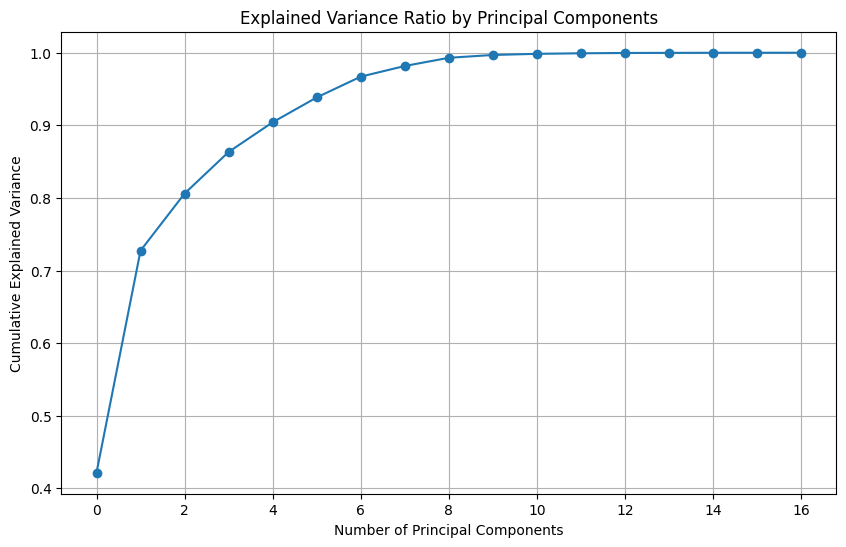

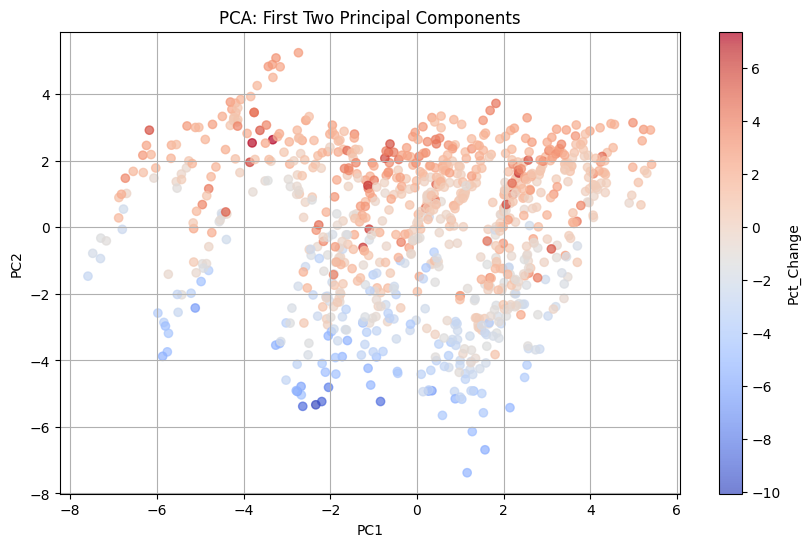

PCA Loading Matrix (First Two Components):
     Adj Close     Close      High       Low      Open    Volume    ADX_10  \
PC1   0.369672  0.370947  0.370127  0.371130  0.370022 -0.021199  0.091000   
PC2  -0.035600 -0.026653 -0.040177 -0.021554 -0.035247 -0.276581  0.032975   

       DMP_10    DMN_10    SMA_12    SMA_26    RSI_14     SlowK     SlowD  \
PC1  0.074656 -0.083413  0.360858  0.350546  0.070380  0.069647  0.070519   
PC2  0.376628 -0.382584 -0.100317 -0.141894  0.413038  0.401005  0.381865   

     Pct_Change  Short_Corr  Long_Corr  
PC1    0.037201    0.082854   0.129252  
PC2    0.320001   -0.110908  -0.082296  


In [61]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assume 'spy' DataFrame is already defined
# Prepare features dynamically by selecting all numerical columns
features = spy.select_dtypes(include=np.number).columns

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(spy[features])

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for PCA results
pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
pca_df = pd.DataFrame(X_pca, columns=pca_columns)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Explained Variance Ratio by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Scatter plot of the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=spy['Pct_Change'], cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Pct_Change')
plt.title('PCA: First Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()
plt.show()

# Print contribution of each feature to the first few PCs
loading_matrix = pd.DataFrame(pca.components_, columns=features, index=pca_columns)
print("PCA Loading Matrix (First Two Components):")
print(loading_matrix.iloc[:2])


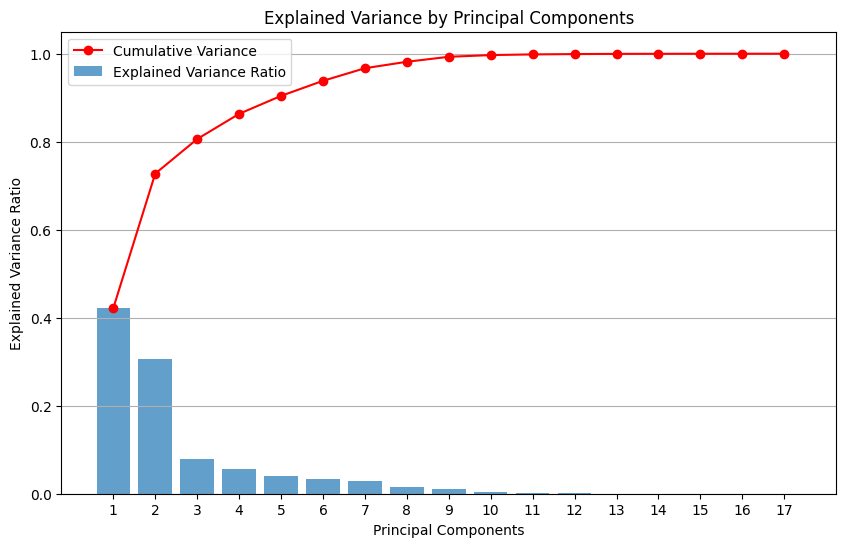

In [62]:
# Plot explained variance ratio as a bar graph
plt.figure(figsize=(10, 6))
components = range(1, len(pca.explained_variance_ratio_) + 1)
plt.bar(components, pca.explained_variance_ratio_, alpha=0.7, label='Explained Variance Ratio')
plt.plot(components, np.cumsum(pca.explained_variance_ratio_), marker='o', color='red', label='Cumulative Variance')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(components)  # Ensures ticks are integers
plt.legend()
plt.grid(axis='y')
plt.show()


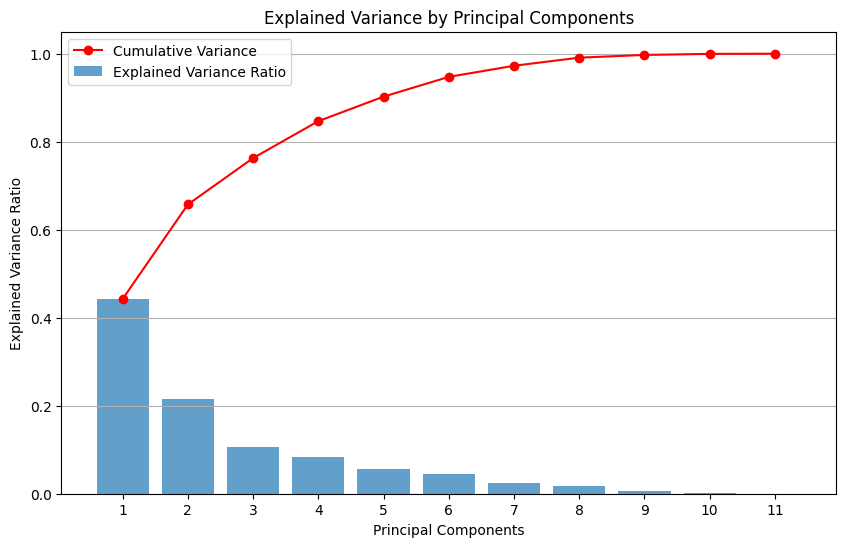

Selected PCA components saved to 'selected_pca_components.csv'.


In [63]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Example data (replace with your actual dataframe)
# Assuming 'spy' DataFrame has columns as per your sample data
features = ['ADX_10', 'DMP_10', 'DMN_10', 'SMA_12', 'SMA_26', 'RSI_14',
            'SlowK', 'SlowD', 'Pct_Change', 'Short_Corr', 'Long_Corr']

# Make sure all necessary columns exist in the dataframe
spy = spy[features]  # This ensures we are working with only the selected features

# Normalize the data using z-score normalization (standardize)
spy_normalized = (spy - spy.mean()) / spy.std()

# Apply PCA
pca = PCA(n_components=len(features))  # Number of components should be the number of features
principal_components = pca.fit_transform(spy_normalized)

# Create a DataFrame for the principal components
pca_df = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(len(features))])

# Calculate the explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Plot explained variance ratio as a bar graph
plt.figure(figsize=(10, 6))
components = range(1, len(explained_variance) + 1)
plt.bar(components, explained_variance, alpha=0.7, label='Explained Variance Ratio')
plt.plot(components, np.cumsum(explained_variance), marker='o', color='red', label='Cumulative Variance')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(components)  # Ensures ticks are integers
plt.legend()
plt.grid(axis='y')
plt.show()

# Now, to save the selected principal components into a new file:
# We will select the components that explain the most variance. Let's say we select the first 2 PCs.
selected_pcs = pca_df.iloc[:, :2]  # Selecting first 2 principal components (you can adjust this)

# Save the selected PCs to a new CSV file
selected_pcs.to_csv('selected_pca_components.csv', index=False)

print("Selected PCA components saved to 'selected_pca_components.csv'.")


In [64]:
# load pca data
pca_df = pd.read_csv("selected_pca_components.csv")

pca_df.head()

PC1       PC2
0 -0.246354 -4.207524
1 -0.161525 -4.249043
2  0.783722 -4.267971
3  0.079649 -4.334195
4  0.099962 -4.319185

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


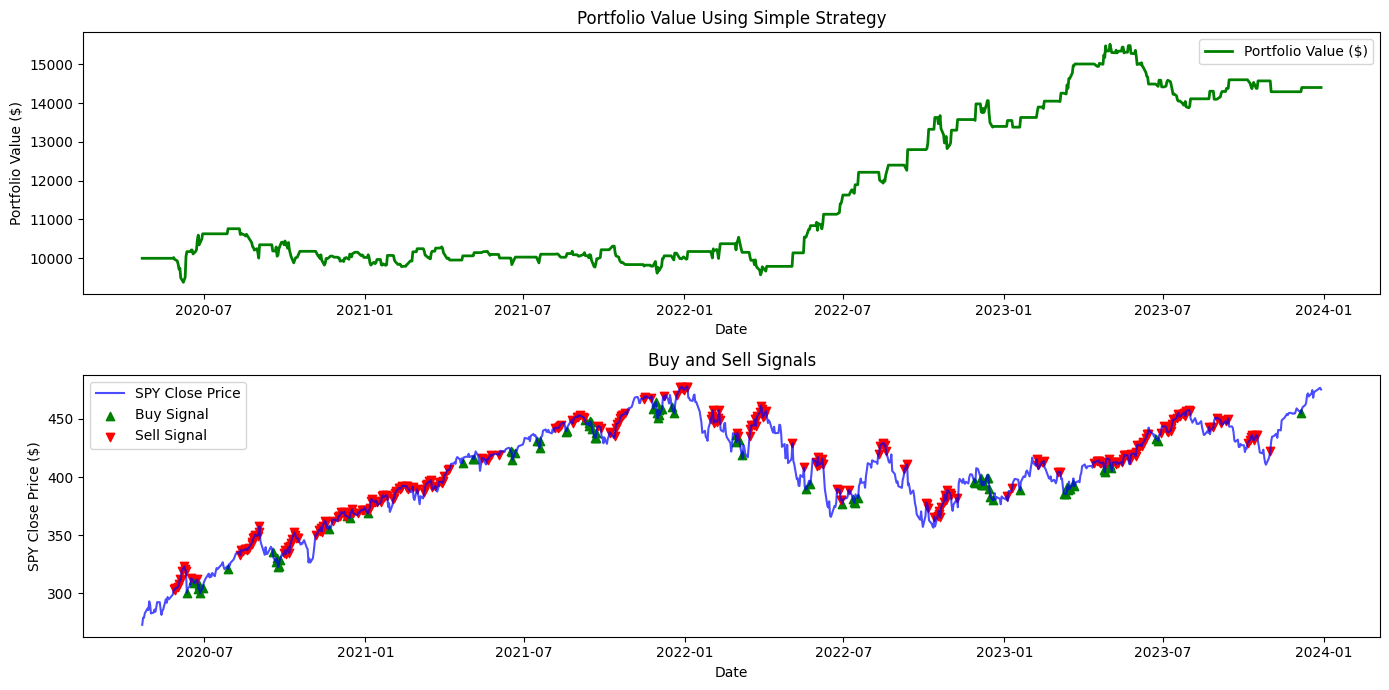

Final Portfolio Value: $14400.59


In [66]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta

# Download market and intermarket data (SPY and TLT)
start_date = "2020-04-21"
end_date = "2024-01-01"
spy = yf.download("SPY", start=start_date, end=end_date)
tlt = yf.download("TLT", start=start_date, end=end_date)

# Clean and flatten MultiIndex columns if necessary
spy.columns = spy.columns.droplevel(1)
tlt.columns = tlt.columns.droplevel(1)

# Calculate technical indicators using pandas_ta for SPY
spy['SMA_12'] = ta.sma(spy['Close'], 12)
tlt['SMA_26'] = ta.sma(tlt['Close'], 26)

# Calculate percentage change for SPY and TLT
spy['Pct_Change'] = spy['Close'].pct_change()
tlt['Pct_Change'] = tlt['Close'].pct_change()

# Generate Buy (1) and Sell (-1) signals based on the strategy
spy['Signal'] = np.where((spy['Close'] < spy['SMA_12']) & (tlt['Close'] > tlt['SMA_26']), 1, 0)
spy['Signal'] = np.where((spy['Close'] > spy['SMA_12']) & (tlt['Close'] < tlt['SMA_26']), -1, spy['Signal'])

# Calculate strategy returns: Calculate the daily returns of the strategy based on the signals
spy['Strategy_Return'] = spy['Signal'].shift(1) * spy['Pct_Change']  # Use the previous day's signal to trade the next day

# Calculate portfolio value: Starting with $10,000, track the cumulative returns
initial_capital = 10000
spy['Portfolio_Value'] = initial_capital * (1 + spy['Strategy_Return']).cumprod()

# Visualizing the performance
plt.figure(figsize=(14, 7))

# Plot Portfolio Value
plt.subplot(2, 1, 1)
plt.plot(spy.index, spy['Portfolio_Value'], label='Portfolio Value ($)', color='green', linewidth=2)
plt.title('Portfolio Value Using Simple Strategy')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()

# Plot Buy and Sell signals
plt.subplot(2, 1, 2)
plt.plot(spy.index, spy['Close'], label='SPY Close Price', color='blue', alpha=0.7)
plt.scatter(spy.index[spy['Signal'] == 1], spy['Close'][spy['Signal'] == 1], marker='^', color='g', label='Buy Signal', alpha=1)
plt.scatter(spy.index[spy['Signal'] == -1], spy['Close'][spy['Signal'] == -1], marker='v', color='r', label='Sell Signal', alpha=1)
plt.title('Buy and Sell Signals')
plt.xlabel('Date')
plt.ylabel('SPY Close Price ($)')
plt.legend()

plt.tight_layout()
plt.show()

# Print final portfolio value
final_value = spy['Portfolio_Value'].iloc[-1]
print(f"Final Portfolio Value: ${final_value:.2f}")


In [72]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta

# Download market data (SPY)
start_date = "2020-04-21"
end_date = "2024-01-01"
spy = yf.download("SPY", start=start_date, end=end_date)

# Clean and flatten MultiIndex columns if necessary
spy.columns = spy.columns.droplevel(1)

# Calculate ADX and SMA
adx = ta.adx(spy['High'], spy['Low'], spy['Close'], length=14)
spy['ADX'] = adx['ADX']  # Correctly assign ADX values to the DataFrame
spy['SMA_3'] = ta.sma(spy['Close'], 3)
spy['SMA_20'] = ta.sma(spy['Close'], 20)
spy['Upper_BB'], spy['Middle_BB'], spy['Lower_BB'] = ta.bbands(spy['Close'], length=20, std=2)

# Calculate daily percentage change for calculating returns
spy['Pct_Change'] = spy['Close'].pct_change()

# Create Buy (1) and Sell (-1) signals
spy['Signal'] = 0  # Default to no signal

# Trending Market: If ADX > 25, use SMA crossover
spy['Signal'] = np.where((spy['ADX'] > 25) & (spy['SMA_3'] > spy['SMA_20']), 1, spy['Signal'])  # Buy signal
spy['Signal'] = np.where((spy['ADX'] > 25) & (spy['SMA_3'] < spy['SMA_20']), -1, spy['Signal'])  # Sell signal

# Non-Trending Market: If ADX <= 25, use Bollinger Bands
spy['Signal'] = np.where((spy['ADX'] <= 25) & (spy['Close'] < spy['Lower_BB']), 1, spy['Signal'])  # Buy signal
spy['Signal'] = np.where((spy['ADX'] <= 25) & (spy['Close'] > spy['Upper_BB']), -1, spy['Signal'])  # Sell signal

# Calculate strategy returns: Calculate the daily returns of the strategy based on the signals
spy['Strategy_Return'] = spy['Signal'].shift(1) * spy['Pct_Change']  # Use the previous day's signal to trade the next day

# Calculate portfolio value: Starting with $10,000, track the cumulative returns
initial_capital = 10000
spy['Portfolio_Value'] = initial_capital * (1 + spy['Strategy_Return']).cumprod()

# Visualizing the performance
plt.figure(figsize=(14, 10))

# Plot Portfolio Value
plt.subplot(2, 1, 1)
plt.plot(spy.index, spy['Portfolio_Value'], label='Portfolio Value ($)', color='green', linewidth=2)
plt.title('Portfolio Value Using Trend and BB Strategy')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()

# Plot Buy and Sell signals with the Bollinger Bands and SMA crossover
plt.subplot(2, 1, 2)
plt.plot(spy.index, spy['Close'], label='SPY Close Price', color='blue', alpha=0.7)
plt.plot(spy.index, spy['Upper_BB'], label='Upper BB', color='red', linestyle='--')
plt.plot(spy.index, spy['Lower_BB'], label='Lower BB', color='red', linestyle='--')
plt.plot(spy.index, spy['Middle_BB'], label='Middle BB', color='black', linestyle='--')

# Mark Buy (green) and Sell (red) signals
plt.scatter(spy.index[spy['Signal'] == 1], spy['Close'][spy['Signal'] == 1], marker='^', color='g', label='Buy Signal', alpha=1)
plt.scatter(spy.index[spy['Signal'] == -1], spy['Close'][spy['Signal'] == -1], marker='v', color='r', label='Sell Signal', alpha=1)

plt.title('Buy and Sell Signals with BB and SMA Strategy')
plt.xlabel('Date')
plt.ylabel('SPY Close Price ($)')
plt.legend()

plt.tight_layout()
plt.show()

# Print final portfolio value
final_value = spy['Portfolio_Value'].iloc[-1]
print(f"Final Portfolio Value: ${final_value:.2f}")


[*********************100%***********************]  1 of 1 completed


KeyError: 'ADX'

In [70]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta

# Download market data (SPY)
start_date = "2020-04-21"
end_date = "2024-01-01"
spy = yf.download("SPY", start=start_date, end=end_date)

# Clean and flatten MultiIndex columns if necessary
spy.columns = spy.columns.droplevel(1)

# Calculate ADX and SMA
# The ta.adx() function returns a DataFrame. Access the 'ADX_14' column directly.
spy['ADX'] = ta.adx(spy['High'], spy['Low'], spy['Close'], length=14)['ADX_14']
spy['SMA_3'] = ta.sma(spy['Close'], 3)
spy['SMA_20'] = ta.sma(spy['Close'], 20)

# Calculate Bollinger Bands and assign to individual columns
bbands_df = ta.bbands(spy['Close'], length=20, std=2)
spy['Upper_BB'] = bbands_df['BBU_20_2.0']
spy['Middle_BB'] = bbands_df['BBM_20_2.0']
spy['Lower_BB'] = bbands_df['BBL_20_2.0']


# Calculate daily percentage change for calculating returns
spy['Pct_Change'] = spy['Close'].pct_change()

# Create Buy (1) and Sell (-1) signals
spy['Signal'] = 0  # Default to no signal

# Trending Market: If ADX > 25, use SMA crossover
spy['Signal'] = np.where((spy['ADX'] > 25) & (spy['SMA_3'] > spy['SMA_20']), 1, spy['Signal'])  # Buy signal
spy['Signal'] = np.where((spy['ADX'] > 25) & (spy['SMA_3'] < spy['SMA_20']), -1, spy['Signal'])  # Sell signal

# Non-Trending Market: If ADX <= 25, use Bollinger Bands
spy['Signal'] = np.where((spy['ADX'] <= 25) & (spy['Close'] < spy['Lower_BB']), 1, spy['Signal'])  # Buy signal
spy['Signal'] = np.where((spy['ADX'] <= 25) & (spy['Close'] > spy['Upper_BB']), -1, spy['Signal'])  # Sell signal

# Calculate strategy returns: Calculate the daily returns of the strategy based on the signals
spy['Strategy_Return'] = spy['Signal'].shift(1) * spy['Pct_Change']  # Use the previous day's signal to trade the next day

# Calculate portfolio value: Starting with $10,000, track the cumulative returns
initial_capital = 10000
spy['Portfolio_Value'] = initial_capital * (1 + spy['Strategy_Return']).cumprod()

# Visualizing the performance
plt.figure(figsize=(14, 10))



[*********************100%***********************]  1 of 1 completed


<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

In [75]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Download S&P 500 data (you can replace 'S&P500 data' with another instrument for Data2)
data_sp500 = yf.download('^GSPC', start='2020-01-01', end='2024-01-01', interval='1d')
data_other = yf.download('AAPL', start='2020-01-01', end='2024-01-01', interval='1d')  # Replace with another dataset for Data2



data_sp500
data_other



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price        Adj Close       Close        High         Low        Open  \
Ticker            AAPL        AAPL        AAPL        AAPL        AAPL   
Date                                                                     
2020-01-02   72.796028   75.087502   75.150002   73.797501   74.059998   
2020-01-03   72.088295   74.357498   75.144997   74.125000   74.287498   
2020-01-06   72.662720   74.949997   74.989998   73.187500   73.447502   
2020-01-07   72.320984   74.597504   75.224998   74.370003   74.959999   
2020-01-08   73.484360   75.797501   76.110001   74.290001   74.290001   
...                ...         ...         ...         ...         ...   
2023-12-22  192.656189  193.600006  195.410004  192.970001  195.179993   
2023-12-26  192.108856  193.050003  193.889999  192.830002  193.610001   
2023-12-27  192.208359  193.149994  193.500000  191.089996  192.490005   
2023-12-28  192.636261  193.580002  194.660004  193.169998  194.139999   
2023-12-29  191.591400  192.529999  194.399994  191.729996  193.899994   

Price          Volume  
Ticker           AAPL  
Date                   
2020-01-02  135480400  
2020-01-03  146322800  
2020-01-06  118387200  
2020-01-07  108872000  
2020-01-08  132079200  
...               ...  
2023-12-22   37122800  
2023-12-26   28919300  
2023-12-27   48087700  
2023-12-28   34049900  
2023-12-29   42628800  

[1006 rows x 6 columns]

In [76]:
# Clean data by flattening MultiIndex columns
data_sp500.columns = data_sp500.columns.droplevel(1)  # Flatten the MultiIndex columns for SPY
data_other.columns = data_other.columns.droplevel(1)  # Flatten the MultiIndex columns for TLT



In [77]:
# Align data to the same index (dates)
data_sp500, data_other = data_sp500.align(tlt, join='inner')


In [78]:

# Check for missing values and remove them if necessary
data_sp500.dropna(inplace=True)
data_other.dropna(inplace=True)

In [79]:
data_sp500

Price         Adj Close        Close         High          Low         Open  \
Date                                                                          
2020-04-21  2736.560059  2736.560059  2785.540039  2727.100098  2784.810059   
2020-04-22  2799.310059  2799.310059  2815.100098  2775.949951  2787.889893   
2020-04-23  2797.800049  2797.800049  2844.899902  2794.260010  2810.419922   
2020-04-24  2836.739990  2836.739990  2842.709961  2791.760010  2812.639893   
2020-04-27  2878.479980  2878.479980  2887.719971  2852.889893  2854.649902   
...                 ...          ...          ...          ...          ...   
2023-12-22  4754.629883  4754.629883  4772.939941  4736.770020  4753.919922   
2023-12-26  4774.750000  4774.750000  4784.720215  4758.450195  4758.859863   
2023-12-27  4781.580078  4781.580078  4785.390137  4768.899902  4773.450195   
2023-12-28  4783.350098  4783.350098  4793.299805  4780.979980  4786.439941   
2023-12-29  4769.830078  4769.830078  4788.430176  4751.990234  4782.879883   

Price           Volume  
Date                    
2020-04-21  5121010000  
2020-04-22  5084920000  
2020-04-23  5773530000  
2020-04-24  5382810000  
2020-04-27  5203930000  
...                ...  
2023-12-22  3046770000  
2023-12-26  2513910000  
2023-12-27  2748450000  
2023-12-28  2698860000  
2023-12-29  3126060000  

[931 rows x 6 columns]

In [80]:
data_other

Price        Adj Close       Close        High         Low        Open  \
Date                                                                     
2020-04-21  152.031876  171.289993  172.149994  170.779999  171.929993   
2020-04-22  150.478653  169.539993  170.389999  168.710007  169.970001   
2020-04-23  151.277405  170.440002  170.929993  169.610001  169.869995   
2020-04-24  151.632477  170.839996  170.839996  169.570007  169.610001   
2020-04-27  148.810013  167.660004  169.750000  167.440002  169.660004   
...                ...         ...         ...         ...         ...   
2023-12-22   94.962257   98.480003   99.379997   98.239998   99.379997   
2023-12-26   95.232254   98.760002   98.870003   98.480003   98.540001   
2023-12-27   96.919731  100.510002  100.529999   99.500000   99.779999   
2023-12-28   96.215805   99.779999  100.570000   99.559998  100.089996   
2023-12-29   95.347954   98.879997   99.820000   98.800003   99.129997   

Price         Volume  
Date                  
2020-04-21   7850700  
2020-04-22   6230200  
2020-04-23   5968600  
2020-04-24   6211800  
2020-04-27   9039500  
...              ...  
2023-12-22  29237200  
2023-12-26  24019700  
2023-12-27  45082800  
2023-12-28  36213000  
2023-12-29  41601700  

[931 rows x 6 columns]

<ipython-input-81-70a5a6581fc0>:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if InterPred[i] > 0 and TrPred[i] > 0 and TrOsc[i] < 0 and InterOsc[i] > 0:
<ipython-input-81-70a5a6581fc0>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif InterPred[i] < 0 and TrPred[i] < 0 and TrOsc[i] > 0 and InterOsc[i] < 0:


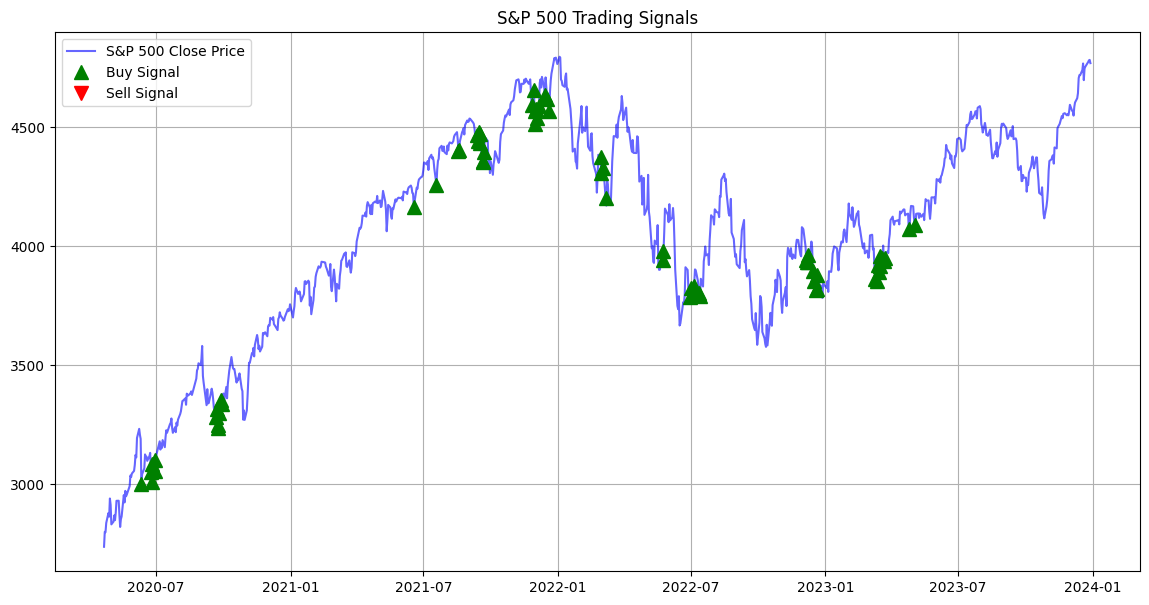

In [81]:
# Step 2: Calculate RSMemPred (placeholder function, needs proper definition)
def RSMemPred(data, win, poles, LK):
    # Implement the prediction logic or use a suitable model
    # For simplicity, we'll use a placeholder that returns a simple moving average
    return data.rolling(window=win).mean()

# Step 3: Calculate oscillators
def calculate_oscillator(data, length):
    return data['Close'] - data['Close'].rolling(window=length).mean()

# Step 4: Apply the strategy
def apply_trading_logic(data1, data2, TrLen, InterLen, Win, Poles, LK1, LK2):
    # Calculate predictions
    TrPred = RSMemPred(data1['Close'], Win, Poles, LK1)
    InterPred = RSMemPred(data2['Close'], Win, Poles, LK2)

    # Calculate oscillators
    TrOsc = calculate_oscillator(data1, TrLen)
    InterOsc = calculate_oscillator(data2, InterLen)

    # Initialize signal array
    signals = np.zeros(len(data1))  # Default to no signal (0)

    # Apply trade logic
    for i in range(1, len(data1)):
        # Buy condition
        if InterPred[i] > 0 and TrPred[i] > 0 and TrOsc[i] < 0 and InterOsc[i] > 0:
            signals[i] = 1  # Buy signal

        # Sell condition
        elif InterPred[i] < 0 and TrPred[i] < 0 and TrOsc[i] > 0 and InterOsc[i] < 0:
            signals[i] = -1  # Sell signal

    return signals

# Step 5: Apply the strategy and plot
TrLen = 20
InterLen = 30
Win = 30
Poles = 6
LK1 = 6
LK2 = 6

signals = apply_trading_logic(data_sp500, data_other, TrLen, InterLen, Win, Poles, LK1, LK2)

# Plotting the signals on the S&P 500 Close Price
plt.figure(figsize=(14, 7))
plt.plot(data_sp500['Close'], label='S&P 500 Close Price', color='blue', alpha=0.6)

# Plot Buy and Sell signals
plt.plot(data_sp500.index[signals == 1], data_sp500['Close'][signals == 1], '^', markersize=10, color='green', label='Buy Signal')
plt.plot(data_sp500.index[signals == -1], data_sp500['Close'][signals == -1], 'v', markersize=10, color='red', label='Sell Signal')

# Customize plot
plt.title('S&P 500 Trading Signals')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [82]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Download the data (S&P 500 and T-Bonds)
data_sp500 = yf.download('^GSPC', start='2020-01-01', end='2024-01-01', interval='1d')
data_tbonds = yf.download('^IRX', start='2020-01-01', end='2024-01-01', interval='1d')  # T-Bonds Futures (use appropriate symbol)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [83]:
data_sp500

Price         Adj Close        Close         High          Low         Open  \
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC        ^GSPC   
Date                                                                          
2020-01-02  3257.850098  3257.850098  3258.139893  3235.530029  3244.669922   
2020-01-03  3234.850098  3234.850098  3246.149902  3222.340088  3226.360107   
2020-01-06  3246.280029  3246.280029  3246.840088  3214.639893  3217.550049   
2020-01-07  3237.179932  3237.179932  3244.909912  3232.429932  3241.860107   
2020-01-08  3253.050049  3253.050049  3267.070068  3236.669922  3238.590088   
...                 ...          ...          ...          ...          ...   
2023-12-22  4754.629883  4754.629883  4772.939941  4736.770020  4753.919922   
2023-12-26  4774.750000  4774.750000  4784.720215  4758.450195  4758.859863   
2023-12-27  4781.580078  4781.580078  4785.390137  4768.899902  4773.450195   
2023-12-28  4783.350098  4783.350098  4793.299805  4780.979980  4786.439941   
2023-12-29  4769.830078  4769.830078  4788.430176  4751.990234  4782.879883   

Price           Volume  
Ticker           ^GSPC  
Date                    
2020-01-02  3459930000  
2020-01-03  3484700000  
2020-01-06  3702460000  
2020-01-07  3435910000  
2020-01-08  3726840000  
...                ...  
2023-12-22  3046770000  
2023-12-26  2513910000  
2023-12-27  2748450000  
2023-12-28  2698860000  
2023-12-29  3126060000  

[1006 rows x 6 columns]

In [84]:
data_tbonds

Price      Adj Close  Close   High    Low   Open Volume
Ticker          ^IRX   ^IRX   ^IRX   ^IRX   ^IRX   ^IRX
Date                                                   
2020-01-02     1.495  1.495  1.510  1.495  1.510      0
2020-01-03     1.473  1.473  1.490  1.460  1.490      0
2020-01-06     1.488  1.488  1.490  1.475  1.478      0
2020-01-07     1.500  1.500  1.505  1.500  1.505      0
2020-01-08     1.493  1.493  1.493  1.485  1.493      0
...              ...    ...    ...    ...    ...    ...
2023-12-22     5.208  5.208  5.210  5.173  5.200      0
2023-12-26     5.203  5.203  5.223  5.198  5.210      0
2023-12-27     5.235  5.235  5.235  5.100  5.230      0
2023-12-28     5.218  5.218  5.228  5.218  5.218      0
2023-12-29     5.180  5.180  5.208  5.145  5.205      0

[1006 rows x 6 columns]

In [85]:
# Clean data by flattening MultiIndex columns
data_sp500.columns = data_sp500.columns.droplevel(1)  # Flatten the MultiIndex columns for SPY
data_tbonds.columns = data_tbonds.columns.droplevel(1)  # Flatten the MultiIndex columns for TLT

In [86]:
data_sp500

Price         Adj Close        Close         High          Low         Open  \
Date                                                                          
2020-01-02  3257.850098  3257.850098  3258.139893  3235.530029  3244.669922   
2020-01-03  3234.850098  3234.850098  3246.149902  3222.340088  3226.360107   
2020-01-06  3246.280029  3246.280029  3246.840088  3214.639893  3217.550049   
2020-01-07  3237.179932  3237.179932  3244.909912  3232.429932  3241.860107   
2020-01-08  3253.050049  3253.050049  3267.070068  3236.669922  3238.590088   
...                 ...          ...          ...          ...          ...   
2023-12-22  4754.629883  4754.629883  4772.939941  4736.770020  4753.919922   
2023-12-26  4774.750000  4774.750000  4784.720215  4758.450195  4758.859863   
2023-12-27  4781.580078  4781.580078  4785.390137  4768.899902  4773.450195   
2023-12-28  4783.350098  4783.350098  4793.299805  4780.979980  4786.439941   
2023-12-29  4769.830078  4769.830078  4788.430176  4751.990234  4782.879883   

Price           Volume  
Date                    
2020-01-02  3459930000  
2020-01-03  3484700000  
2020-01-06  3702460000  
2020-01-07  3435910000  
2020-01-08  3726840000  
...                ...  
2023-12-22  3046770000  
2023-12-26  2513910000  
2023-12-27  2748450000  
2023-12-28  2698860000  
2023-12-29  3126060000  

[1006 rows x 6 columns]

In [96]:
# Align data to the same index (dates)

data_sp500, data_tbonds = data_sp500.align(data_tbonds, join='inner')

# remove missing values
data_sp500.dropna(inplace=True)
data_tbonds.dropna(inplace=True)

In [89]:
data_sp500


Price         Adj Close        Close         High          Low         Open  \
Date                                                                          
2020-01-02  3257.850098  3257.850098  3258.139893  3235.530029  3244.669922   
2020-01-03  3234.850098  3234.850098  3246.149902  3222.340088  3226.360107   
2020-01-06  3246.280029  3246.280029  3246.840088  3214.639893  3217.550049   
2020-01-07  3237.179932  3237.179932  3244.909912  3232.429932  3241.860107   
2020-01-08  3253.050049  3253.050049  3267.070068  3236.669922  3238.590088   
...                 ...          ...          ...          ...          ...   
2023-12-22  4754.629883  4754.629883  4772.939941  4736.770020  4753.919922   
2023-12-26  4774.750000  4774.750000  4784.720215  4758.450195  4758.859863   
2023-12-27  4781.580078  4781.580078  4785.390137  4768.899902  4773.450195   
2023-12-28  4783.350098  4783.350098  4793.299805  4780.979980  4786.439941   
2023-12-29  4769.830078  4769.830078  4788.430176  4751.990234  4782.879883   

Price           Volume  
Date                    
2020-01-02  3459930000  
2020-01-03  3484700000  
2020-01-06  3702460000  
2020-01-07  3435910000  
2020-01-08  3726840000  
...                ...  
2023-12-22  3046770000  
2023-12-26  2513910000  
2023-12-27  2748450000  
2023-12-28  2698860000  
2023-12-29  3126060000  

[1006 rows x 6 columns]

In [90]:
data_tbonds

Price       Adj Close  Close   High    Low   Open  Volume
Date                                                     
2020-01-02      1.495  1.495  1.510  1.495  1.510       0
2020-01-03      1.473  1.473  1.490  1.460  1.490       0
2020-01-06      1.488  1.488  1.490  1.475  1.478       0
2020-01-07      1.500  1.500  1.505  1.500  1.505       0
2020-01-08      1.493  1.493  1.493  1.485  1.493       0
...               ...    ...    ...    ...    ...     ...
2023-12-22      5.208  5.208  5.210  5.173  5.200       0
2023-12-26      5.203  5.203  5.223  5.198  5.210       0
2023-12-27      5.235  5.235  5.235  5.100  5.230       0
2023-12-28      5.218  5.218  5.228  5.218  5.218       0
2023-12-29      5.180  5.180  5.208  5.145  5.205       0

[1006 rows x 6 columns]

<ipython-input-91-4d5a8e629e19>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"sp500_pred[i]: {sp500_pred[i]}, tbonds_pred[i]: {tbonds_pred[i]}, sp500_osc[i]: {sp500_osc[i]}, tbonds_osc[i]: {tbonds_osc[i]}")
<ipython-input-91-4d5a8e629e19>:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if tbonds_osc[i] > 0 and sp500_osc[i] < 0 and tbonds_pred[i] > 0 and sp500_pred[i] > 0:
<ipython-input-91-4d5a8e629e19>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value 

sp500_pred[i]: nan, tbonds_pred[i]: nan, sp500_osc[i]: nan, tbonds_osc[i]: nan
sp500_pred[i]: nan, tbonds_pred[i]: nan, sp500_osc[i]: nan, tbonds_osc[i]: nan
sp500_pred[i]: nan, tbonds_pred[i]: nan, sp500_osc[i]: nan, tbonds_osc[i]: nan
sp500_pred[i]: nan, tbonds_pred[i]: nan, sp500_osc[i]: nan, tbonds_osc[i]: nan
sp500_pred[i]: nan, tbonds_pred[i]: nan, sp500_osc[i]: nan, tbonds_osc[i]: nan
sp500_pred[i]: nan, tbonds_pred[i]: nan, sp500_osc[i]: nan, tbonds_osc[i]: nan
sp500_pred[i]: nan, tbonds_pred[i]: nan, sp500_osc[i]: nan, tbonds_osc[i]: nan
sp500_pred[i]: nan, tbonds_pred[i]: nan, sp500_osc[i]: nan, tbonds_osc[i]: nan
sp500_pred[i]: nan, tbonds_pred[i]: nan, sp500_osc[i]: nan, tbonds_osc[i]: nan
sp500_pred[i]: nan, tbonds_pred[i]: nan, sp500_osc[i]: nan, tbonds_osc[i]: nan
sp500_pred[i]: nan, tbonds_pred[i]: nan, sp500_osc[i]: nan, tbonds_osc[i]: nan
sp500_pred[i]: nan, tbonds_pred[i]: nan, sp500_osc[i]: nan, tbonds_osc[i]: nan
sp500_pred[i]: nan, tbonds_pred[i]: nan, sp500_osc[i

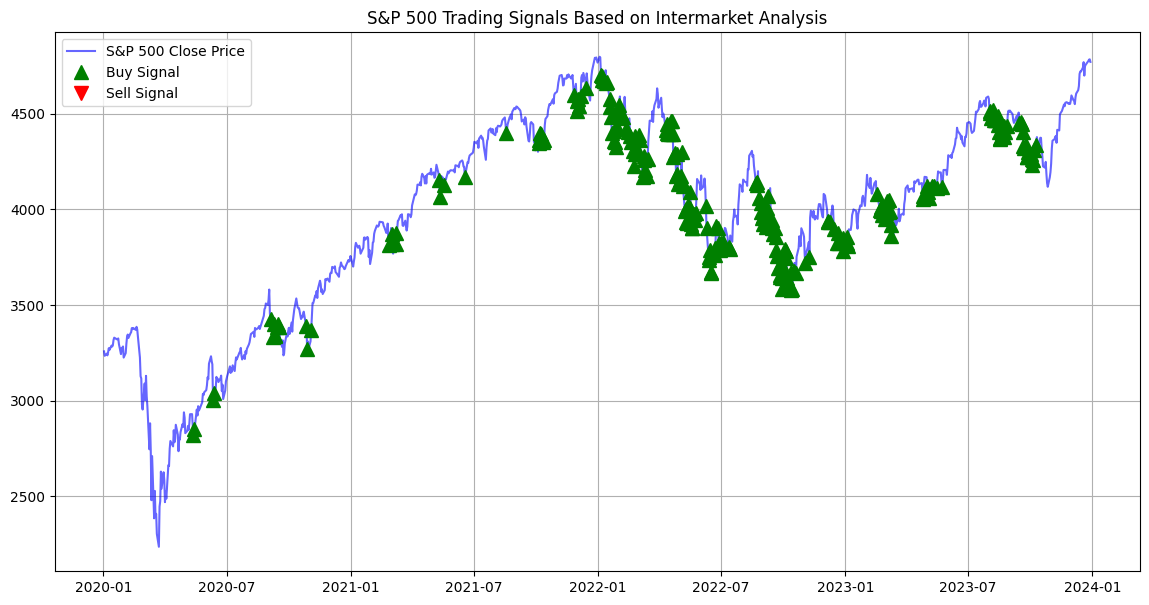

In [91]:
# Step 2: Calculate a simple moving average as a proxy for MEM prediction
def RSMemPred(data, win):
    return data.rolling(window=win).mean()

# Step 3: Calculate trend indicators for both S&P 500 and T-Bonds
def calculate_oscillator(data, length):
    return data['Close'] - data['Close'].rolling(window=length).mean()

# Step 4: Apply Intermarket Strategy Logic
def apply_trading_logic(data_sp500, data_tbonds, TrLen, Win, LK1, LK2):
    # Calculate MEM predictions
    sp500_pred = RSMemPred(data_sp500['Close'], Win)
    tbonds_pred = RSMemPred(data_tbonds['Close'], Win)

    # Calculate oscillators for trend confirmation
    sp500_osc = calculate_oscillator(data_sp500, TrLen)
    tbonds_osc = calculate_oscillator(data_tbonds, TrLen)

    # Initialize signal array
    signals = np.zeros(len(data_sp500))  # Default to no signal (0)

    # Apply trading logic
    for i in range(1, len(data_sp500)):
        # Print values for debugging
        print(f"sp500_pred[i]: {sp500_pred[i]}, tbonds_pred[i]: {tbonds_pred[i]}, sp500_osc[i]: {sp500_osc[i]}, tbonds_osc[i]: {tbonds_osc[i]}")

        # Buy condition: T-Bonds in uptrend, S&P in downtrend, both MEM predictions positive
        if tbonds_osc[i] > 0 and sp500_osc[i] < 0 and tbonds_pred[i] > 0 and sp500_pred[i] > 0:
            signals[i] = 1  # Buy S&P 500
            print(f"Buy Signal at {data_sp500.index[i]}")

        # Sell condition: T-Bonds in downtrend, S&P in uptrend, both MEM predictions negative
        elif tbonds_osc[i] < 0 and sp500_osc[i] > 0 and tbonds_pred[i] < 0 and sp500_pred[i] < 0:
            signals[i] = -1  # Sell S&P 500
            print(f"Sell Signal at {data_sp500.index[i]}")

    return signals

# Step 5: Apply the strategy and plot results
TrLen = 20  # Oscillator Length
Win = 30  # Window for MEM prediction
LK1 = 6  # Parameter for MEM prediction (can adjust)
LK2 = 6  # Parameter for MEM prediction (can adjust)

signals = apply_trading_logic(data_sp500, data_tbonds, TrLen, Win, LK1, LK2)

# Plotting the results on S&P 500 Close Price
plt.figure(figsize=(14, 7))
plt.plot(data_sp500['Close'], label='S&P 500 Close Price', color='blue', alpha=0.6)

# Plot Buy and Sell signals
plt.plot(data_sp500.index[signals == 1], data_sp500['Close'][signals == 1], '^', markersize=10, color='green', label='Buy Signal')
plt.plot(data_sp500.index[signals == -1], data_sp500['Close'][signals == -1], 'v', markersize=10, color='red', label='Sell Signal')

# Customize plot
plt.title('S&P 500 Trading Signals Based on Intermarket Analysis')
plt.legend(loc='best')
plt.grid(True)
plt.show()


# Back Testing

In [108]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Download the data (S&P 500 and T-Bonds) for the backtest period
start_date = '2024-01-28'
end_date = '2024-12-05'

data_sp500_test = yf.download('^GSPC', start=start_date, end=end_date, interval='1d')
data_tbonds_test = yf.download('^IRX', start=start_date, end=end_date, interval='1d')  # T-Bonds Futures (13-week T-Bills)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [109]:
data_sp500_test

Price         Adj Close        Close         High          Low         Open  \
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC        ^GSPC   
Date                                                                          
2024-01-29  4927.930176  4927.930176  4929.310059  4887.399902  4892.950195   
2024-01-30  4924.970215  4924.970215  4931.089844  4916.270020  4925.890137   
2024-01-31  4845.649902  4845.649902  4906.750000  4845.149902  4899.189941   
2024-02-01  4906.189941  4906.189941  4906.970215  4853.520020  4861.109863   
2024-02-02  4958.609863  4958.609863  4975.290039  4907.990234  4916.060059   
...                 ...          ...          ...          ...          ...   
2024-11-27  5998.740234  5998.740234  6020.160156  5984.870117  6014.109863   
2024-11-29  6032.379883  6032.379883  6044.169922  6003.979980  6003.979980   
2024-12-02  6047.149902  6047.149902  6053.580078  6035.330078  6040.109863   
2024-12-03  6049.879883  6049.879883  6052.069824  6033.390137  6042.970215   
2024-12-04  6086.490234  6086.490234  6089.839844  6061.060059  6069.390137   

Price           Volume  
Ticker           ^GSPC  
Date                    
2024-01-29  3525160000  
2024-01-30  3836130000  
2024-01-31  4696120000  
2024-02-01  4386090000  
2024-02-02  3974350000  
...                ...  
2024-11-27  3363340000  
2024-11-29  2444420000  
2024-12-02  4412470000  
2024-12-03  4095000000  
2024-12-04  4003390000  

[216 rows x 6 columns]

In [110]:
data_tbonds_test

Price      Adj Close  Close   High    Low   Open Volume
Ticker          ^IRX   ^IRX   ^IRX   ^IRX   ^IRX   ^IRX
Date                                                   
2024-01-29     5.200  5.200  5.203  5.200  5.203      0
2024-01-30     5.203  5.203  5.208  5.198  5.200      0
2024-01-31     5.188  5.188  5.205  5.135  5.205      0
2024-02-01     5.200  5.200  5.200  5.193  5.195      0
2024-02-02     5.210  5.210  5.220  5.188  5.200      0
...              ...    ...    ...    ...    ...    ...
2024-11-27     4.385  4.385  4.397  4.385  4.388      0
2024-11-29     4.373  4.373  4.388  4.368  4.385      0
2024-12-02     4.380  4.380  4.397  4.375  4.375      0
2024-12-03     4.357  4.357  4.368  4.353  4.365      0
2024-12-04     4.345  4.345  4.355  4.340  4.355      0

[216 rows x 6 columns]

In [111]:
# Clean data by flattening MultiIndex columns
data_sp500_test.columns = data_sp500_test.columns.droplevel(1)  # Flatten the MultiIndex columns for SPY
data_tbonds_test.columns = data_tbonds_test.columns.droplevel(1)  # Flatten the MultiIndex columns for TLT






In [113]:
data_sp500_test

Price         Adj Close        Close         High          Low         Open  \
Date                                                                          
2024-01-29  4927.930176  4927.930176  4929.310059  4887.399902  4892.950195   
2024-01-30  4924.970215  4924.970215  4931.089844  4916.270020  4925.890137   
2024-01-31  4845.649902  4845.649902  4906.750000  4845.149902  4899.189941   
2024-02-01  4906.189941  4906.189941  4906.970215  4853.520020  4861.109863   
2024-02-02  4958.609863  4958.609863  4975.290039  4907.990234  4916.060059   
...                 ...          ...          ...          ...          ...   
2024-11-27  5998.740234  5998.740234  6020.160156  5984.870117  6014.109863   
2024-11-29  6032.379883  6032.379883  6044.169922  6003.979980  6003.979980   
2024-12-02  6047.149902  6047.149902  6053.580078  6035.330078  6040.109863   
2024-12-03  6049.879883  6049.879883  6052.069824  6033.390137  6042.970215   
2024-12-04  6086.490234  6086.490234  6089.839844  6061.060059  6069.390137   

Price           Volume  
Date                    
2024-01-29  3525160000  
2024-01-30  3836130000  
2024-01-31  4696120000  
2024-02-01  4386090000  
2024-02-02  3974350000  
...                ...  
2024-11-27  3363340000  
2024-11-29  2444420000  
2024-12-02  4412470000  
2024-12-03  4095000000  
2024-12-04  4003390000  

[216 rows x 6 columns]

In [114]:
data_tbonds_test

Price       Adj Close  Close   High    Low   Open  Volume
Date                                                     
2024-01-29      5.200  5.200  5.203  5.200  5.203       0
2024-01-30      5.203  5.203  5.208  5.198  5.200       0
2024-01-31      5.188  5.188  5.205  5.135  5.205       0
2024-02-01      5.200  5.200  5.200  5.193  5.195       0
2024-02-02      5.210  5.210  5.220  5.188  5.200       0
...               ...    ...    ...    ...    ...     ...
2024-11-27      4.385  4.385  4.397  4.385  4.388       0
2024-11-29      4.373  4.373  4.388  4.368  4.385       0
2024-12-02      4.380  4.380  4.397  4.375  4.375       0
2024-12-03      4.357  4.357  4.368  4.353  4.365       0
2024-12-04      4.345  4.345  4.355  4.340  4.355       0

[216 rows x 6 columns]

In [115]:



# clean the data

data_sp500_test.dropna(inplace=True)
data_tbonds_test.dropna(inplace=True)

In [116]:


# Align data to the same index (dates)
data_sp500_test, data_tbonds_test = data_sp500_test.align(data_tbonds_test, join='inner')






In [117]:
data_sp500_test

Price         Adj Close        Close         High          Low         Open  \
Date                                                                          
2024-01-29  4927.930176  4927.930176  4929.310059  4887.399902  4892.950195   
2024-01-30  4924.970215  4924.970215  4931.089844  4916.270020  4925.890137   
2024-01-31  4845.649902  4845.649902  4906.750000  4845.149902  4899.189941   
2024-02-01  4906.189941  4906.189941  4906.970215  4853.520020  4861.109863   
2024-02-02  4958.609863  4958.609863  4975.290039  4907.990234  4916.060059   
...                 ...          ...          ...          ...          ...   
2024-11-27  5998.740234  5998.740234  6020.160156  5984.870117  6014.109863   
2024-11-29  6032.379883  6032.379883  6044.169922  6003.979980  6003.979980   
2024-12-02  6047.149902  6047.149902  6053.580078  6035.330078  6040.109863   
2024-12-03  6049.879883  6049.879883  6052.069824  6033.390137  6042.970215   
2024-12-04  6086.490234  6086.490234  6089.839844  6061.060059  6069.390137   

Price           Volume  
Date                    
2024-01-29  3525160000  
2024-01-30  3836130000  
2024-01-31  4696120000  
2024-02-01  4386090000  
2024-02-02  3974350000  
...                ...  
2024-11-27  3363340000  
2024-11-29  2444420000  
2024-12-02  4412470000  
2024-12-03  4095000000  
2024-12-04  4003390000  

[216 rows x 6 columns]

In [118]:
data_tbonds_test

Price       Adj Close  Close   High    Low   Open  Volume
Date                                                     
2024-01-29      5.200  5.200  5.203  5.200  5.203       0
2024-01-30      5.203  5.203  5.208  5.198  5.200       0
2024-01-31      5.188  5.188  5.205  5.135  5.205       0
2024-02-01      5.200  5.200  5.200  5.193  5.195       0
2024-02-02      5.210  5.210  5.220  5.188  5.200       0
...               ...    ...    ...    ...    ...     ...
2024-11-27      4.385  4.385  4.397  4.385  4.388       0
2024-11-29      4.373  4.373  4.388  4.368  4.385       0
2024-12-02      4.380  4.380  4.397  4.375  4.375       0
2024-12-03      4.357  4.357  4.368  4.353  4.365       0
2024-12-04      4.345  4.345  4.355  4.340  4.355       0

[216 rows x 6 columns]

<ipython-input-124-7178c3539bc8>:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if tbonds_osc[i] > 0 and sp500_osc[i] < 0 and tbonds_pred[i] > 0 and sp500_pred[i] > 0 and position == 0:
<ipython-input-124-7178c3539bc8>:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif tbonds_osc[i] < 0 and sp500_osc[i] > 0 and tbonds_pred[i] < 0 and sp500_pred[i] < 0 and position == 0:
<ipython-input-124-7178c3539bc8>:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

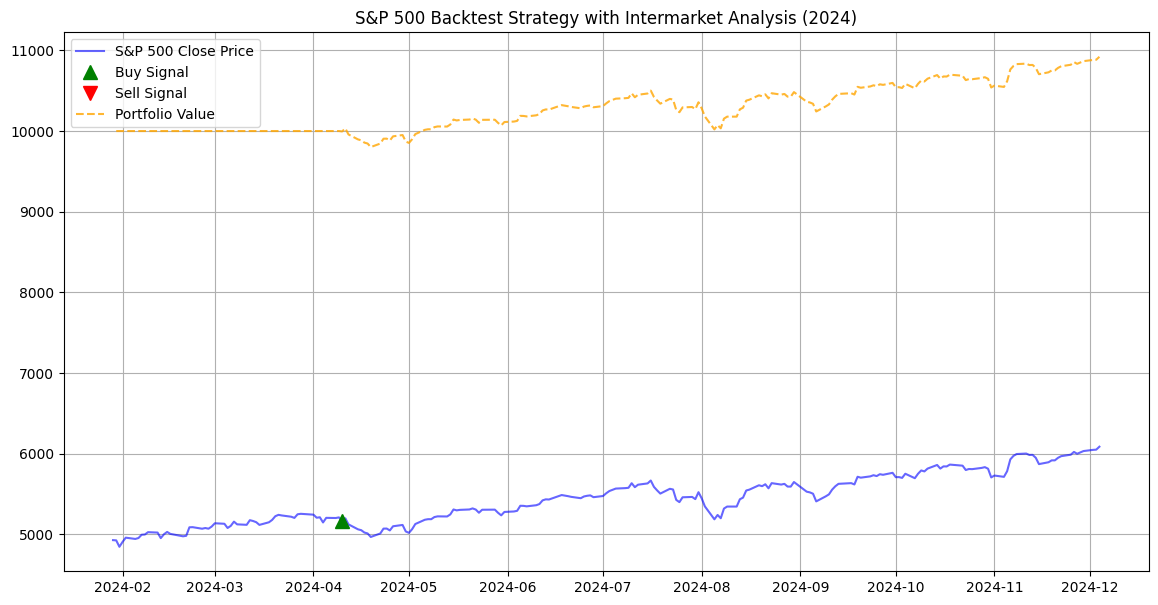

Final Portfolio Value: 10920.69
Total Return: 9.21%


In [124]:
# Step 2: Calculate a simple moving average as a proxy for MEM prediction
def RSMemPred(data, win):
    return data.rolling(window=win).mean()

# Step 3: Calculate oscillators for trend confirmation
def calculate_oscillator(data, length):
    return data['Close'] - data['Close'].rolling(window=length).mean()

# Step 4: Apply Intermarket Strategy Logic with backtesting
def apply_trading_logic_and_backtest(data_sp500, data_tbonds, TrLen, Win, LK1, LK2, initial_cash=10000, transaction_cost=0.001):
    # Calculate MEM predictions
    sp500_pred = RSMemPred(data_sp500_test['Close'], Win)
    tbonds_pred = RSMemPred(data_tbonds_test['Close'], Win)

    # Calculate oscillators for trend confirmation
    sp500_osc = calculate_oscillator(data_sp500_test, TrLen)
    tbonds_osc = calculate_oscillator(data_tbonds_test, TrLen)

    # Initialize variables for backtest
    signals = np.zeros(len(data_sp500))  # Default to no signal (0)
    portfolio_value = initial_cash  # Starting portfolio value
    position = 0  # 1 means long position, -1 means short position, 0 means no position
    cash = initial_cash  # Available cash
    shares_held = 0  # Number of shares held in S&P 500
    portfolio_values = []  # List to store portfolio value over time

    # Apply trading logic and track portfolio performance
    for i in range(1, len(data_sp500)):
        # Buy condition: T-Bonds in uptrend, S&P in downtrend, both MEM predictions positive
        if tbonds_osc[i] > 0 and sp500_osc[i] < 0 and tbonds_pred[i] > 0 and sp500_pred[i] > 0 and position == 0:
            signals[i] = 1  # Buy S&P 500
            # Buying S&P 500 shares with available cash
            position = 1  # Long position
            shares_held = cash // data_sp500_test['Close'][i]  # Calculate number of shares we can buy
            cash -= shares_held * data_sp500_test['Close'][i] * (1 + transaction_cost)  # Deduct cash for purchase

        # Sell condition: T-Bonds in downtrend, S&P in uptrend, both MEM predictions negative
        elif tbonds_osc[i] < 0 and sp500_osc[i] > 0 and tbonds_pred[i] < 0 and sp500_pred[i] < 0 and position == 0:
            signals[i] = -1  # Sell S&P 500
            # Selling S&P 500 shares
            position = -1  # Short position
            shares_held = cash // data_sp500['Close'][i]  # Calculate number of shares we can short
            cash += shares_held * data_sp500['Close'][i] * (1 - transaction_cost)  # Cash from short sale

        # Track portfolio value after each trading decision
        if position == 1:  # If we are in a long position
            portfolio_value = cash + shares_held * data_sp500_test['Close'][i]  # Value of position + remaining cash
        elif position == -1:  # If we are in a short position
            portfolio_value = cash + shares_held * (data_sp500_test['Close'][i] - data_sp500_test['Close'][i])  # Update based on short position
        else:  # No position
            portfolio_value = cash

        portfolio_values.append(portfolio_value)

    return portfolio_values, signals

# Step 5: Run backtest and visualize performance
TrLen = 20  # Oscillator Length
Win = 30  # Window for MEM prediction
LK1 = 6  # Parameter for MEM prediction (can adjust)
LK2 = 6  # Parameter for MEM prediction (can adjust)

# Backtest strategy
portfolio_values, signals = apply_trading_logic_and_backtest(data_sp500, data_tbonds, TrLen, Win, LK1, LK2)

# Step 6: Plotting the results of the backtest
plt.figure(figsize=(14, 7))
plt.plot(data_sp500_test['Close'], label='S&P 500 Close Price', color='blue', alpha=0.6)

# Plot Buy and Sell signals
plt.plot(data_sp500_test.index[signals == 1], data_sp500_test['Close'][signals == 1], '^', markersize=10, color='green', label='Buy Signal')
plt.plot(data_sp500_test.index[signals == -1], data_sp500_test['Close'][signals == -1], 'v', markersize=10, color='red', label='Sell Signal')

# Plot portfolio value
plt.plot(data_sp500_test.index[1:], portfolio_values, label='Portfolio Value', color='orange', linestyle='--', alpha=0.8)

# Customize plot
plt.title('S&P 500 Backtest Strategy with Intermarket Analysis (2024)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Calculate final portfolio value and performance metrics
final_value = portfolio_values[-1]
total_return = (final_value - 10000) / 10000  # Assuming initial portfolio value of 10000
print(f"Final Portfolio Value: {final_value:.2f}")
print(f"Total Return: {total_return * 100:.2f}%")


# More info

In [ ]:
# import yfinance as yf
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # Step 1: Download the data (S&P 500 and T-Bonds) for the backtest period
# start_date = '2024-01-28'
# end_date = '2024-12-05'

# data_sp500 = yf.download('^GSPC', start=start_date, end=end_date, interval='1d')
# data_tbonds = yf.download('^IRX', start=start_date, end=end_date, interval='1d')  # T-Bonds Futures (13-week T-Bills)

<ipython-input-128-1b65de9b86f6>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if tbonds_osc[i] > 0 and sp500_osc[i] < 0 and tbonds_pred[i] > 0 and sp500_pred[i] > 0 and position == 0:
<ipython-input-128-1b65de9b86f6>:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif tbonds_osc[i] < 0 and sp500_osc[i] > 0 and tbonds_pred[i] < 0 and sp500_pred[i] < 0 and position == 0:
<ipython-input-128-1b65de9b86f6>:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

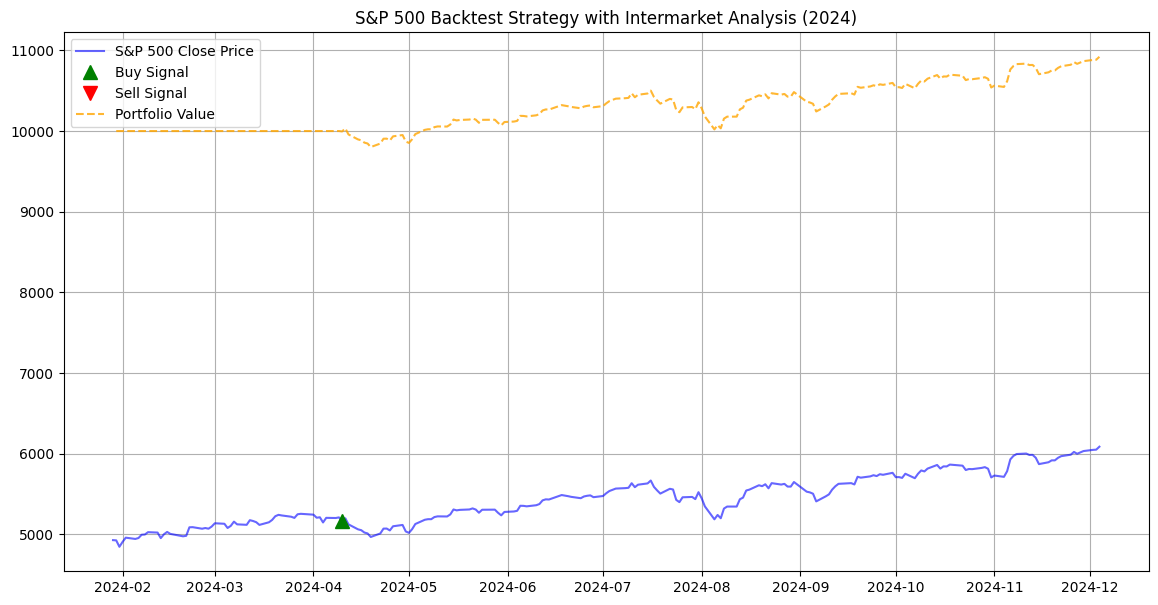

Final Portfolio Value: 10920.69
Total Return: 9.21%
Total Number of Trades: 1


In [128]:


# Step 2: Calculate a simple moving average as a proxy for MEM prediction
def RSMemPred(data, win):
    return data.rolling(window=win).mean()

# Step 3: Calculate oscillators for trend confirmation
def calculate_oscillator(data, length):
    return data['Close'] - data['Close'].rolling(window=length).mean()

# Step 4: Apply Intermarket Strategy Logic with backtesting
def apply_trading_logic_and_backtest(data_sp500_test, data_tbonds, TrLen, Win, LK1, LK2, initial_cash=10000, transaction_cost=0.001):
    # Calculate MEM predictions
    sp500_pred = RSMemPred(data_sp500_test['Close'], Win)
    tbonds_pred = RSMemPred(data_tbonds_test['Close'], Win)

    # Calculate oscillators for trend confirmation
    sp500_osc = calculate_oscillator(data_sp500_test, TrLen)
    tbonds_osc = calculate_oscillator(data_tbonds_test, TrLen)

    # Initialize variables for backtest
    signals = np.zeros(len(data_sp500_test))  # Default to no signal (0)
    portfolio_value = initial_cash  # Starting portfolio value
    position = 0  # 1 means long position, -1 means short position, 0 means no position
    cash = initial_cash  # Available cash
    shares_held = 0  # Number of shares held in S&P 500
    portfolio_values = []  # List to store portfolio value over time
    total_trades = 0  # Initialize counter for total trades

    # Apply trading logic and track portfolio performance
    for i in range(1, len(data_sp500_test)):
        # Buy condition: T-Bonds in uptrend, S&P in downtrend, both MEM predictions positive
        if tbonds_osc[i] > 0 and sp500_osc[i] < 0 and tbonds_pred[i] > 0 and sp500_pred[i] > 0 and position == 0:
            signals[i] = 1  # Buy S&P 500
            # Buying S&P 500 shares with available cash
            position = 1  # Long position
            shares_held = cash // data_sp500_test['Close'][i]  # Calculate number of shares we can buy
            cash -= shares_held * data_sp500_test['Close'][i] * (1 + transaction_cost)  # Deduct cash for purchase
            total_trades += 1  # Increment trade count

        # Sell condition: T-Bonds in downtrend, S&P in uptrend, both MEM predictions negative
        elif tbonds_osc[i] < 0 and sp500_osc[i] > 0 and tbonds_pred[i] < 0 and sp500_pred[i] < 0 and position == 0:
            signals[i] = -1  # Sell S&P 500
            # Selling S&P 500 shares
            position = -1  # Short position
            shares_held = cash // data_sp500_test['Close'][i]  # Calculate number of shares we can short
            cash += shares_held * data_sp500_test['Close'][i] * (1 - transaction_cost)  # Cash from short sale
            total_trades += 1  # Increment trade count

        # Track portfolio value after each trading decision
        if position == 1:  # If we are in a long position
            portfolio_value = cash + shares_held * data_sp500_test['Close'][i]  # Value of position + remaining cash
        elif position == -1:  # If we are in a short position
            portfolio_value = cash + shares_held * (data_sp500_test['Close'][i] - data_sp500_test['Close'][i])  # Update based on short position
        else:  # No position
            portfolio_value = cash

        portfolio_values.append(portfolio_value)

    return portfolio_values, signals, total_trades

# Step 5: Run backtest and visualize performance
TrLen = 20  # Oscillator Length
Win = 30  # Window for MEM prediction
LK1 = 6  # Parameter for MEM prediction (can adjust)
LK2 = 6  # Parameter for MEM prediction (can adjust)

# Backtest strategy
portfolio_values, signals, total_trades = apply_trading_logic_and_backtest(data_sp500_test, data_tbonds, TrLen, Win, LK1, LK2)

# Step 6: Plotting the results of the backtest
plt.figure(figsize=(14, 7))
plt.plot(data_sp500_test['Close'], label='S&P 500 Close Price', color='blue', alpha=0.6)

# Plot Buy and Sell signals
plt.plot(data_sp500_test.index[signals == 1], data_sp500_test['Close'][signals == 1], '^', markersize=10, color='green', label='Buy Signal')
plt.plot(data_sp500_test.index[signals == -1], data_sp500_test['Close'][signals == -1], 'v', markersize=10, color='red', label='Sell Signal')

# Plot portfolio value
plt.plot(data_sp500_test.index[1:], portfolio_values, label='Portfolio Value', color='orange', linestyle='--', alpha=0.8)

# Customize plot
plt.title('S&P 500 Backtest Strategy with Intermarket Analysis (2024)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Calculate final portfolio value and performance metrics
final_value = portfolio_values[-1]
total_return = (final_value - 10000) / 10000  # Assuming initial portfolio value of 10000
print(f"Final Portfolio Value: {final_value:.2f}")
print(f"Total Return: {total_return * 100:.2f}%")
print(f"Total Number of Trades: {total_trades}")


# o build and backtest a strategy based on the ratio between two markets (T-Bonds and the S&P 500), where:

Buy when the ratio of T-Bonds to the S&P 500 is above its 28-day moving average.
Sell when the ratio is below its 28-day moving average.
We can break down the process into these steps:

Step-by-Step Process:
Download Market Data: Retrieve historical data for T-Bonds (e.g., 13-week T-Bills) and S&P 500 from Yahoo Finance.
Calculate the Ratio: Compute the ratio of T-Bonds to S&P 500.
Calculate the 28-Day Moving Average: Use a 28-day moving average to smooth the ratio.
Trading Signals:
Buy when the ratio is above its 28-day moving average.
Sell when the ratio is below its 28-day moving average.
Backtest the Strategy: Execute trades based on the buy and sell signals, and track portfolio performance.
Visualize the Results: Plot the ratio, moving average, and buy/sell signals. Also, visualize the performance of the strategy.

In [174]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Download the data (S&P 500 and T-Bonds) for the backtest period
start_date = '2023-01-28'
end_date = '2024-12-05'

# Download S&P 500 and T-Bonds data
data_sp500 = yf.download('^GSPC', start=start_date, end=end_date, interval='1d')
data_tbonds = yf.download('^IRX', start=start_date, end=end_date, interval='1d')  # 13-week T-Bills

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [175]:
data_sp500

Price         Adj Close        Close         High          Low         Open  \
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC        ^GSPC   
Date                                                                          
2023-01-30  4017.770020  4017.770020  4063.850098  4015.550049  4049.270020   
2023-01-31  4076.600098  4076.600098  4077.159912  4020.439941  4020.850098   
2023-02-01  4119.209961  4119.209961  4148.950195  4037.199951  4070.070068   
2023-02-02  4179.759766  4179.759766  4195.439941  4141.879883  4158.680176   
2023-02-03  4136.479980  4136.479980  4182.359863  4123.359863  4136.689941   
...                 ...          ...          ...          ...          ...   
2024-11-27  5998.740234  5998.740234  6020.160156  5984.870117  6014.109863   
2024-11-29  6032.379883  6032.379883  6044.169922  6003.979980  6003.979980   
2024-12-02  6047.149902  6047.149902  6053.580078  6035.330078  6040.109863   
2024-12-03  6049.879883  6049.879883  6052.069824  6033.390137  6042.970215   
2024-12-04  6086.490234  6086.490234  6089.839844  6061.060059  6069.390137   

Price           Volume  
Ticker           ^GSPC  
Date                    
2023-01-30  3802000000  
2023-01-31  4679320000  
2023-02-01  4856930000  
2023-02-02  5624360000  
2023-02-03  4694510000  
...                ...  
2024-11-27  3363340000  
2024-11-29  2444420000  
2024-12-02  4412470000  
2024-12-03  4095000000  
2024-12-04  4003390000  

[466 rows x 6 columns]

In [176]:
data_tbonds

Price      Adj Close  Close   High    Low   Open Volume
Ticker          ^IRX   ^IRX   ^IRX   ^IRX   ^IRX   ^IRX
Date                                                   
2023-01-30     4.535  4.535  4.545  4.535  4.545      0
2023-01-31     4.570  4.570  4.580  4.565  4.580      0
2023-02-01     4.520  4.520  4.560  4.500  4.560      0
2023-02-02     4.510  4.510  4.523  4.475  4.513      0
2023-02-03     4.523  4.523  4.530  4.455  4.498      0
...              ...    ...    ...    ...    ...    ...
2024-11-27     4.385  4.385  4.397  4.385  4.388      0
2024-11-29     4.373  4.373  4.388  4.368  4.385      0
2024-12-02     4.380  4.380  4.397  4.375  4.375      0
2024-12-03     4.357  4.357  4.368  4.353  4.365      0
2024-12-04     4.345  4.345  4.355  4.340  4.355      0

[466 rows x 6 columns]

In [177]:

# Clean data by flattening MultiIndex columns
data_sp500.columns = data_sp500.columns.droplevel(1)  # Flatten the MultiIndex columns for SPY
data_tbonds.columns = data_tbonds.columns.droplevel(1)  # Flatten the MultiIndex columns for TLT






# clean the data

data_sp500.dropna(inplace=True)
data_tbonds.dropna(inplace=True)

# Align data to the same index (dates)
data_sp500, data_tbonds = data_sp500.align(data_tbonds, join='inner')






In [178]:
data_sp500

Price         Adj Close        Close         High          Low         Open  \
Date                                                                          
2023-01-30  4017.770020  4017.770020  4063.850098  4015.550049  4049.270020   
2023-01-31  4076.600098  4076.600098  4077.159912  4020.439941  4020.850098   
2023-02-01  4119.209961  4119.209961  4148.950195  4037.199951  4070.070068   
2023-02-02  4179.759766  4179.759766  4195.439941  4141.879883  4158.680176   
2023-02-03  4136.479980  4136.479980  4182.359863  4123.359863  4136.689941   
...                 ...          ...          ...          ...          ...   
2024-11-27  5998.740234  5998.740234  6020.160156  5984.870117  6014.109863   
2024-11-29  6032.379883  6032.379883  6044.169922  6003.979980  6003.979980   
2024-12-02  6047.149902  6047.149902  6053.580078  6035.330078  6040.109863   
2024-12-03  6049.879883  6049.879883  6052.069824  6033.390137  6042.970215   
2024-12-04  6086.490234  6086.490234  6089.839844  6061.060059  6069.390137   

Price           Volume  
Date                    
2023-01-30  3802000000  
2023-01-31  4679320000  
2023-02-01  4856930000  
2023-02-02  5624360000  
2023-02-03  4694510000  
...                ...  
2024-11-27  3363340000  
2024-11-29  2444420000  
2024-12-02  4412470000  
2024-12-03  4095000000  
2024-12-04  4003390000  

[466 rows x 6 columns]

In [179]:
data_tbonds

Price       Adj Close  Close   High    Low   Open  Volume
Date                                                     
2023-01-30      4.535  4.535  4.545  4.535  4.545       0
2023-01-31      4.570  4.570  4.580  4.565  4.580       0
2023-02-01      4.520  4.520  4.560  4.500  4.560       0
2023-02-02      4.510  4.510  4.523  4.475  4.513       0
2023-02-03      4.523  4.523  4.530  4.455  4.498       0
...               ...    ...    ...    ...    ...     ...
2024-11-27      4.385  4.385  4.397  4.385  4.388       0
2024-11-29      4.373  4.373  4.388  4.368  4.385       0
2024-12-02      4.380  4.380  4.397  4.375  4.375       0
2024-12-03      4.357  4.357  4.368  4.353  4.365       0
2024-12-04      4.345  4.345  4.355  4.340  4.355       0

[466 rows x 6 columns]

<ipython-input-180-4cd2cbd5e287>:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data['Signal'][i] == 1 and cash > 0:
<ipython-input-180-4cd2cbd5e287>:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif data['Signal'][i] == -1 and shares_held > 0:
<ipython-input-180-4cd2cbd5e287>:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cash + shares_held * data_sp500['Close'][i]
<ipython-input-180-4cd2cbd5e287>:29

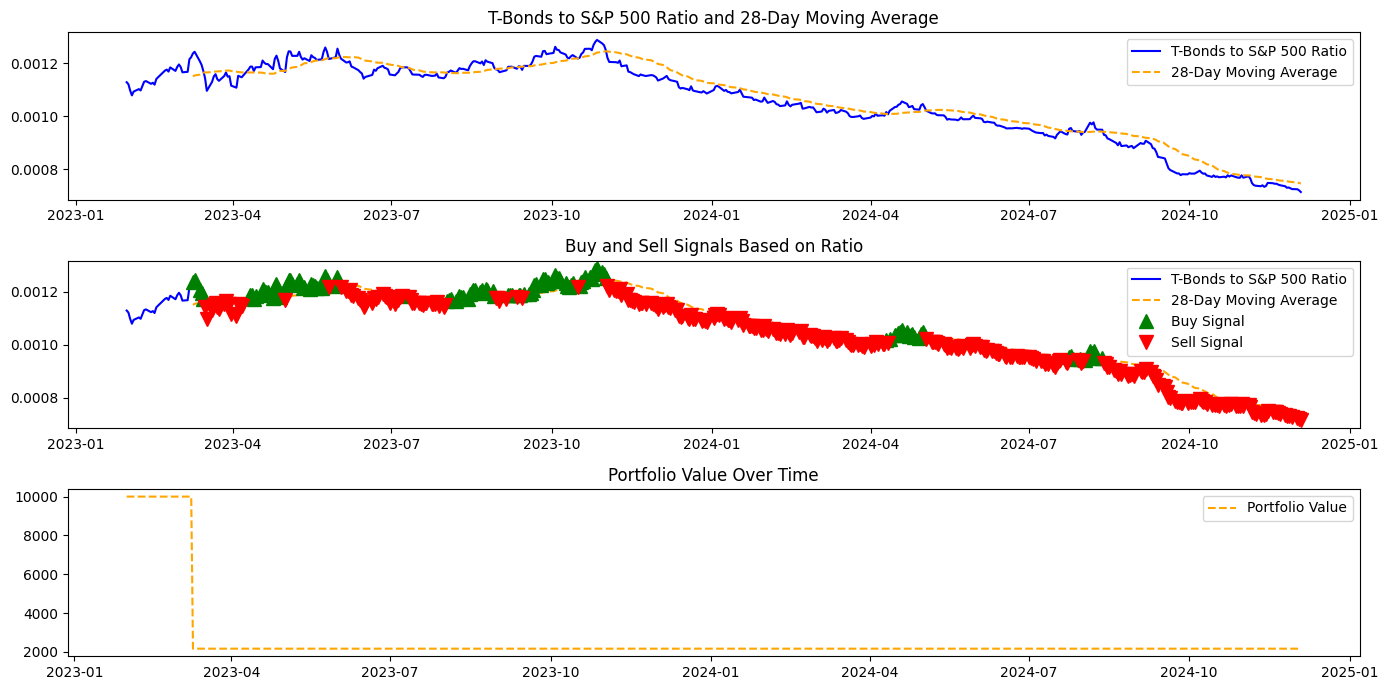

Final Portfolio Value: 2163.36
Total Return: -78.37%


In [180]:


# Step 2: Calculate the ratio of T-Bonds to S&P 500
data = pd.DataFrame({
    'SP500': data_sp500['Close'],
    'TBonds': data_tbonds['Close']
})

# Calculate the ratio: T-Bonds to S&P 500
data['Ratio'] = data['TBonds'] / data['SP500']

# Step 3: Calculate the 28-day moving average of the ratio
data['Ratio_MA'] = data['Ratio'].rolling(window=28).mean()

# Step 4: Define trading signals based on the ratio
data['Signal'] = np.where(data['Ratio'] > data['Ratio_MA'], 1, 0)  # Buy when ratio > moving average
data['Signal'] = np.where(data['Ratio'] < data['Ratio_MA'], -1, data['Signal'])  # Sell when ratio < moving average

# Step 5: Backtest the strategy
initial_cash = 10000  # Starting cash for the backtest
cash = initial_cash
shares_held = 0  # Number of shares held in S&P 500
portfolio_value = initial_cash  # Portfolio value
portfolio_values = []  # To store portfolio value over time

# Loop through each day and simulate buying/selling
for i in range(1, len(data)):
    # Buy condition: Signal is 1
    if data['Signal'][i] == 1 and cash > 0:
        # Buy S&P 500 with available cash
        shares_held = cash // data_sp500['Close'][i]
        cash -= shares_held * data_sp500['Close'][i]
    # Sell condition: Signal is -1
    elif data['Signal'][i] == -1 and shares_held > 0:
        # Sell all S&P 500 shares
        cash += shares_held * data_sp500['Close'][i]
        shares_held = 0

    # Track portfolio value
    portfolio_value = cash + shares_held * data_sp500['Close'][i]
    portfolio_values.append(portfolio_value)

# Step 6: Plot the results

plt.figure(figsize=(14, 7))

# Plot S&P 500 and T-Bonds ratio
plt.subplot(3, 1, 1)
plt.plot(data['Ratio'], label='T-Bonds to S&P 500 Ratio', color='blue')
plt.plot(data['Ratio_MA'], label='28-Day Moving Average', color='orange', linestyle='--')
plt.title('T-Bonds to S&P 500 Ratio and 28-Day Moving Average')
plt.legend(loc='best')

# Plot Buy and Sell signals
plt.subplot(3, 1, 2)
plt.plot(data['Ratio'], label='T-Bonds to S&P 500 Ratio', color='blue')
plt.plot(data['Ratio_MA'], label='28-Day Moving Average', color='orange', linestyle='--')
plt.plot(data.index[data['Signal'] == 1], data['Ratio'][data['Signal'] == 1], '^', markersize=10, color='green', label='Buy Signal')
plt.plot(data.index[data['Signal'] == -1], data['Ratio'][data['Signal'] == -1], 'v', markersize=10, color='red', label='Sell Signal')
plt.title('Buy and Sell Signals Based on Ratio')
plt.legend(loc='best')

# Plot Portfolio Value
plt.subplot(3, 1, 3)
plt.plot(data.index[1:], portfolio_values, label='Portfolio Value', color='orange', linestyle='--')
plt.title('Portfolio Value Over Time')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# Final portfolio value and performance
final_value = portfolio_values[-1]
total_return = (final_value - initial_cash) / initial_cash  # Assuming initial portfolio value of 10000
print(f"Final Portfolio Value: {final_value:.2f}")
print(f"Total Return: {total_return * 100:.2f}%")


# Adding more indicators

In [181]:
!pip install pandas_ta

<ipython-input-182-e647776d1130>:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data['Signal'][i] == 1 and cash > 0:
<ipython-input-182-e647776d1130>:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif data['Signal'][i] == -1 and shares_held > 0:
<ipython-input-182-e647776d1130>:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cash + shares_held * data_sp500['Close'][i]


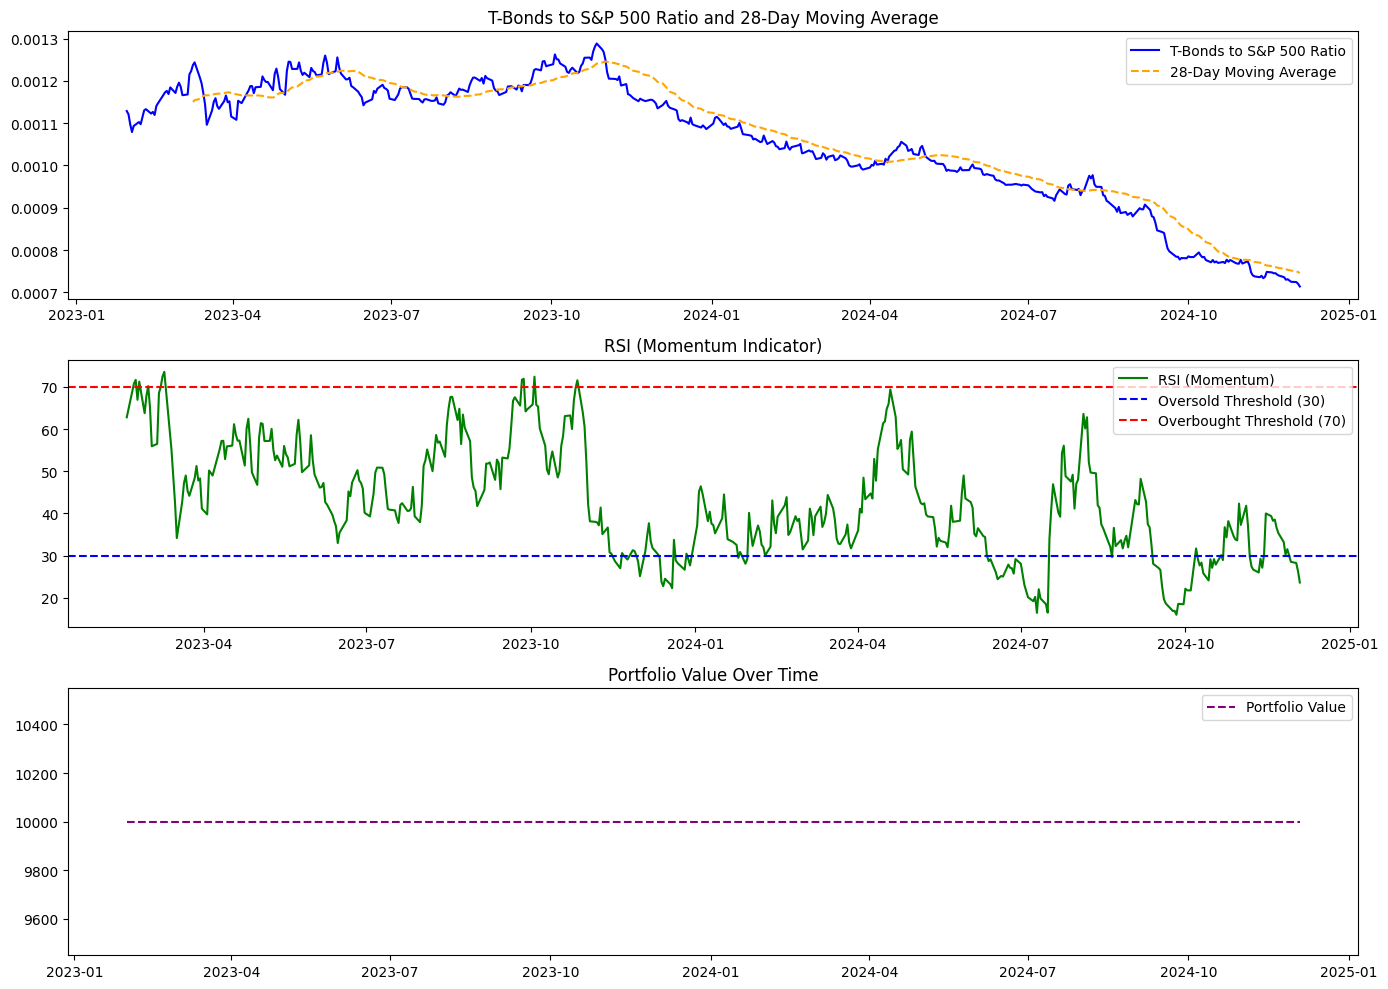

Final Portfolio Value: 10000.00
Total Return: 0.00%


In [182]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt


# Step 2: Calculate the ratio of T-Bonds to S&P 500
data = pd.DataFrame({
    'SP500': data_sp500['Close'],
    'TBonds': data_tbonds['Close']
})

# Calculate the ratio: T-Bonds to S&P 500
data['Ratio'] = data['TBonds'] / data['SP500']

# Step 3: Calculate the 28-day moving average of the ratio
data['Ratio_MA'] = data['Ratio'].rolling(window=28).mean()

# Step 4: Add momentum (RSI) and volatility (ATR) indicators using pandas_ta
rsi_period = 14
atr_period = 24

# Calculate RSI for the ratio
data['RSI'] = data.ta.rsi(close=data['Ratio'], length=rsi_period)

# Calculate ATR for the ratio
# Note: For ATR, we need High, Low, and Close. Using 'Ratio' for all three as a simplification.
data['ATR'] = data.ta.atr(high=data['Ratio'], low=data['Ratio'], close=data['Ratio'], length=atr_period)

# Step 5: Define trading signals with filters
volatility_threshold = 0.02 * data['Ratio'].mean()  # Threshold for ATR (2% of ratio's mean)

data['Signal'] = 0  # Initialize signals
data.loc[(data['Ratio'] > data['Ratio_MA']) & (data['RSI'] < 30) & (data['ATR'] < volatility_threshold), 'Signal'] = 1  # Buy
data.loc[(data['Ratio'] < data['Ratio_MA']) & (data['RSI'] > 70) & (data['ATR'] < volatility_threshold), 'Signal'] = -1  # Sell

# Step 6: Backtest the enhanced strategy
initial_cash = 10000  # Starting cash for the backtest
cash = initial_cash
shares_held = 0  # Number of shares held in S&P 500
portfolio_value = initial_cash  # Portfolio value
portfolio_values = []  # To store portfolio value over time

for i in range(1, len(data)):
    # Buy condition: Signal is 1
    if data['Signal'][i] == 1 and cash > 0:
        shares_held = cash // data_sp500['Close'][i]  # Buy S&P 500 with available cash
        cash -= shares_held * data_sp500['Close'][i]
    # Sell condition: Signal is -1
    elif data['Signal'][i] == -1 and shares_held > 0:
        cash += shares_held * data_sp500['Close'][i]  # Sell all S&P 500 shares
        shares_held = 0
    # Track portfolio value
    portfolio_value = cash + shares_held * data_sp500['Close'][i]
    portfolio_values.append(portfolio_value)

# Step 7: Plot results
plt.figure(figsize=(14, 10))

# Ratio and Moving Average
plt.subplot(3, 1, 1)
plt.plot(data['Ratio'], label='T-Bonds to S&P 500 Ratio', color='blue')
plt.plot(data['Ratio_MA'], label='28-Day Moving Average', color='orange', linestyle='--')
plt.title('T-Bonds to S&P 500 Ratio and 28-Day Moving Average')
plt.legend(loc='best')

# RSI
plt.subplot(3, 1, 2)
plt.plot(data['RSI'], label='RSI (Momentum)', color='green')
plt.axhline(30, color='blue', linestyle='--', label='Oversold Threshold (30)')
plt.axhline(70, color='red', linestyle='--', label='Overbought Threshold (70)')
plt.title('RSI (Momentum Indicator)')
plt.legend(loc='best')

# Portfolio Value
plt.subplot(3, 1, 3)
plt.plot(data.index[1:], portfolio_values, label='Portfolio Value', color='purple', linestyle='--')
plt.title('Portfolio Value Over Time')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# Final Portfolio Value
final_value = portfolio_values[-1]
total_return = (final_value - initial_cash) / initial_cash
print(f"Final Portfolio Value: {final_value:.2f}")
print(f"Total Return: {total_return * 100:.2f}%")


# 3 and 20 SMA crossover

<ipython-input-183-93f1d403baf4>:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data['Signal'][i] == 1 and cash > 0:
<ipython-input-183-93f1d403baf4>:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif data['Signal'][i] == -1 and shares_held > 0:
<ipython-input-183-93f1d403baf4>:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cash + shares_held * data_sp500['Close'][i]
<ipython-input-183-93f1d403baf4>:29

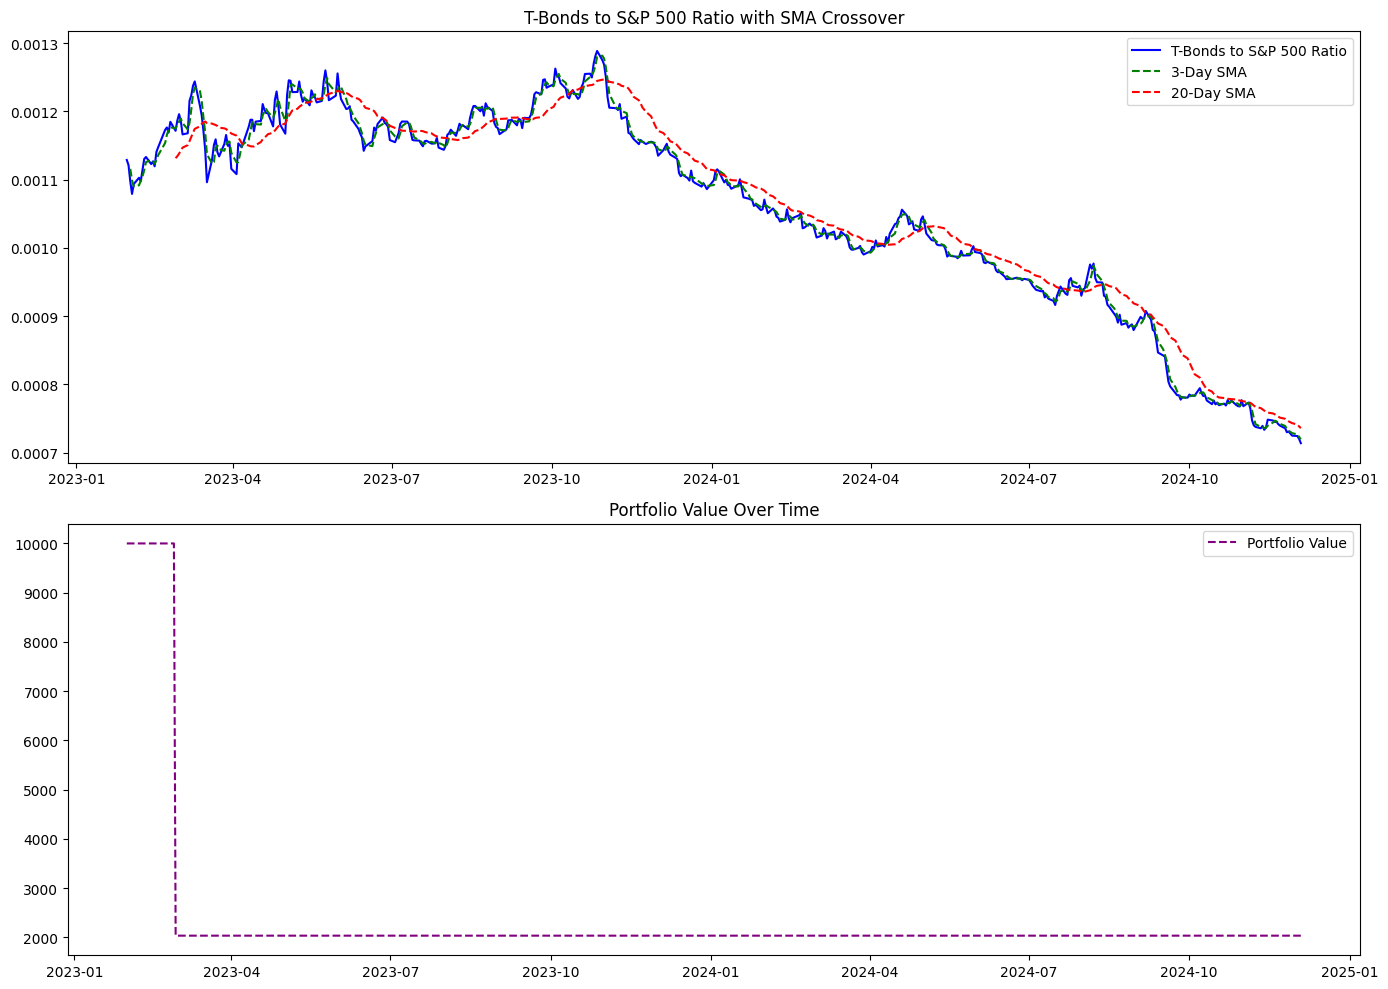

Final Portfolio Value: 2035.52
Total Return: -79.64%


In [183]:


# Step 2: Calculate the ratio of T-Bonds to S&P 500
data = pd.DataFrame({
    'SP500': data_sp500['Close'],
    'TBonds': data_tbonds['Close']
})

# Calculate the ratio: T-Bonds to S&P 500
data['Ratio'] = data['TBonds'] / data['SP500']

# Step 3: Calculate the 3-day and 20-day SMAs for the ratio
data['SMA_3'] = data['Ratio'].rolling(window=3).mean()
data['SMA_20'] = data['Ratio'].rolling(window=20).mean()

# Step 4: Define trading signals based on SMA crossover
data['Signal'] = 0  # Initialize signals
data.loc[data['SMA_3'] > data['SMA_20'], 'Signal'] = 1  # Buy
data.loc[data['SMA_3'] < data['SMA_20'], 'Signal'] = -1  # Sell

# Step 5: Backtest the SMA crossover strategy
initial_cash = 10000  # Starting cash for the backtest
cash = initial_cash
shares_held = 0  # Number of shares held in S&P 500
portfolio_value = initial_cash  # Portfolio value
portfolio_values = []  # To store portfolio value over time

for i in range(1, len(data)):
    # Buy condition: Signal is 1
    if data['Signal'][i] == 1 and cash > 0:
        shares_held = cash // data_sp500['Close'][i]  # Buy S&P 500 with available cash
        cash -= shares_held * data_sp500['Close'][i]
    # Sell condition: Signal is -1
    elif data['Signal'][i] == -1 and shares_held > 0:
        cash += shares_held * data_sp500['Close'][i]  # Sell all S&P 500 shares
        shares_held = 0
    # Track portfolio value
    portfolio_value = cash + shares_held * data_sp500['Close'][i]
    portfolio_values.append(portfolio_value)

# Step 6: Plot results
plt.figure(figsize=(14, 10))

# Ratio and SMAs
plt.subplot(2, 1, 1)
plt.plot(data['Ratio'], label='T-Bonds to S&P 500 Ratio', color='blue')
plt.plot(data['SMA_3'], label='3-Day SMA', color='green', linestyle='--')
plt.plot(data['SMA_20'], label='20-Day SMA', color='red', linestyle='--')
plt.title('T-Bonds to S&P 500 Ratio with SMA Crossover')
plt.legend(loc='best')

# Portfolio Value
plt.subplot(2, 1, 2)
plt.plot(data.index[1:], portfolio_values, label='Portfolio Value', color='purple', linestyle='--')
plt.title('Portfolio Value Over Time')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# Final Portfolio Value
final_value = portfolio_values[-1]
total_return = (final_value - initial_cash) / initial_cash
print(f"Final Portfolio Value: {final_value:.2f}")
print(f"Total Return: {total_return * 100:.2f}%")


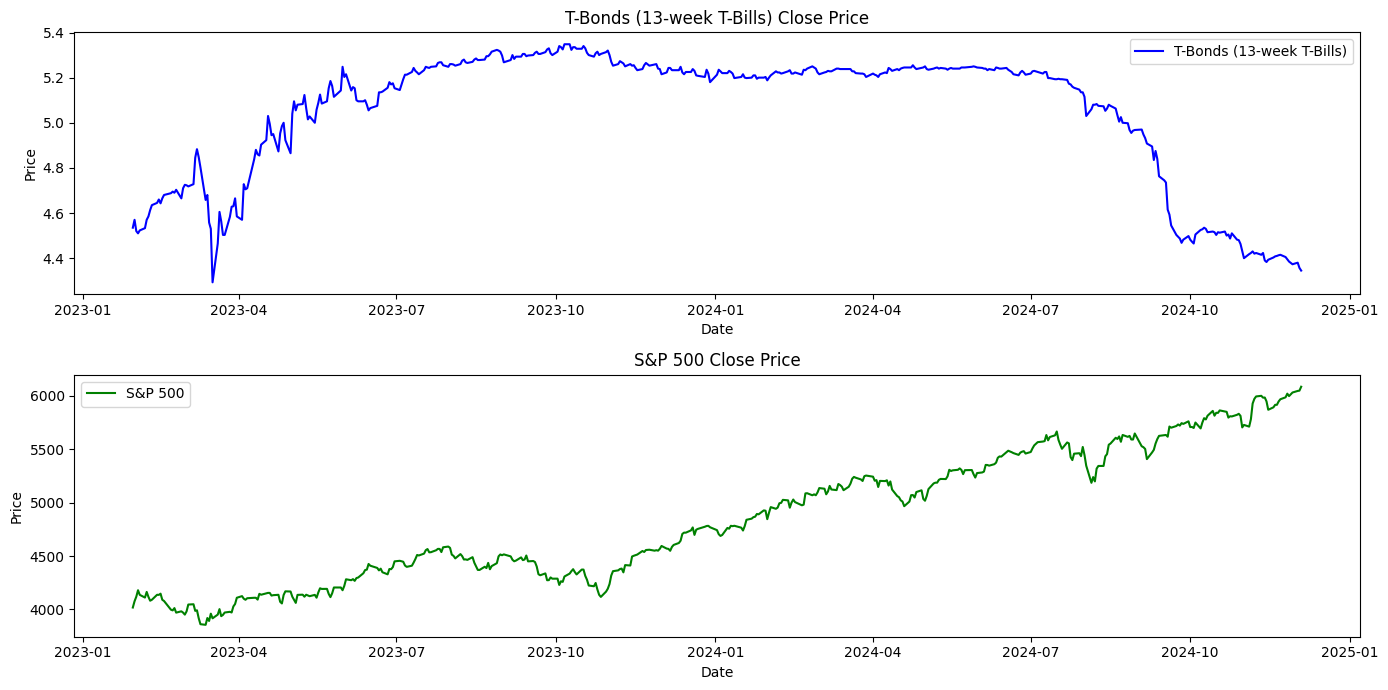

In [156]:
# Step 5: Plot T-Bonds and S&P 500 Close Prices separately

plt.figure(figsize=(14, 7))

# Plot T-Bonds Close Price
plt.subplot(2, 1, 1)
plt.plot(data_tbonds['Close'], label='T-Bonds (13-week T-Bills)', color='blue')
plt.title('T-Bonds (13-week T-Bills) Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')

# Plot S&P 500 Close Price
plt.subplot(2, 1, 2)
plt.plot(data_sp500['Close'], label='S&P 500', color='green')
plt.title('S&P 500 Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# Let's now look at how we can use the relationship between Eurodollars and the S&P500, employing the ratio of Eurodollars/S&P500. We would have been bullish when the ratio was above its 10-day moving average, and bearish when it was below.

In [191]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Download the data (S&P 500 and Eurodollars) for the backtest period
start_date = '2024-01-28'
end_date = '2024-12-05'

# Download S&P 500 and Eurodollars data
data_sp500 = yf.download('^GSPC', start=start_date, end=end_date, interval='1d')
data_eurodollars = yf.download('EURUSD=X', start=start_date, end=end_date, interval='1d')  # Eurodollars Futures


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [192]:
data_sp500

Price         Adj Close        Close         High          Low         Open  \
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC        ^GSPC   
Date                                                                          
2024-01-29  4927.930176  4927.930176  4929.310059  4887.399902  4892.950195   
2024-01-30  4924.970215  4924.970215  4931.089844  4916.270020  4925.890137   
2024-01-31  4845.649902  4845.649902  4906.750000  4845.149902  4899.189941   
2024-02-01  4906.189941  4906.189941  4906.970215  4853.520020  4861.109863   
2024-02-02  4958.609863  4958.609863  4975.290039  4907.990234  4916.060059   
...                 ...          ...          ...          ...          ...   
2024-11-27  5998.740234  5998.740234  6020.160156  5984.870117  6014.109863   
2024-11-29  6032.379883  6032.379883  6044.169922  6003.979980  6003.979980   
2024-12-02  6047.149902  6047.149902  6053.580078  6035.330078  6040.109863   
2024-12-03  6049.879883  6049.879883  6052.069824  6033.390137  6042.970215   
2024-12-04  6086.490234  6086.490234  6089.839844  6061.060059  6069.390137   

Price           Volume  
Ticker           ^GSPC  
Date                    
2024-01-29  3525160000  
2024-01-30  3836130000  
2024-01-31  4696120000  
2024-02-01  4386090000  
2024-02-02  3974350000  
...                ...  
2024-11-27  3363340000  
2024-11-29  2444420000  
2024-12-02  4412470000  
2024-12-03  4095000000  
2024-12-04  4003390000  

[216 rows x 6 columns]

In [193]:
data_eurodollars

Price      Adj Close     Close      High       Low      Open   Volume
Ticker      EURUSD=X  EURUSD=X  EURUSD=X  EURUSD=X  EURUSD=X EURUSD=X
Date                                                                 
2024-01-29  1.084352  1.084352  1.084975  1.079715  1.084352        0
2024-01-30  1.083447  1.083447  1.085564  1.081268  1.083447        0
2024-01-31  1.084340  1.084340  1.088566  1.080766  1.084340        0
2024-02-01  1.080392  1.080392  1.086555  1.078028  1.080392        0
2024-02-02  1.087465  1.087465  1.089800  1.078307  1.087465        0
...              ...       ...       ...       ...       ...      ...
2024-11-28  1.056245  1.056245  1.056524  1.052920  1.056245        0
2024-11-29  1.056301  1.056301  1.059547  1.054296  1.056301        0
2024-12-02  1.054507  1.054507  1.054574  1.046222  1.054574        0
2024-12-03  1.050122  1.050122  1.053031  1.048185  1.050122        0
2024-12-04  1.051083  1.051083  1.054007  1.047395  1.051083        0

[223 rows x 6 columns]

In [196]:

# Clean data by flattening MultiIndex columns
data_sp500.columns = data_sp500.columns.droplevel(1)  # Flatten the MultiIndex columns for SPY
data_eurodollars.columns = data_eurodollars.columns.droplevel(1)  # Flatten the MultiIndex columns for TLT






# clean the data

data_sp500.dropna(inplace=True)
data_eurodollars.dropna(inplace=True)

# Align data to the same index (dates)
data_sp500, data_eurodollars = data_sp500.align(data_eurodollars, join='inner')






IndexError: Too many levels: Index has only 1 level, not 2

<ipython-input-195-fe0e9a50b215>:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data['Signal'][i] == 1 and cash > 0:
<ipython-input-195-fe0e9a50b215>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif data['Signal'][i] == -1 and shares_held > 0:
<ipython-input-195-fe0e9a50b215>:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = cash + shares_held * data_sp500['Close'][i]
<ipython-input-195-fe0e9a50b215>:28

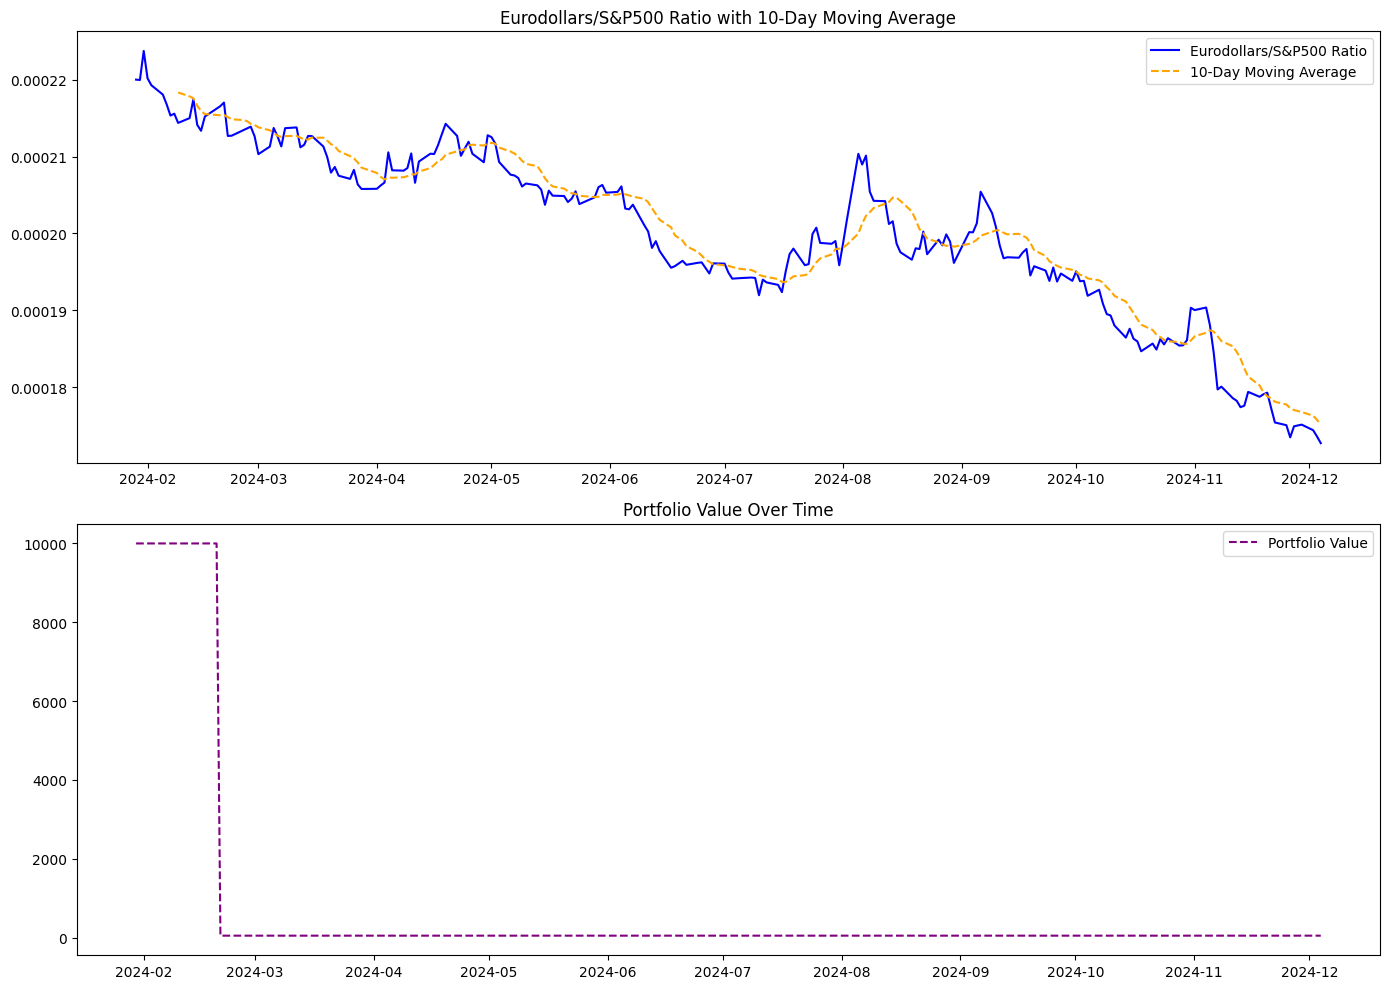

Final Portfolio Value: 48.98
Total Return: -99.51%


In [195]:

# Step 2: Calculate the ratio of Eurodollars to S&P 500
data = pd.DataFrame({
    'SP500': data_sp500['Close'],
    'Eurodollars': data_eurodollars['Close']
})

# Calculate the ratio: Eurodollars/S&P 500
data['Ratio'] = data['Eurodollars'] / data['SP500']

# Step 3: Calculate the 10-day moving average of the ratio
data['Ratio_MA_10'] = data['Ratio'].rolling(window=10).mean()

# Step 4: Define trading signals based on the ratio crossing its 10-day moving average
data['Signal'] = 0  # Initialize signals
data.loc[data['Ratio'] > data['Ratio_MA_10'], 'Signal'] = 1  # Buy
data.loc[data['Ratio'] < data['Ratio_MA_10'], 'Signal'] = -1  # Sell

# Step 5: Backtest the strategy
initial_cash = 10000  # Starting cash for the backtest
cash = initial_cash
shares_held = 0  # Number of shares held in S&P 500
portfolio_value = initial_cash  # Portfolio value
portfolio_values = []  # To store portfolio value over time

for i in range(1, len(data)):
    # Buy condition: Signal is 1
    if data['Signal'][i] == 1 and cash > 0:
        shares_held = cash // data_sp500['Close'][i]  # Buy S&P 500 with available cash
        cash -= shares_held * data_sp500['Close'][i]
    # Sell condition: Signal is -1
    elif data['Signal'][i] == -1 and shares_held > 0:
        cash += shares_held * data_sp500['Close'][i]  # Sell all S&P 500 shares
        shares_held = 0
    # Track portfolio value
    portfolio_value = cash + shares_held * data_sp500['Close'][i]
    portfolio_values.append(portfolio_value)

# Step 6: Plot results
plt.figure(figsize=(14, 10))

# Ratio and 10-Day Moving Average
plt.subplot(2, 1, 1)
plt.plot(data['Ratio'], label='Eurodollars/S&P500 Ratio', color='blue')
plt.plot(data['Ratio_MA_10'], label='10-Day Moving Average', color='orange', linestyle='--')
plt.title('Eurodollars/S&P500 Ratio with 10-Day Moving Average')
plt.legend(loc='best')

# Portfolio Value
plt.subplot(2, 1, 2)
plt.plot(data.index[1:], portfolio_values, label='Portfolio Value', color='purple', linestyle='--')
plt.title('Portfolio Value Over Time')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# Final Portfolio Value
final_value = portfolio_values[-1]
total_return = (final_value - initial_cash) / initial_cash
print(f"Final Portfolio Value: {final_value:.2f}")
print(f"Total Return: {total_return * 100:.2f}%")


# please let do this 'used to give us a statistical edge in the bond market? Using the Philadelphia Utilities average as an example, we will buy T-Bonds when this average crosses above its moving average and sell when it crosses below. By using these simple rules, a 40-day simple moving average works best



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-197-a6f6838606ec>:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data['Signal'][i] == 1 and cash > 0:
<ipython-input-197-a6f6838606ec>:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif data['Signal'][i] == -1 and tbonds_held > 0:
<ipython-input-197-a6f6838606ec>:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a 

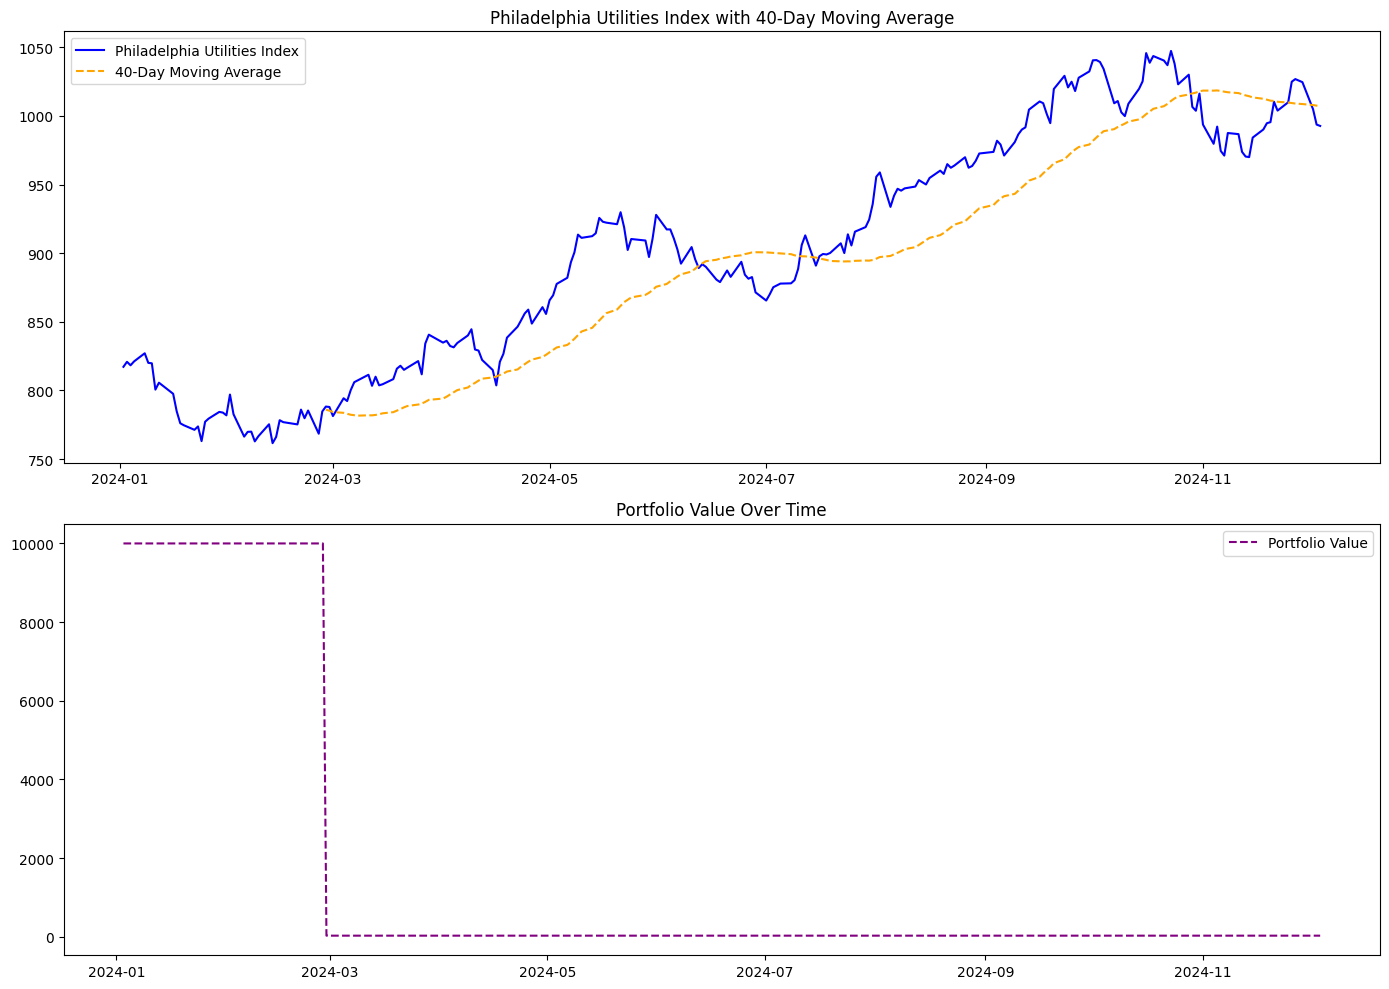

Final Portfolio Value: 25.00
Total Return: -99.75%


In [197]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Download the data for T-Bonds and Philadelphia Utilities Index
start_date = '2024-01-01'
end_date = '2024-12-05'

# Download T-Bonds (using 30-Year T-Bond Futures) and Philadelphia Utilities Index
data_tbonds = yf.download('ZB=F', start=start_date, end=end_date, interval='1d')  # 30-Year T-Bond Futures
data_utils = yf.download('^UTY', start=start_date, end=end_date, interval='1d')  # Philadelphia Utilities Index





# Clean data by flattening MultiIndex columns
data_tbonds.columns = data_tbonds.columns.droplevel(1)  # Flatten the MultiIndex columns for SPY
data_utils.columns = data_utils.columns.droplevel(1)  # Flatten the MultiIndex columns for TLT






# clean the data

data_tbonds.dropna(inplace=True)
data_utils.dropna(inplace=True)

# Align data to the same index (dates)
data_tbonds, data_utils = data_tbonds.align(data_utils, join='inner')

# Step 2: Prepare the data
data = pd.DataFrame({
    'TBonds': data_tbonds['Close'],
    'Utilities': data_utils['Close']
})

# Calculate the 40-day moving average of the Philadelphia Utilities Index
data['Utilities_MA_40'] = data['Utilities'].rolling(window=40).mean()

# Step 3: Define trading signals
data['Signal'] = 0  # Initialize signals
data.loc[data['Utilities'] > data['Utilities_MA_40'], 'Signal'] = 1  # Buy Signal
data.loc[data['Utilities'] < data['Utilities_MA_40'], 'Signal'] = -1  # Sell Signal

# Step 4: Backtest the strategy
initial_cash = 10000  # Starting cash for the backtest
cash = initial_cash
tbonds_held = 0  # Number of T-Bond units held
portfolio_value = initial_cash  # Portfolio value
portfolio_values = []  # To store portfolio value over time

for i in range(1, len(data)):
    # Buy condition: Signal is 1
    if data['Signal'][i] == 1 and cash > 0:
        tbonds_held = cash // data_tbonds['Close'][i]  # Buy T-Bonds with available cash
        cash -= tbonds_held * data_tbonds['Close'][i]
    # Sell condition: Signal is -1
    elif data['Signal'][i] == -1 and tbonds_held > 0:
        cash += tbonds_held * data_tbonds['Close'][i]  # Sell all T-Bonds
        tbonds_held = 0
    # Track portfolio value
    portfolio_value = cash + tbonds_held * data_tbonds['Close'][i]
    portfolio_values.append(portfolio_value)

# Step 5: Plot results
plt.figure(figsize=(14, 10))

# Utilities Index and Moving Average
plt.subplot(2, 1, 1)
plt.plot(data['Utilities'], label='Philadelphia Utilities Index', color='blue')
plt.plot(data['Utilities_MA_40'], label='40-Day Moving Average', color='orange', linestyle='--')
plt.title('Philadelphia Utilities Index with 40-Day Moving Average')
plt.legend(loc='best')

# Portfolio Value
plt.subplot(2, 1, 2)
plt.plot(data.index[1:], portfolio_values, label='Portfolio Value', color='purple', linestyle='--')
plt.title('Portfolio Value Over Time')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# Final Portfolio Value
final_value = portfolio_values[-1]
total_return = (final_value - initial_cash) / initial_cash
print(f"Final Portfolio Value: {final_value:.2f}")
print(f"Total Return: {total_return * 100:.2f}%")


# can we do this 'Divergence is a valuable concept in developing trading systems. Combining divergence and intermarket analysis, we define intermarket divergence as the traded market moving in an opposite direction to what was expected. If we trade the S&P500, for example, T-Bonds rising and the S&P500 falling would be divergence. On the other hand, if we trade T-Bonds, gold rising and T-Bonds rising would also be defined as divergence because these two markets should be negatively correlated.'

In [ ]:

# Download T-Bonds (using 30-Year T-Bond Futures) and Philadelphia Utilities Index
data_tbonds = yf.download('ZB=F', start=start_date, end=end_date, interval='1d')  # 30-Year T-Bond Futures
data_utils = yf.download('^UTY', start=start_date, end=end_date, interval='1d')  # Philadelphia Utilities Index





# Clean data by flattening MultiIndex columns
data_tbonds.columns = data_tbonds.columns.droplevel(1)  # Flatten the MultiIndex columns for SPY
data_utils.columns = data_utils.columns.droplevel(1)  # Flatten the MultiIndex columns for TLT






# clean the data

data_tbonds.dropna(inplace=True)
data_utils.dropna(inplace=True)

# Align data to the same index (dates)
data_tbonds, data_utils = data_tbonds.align(data_utils, join='inner')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-200-cf4609fd6615>:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data['SP500_Buy_Signal'][i] and cash_sp500 > 0:
<ipython-input-200-cf4609fd6615>:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif data['SP500_Sell_Signal'][i] and shares_sp500 > 0:
<ipython-input-200-cf4609fd6615>:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer ke

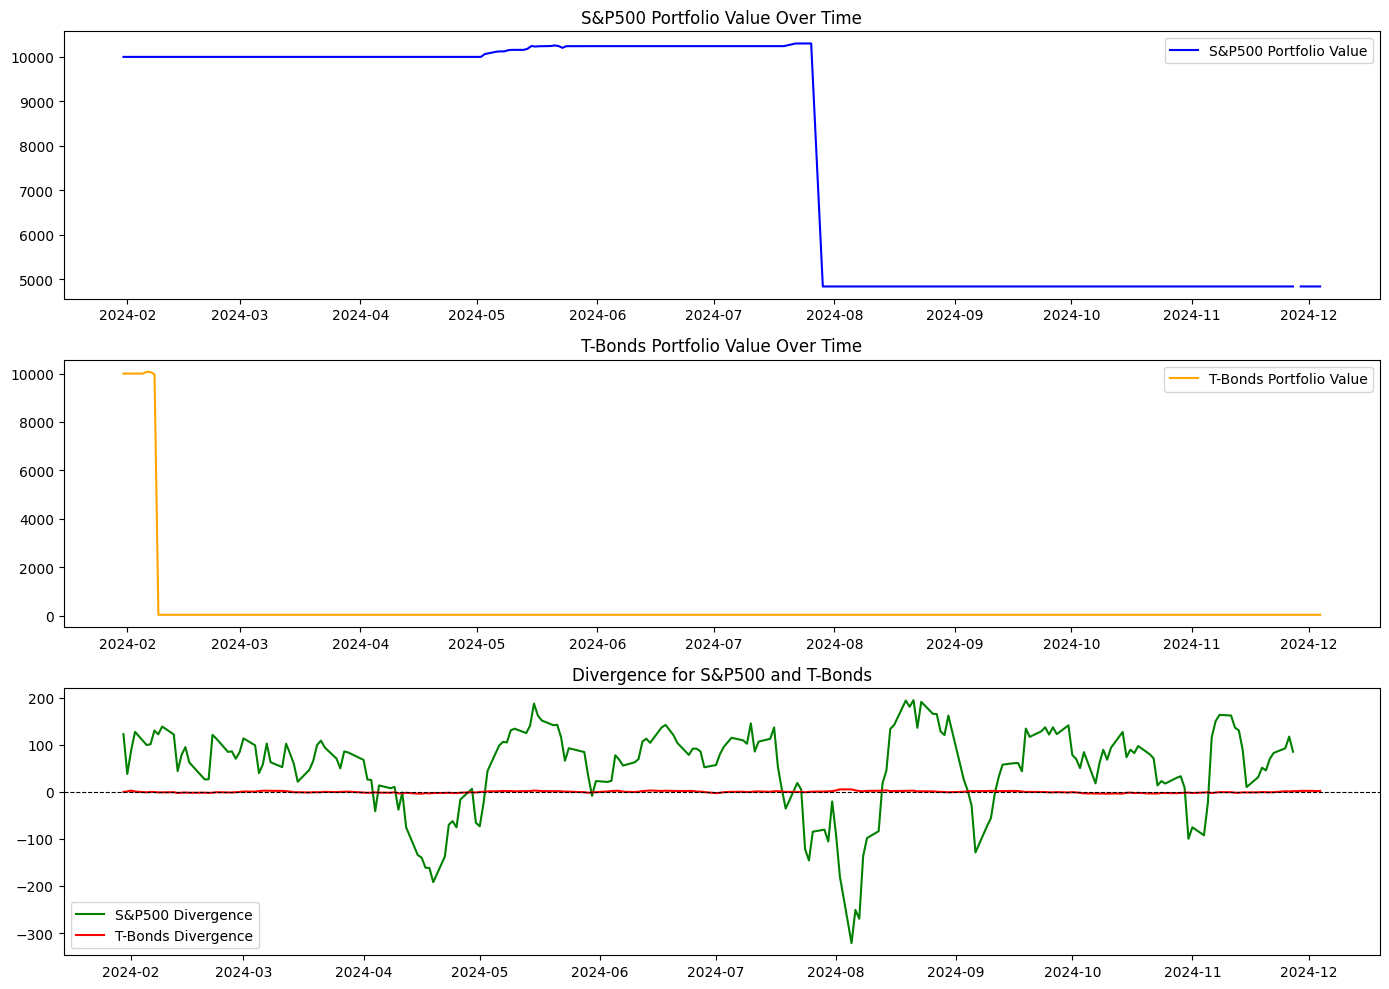

S&P500 Final Portfolio Value: 4842.15
S&P500 Total Return: -51.58%
T-Bonds Final Portfolio Value: 29.62
T-Bonds Total Return: -99.70%


In [200]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Download the data
start_date = '2024-01-01'
end_date = '2024-12-05'

# Download data for S&P500, T-Bonds, and Gold
data_sp500 = yf.download('^GSPC', start=start_date, end=end_date, interval='1d')  # S&P500
data_tbonds = yf.download('ZB=F', start=start_date, end=end_date, interval='1d')  # 30-Year T-Bonds
data_gold = yf.download('GC=F', start=start_date, end=end_date, interval='1d')  # Gold Futures



# Clean data by flattening MultiIndex columns
data_sp500.columns = data_sp500.columns.droplevel(1)  # Flatten the MultiIndex columns for S&P
data_tbonds.columns = data_tbonds.columns.droplevel(1)  # Flatten the MultiIndex columns for T-Bonds
data_gold.columns = data_gold.columns.droplevel(1)  # Flatten the MultiIndex columns for Gold



# clean the data
data_sp500.dropna(inplace=True)
data_tbonds.dropna(inplace=True)
data_gold.dropna(inplace=True)

# Align data to the same index (dates)
# data_sp500, data_tbonds, data_gold = data_sp500.align(data_tbonds, join='inner'), data_tbonds.align(data_gold, join='inner')













# Combine the data into one DataFrame
data = pd.DataFrame({
    'SP500': data_sp500['Close'],
    'TBonds': data_tbonds['Close'],
    'Gold': data_gold['Close']
})

# Step 2: Calculate oscillators (SMA) and divergence
sma_period = 20
data['SP500_SMA'] = data['SP500'].rolling(window=sma_period).mean()
data['TBonds_SMA'] = data['TBonds'].rolling(window=sma_period).mean()

# Divergence calculation
data['SP500_Divergence'] = data['SP500'] - data['SP500_SMA']
data['TBonds_Divergence'] = data['TBonds'] - data['TBonds_SMA']

# Step 3: Define divergence conditions
# Divergence signals for S&P500 (based on T-Bonds)
data['SP500_Buy_Signal'] = (data['TBonds'] > data['TBonds_SMA']) & (data['SP500_Divergence'] < 0)
data['SP500_Sell_Signal'] = (data['TBonds'] < data['TBonds_SMA']) & (data['SP500_Divergence'] > 0)

# Divergence signals for T-Bonds (based on Gold)
data['TBonds_Buy_Signal'] = (data['Gold'] < data['Gold'].rolling(window=sma_period).mean()) & (data['TBonds_Divergence'] < 0)
data['TBonds_Sell_Signal'] = (data['Gold'] > data['Gold'].rolling(window=sma_period).mean()) & (data['TBonds_Divergence'] > 0)

# Step 4: Backtest the strategy
initial_cash = 10000
portfolio_values_sp500 = []
portfolio_values_tbonds = []

# S&P500 Portfolio
cash_sp500 = initial_cash
shares_sp500 = 0

# T-Bonds Portfolio
cash_tbonds = initial_cash
shares_tbonds = 0

# Backtest loop
for i in range(sma_period, len(data)):
    # S&P500 Trading
    if data['SP500_Buy_Signal'][i] and cash_sp500 > 0:
        shares_sp500 = cash_sp500 // data['SP500'][i]
        cash_sp500 -= shares_sp500 * data['SP500'][i]
    elif data['SP500_Sell_Signal'][i] and shares_sp500 > 0:
        cash_sp500 += shares_sp500 * data['SP500'][i]
        shares_sp500 = 0
    portfolio_value_sp500 = cash_sp500 + shares_sp500 * data['SP500'][i]
    portfolio_values_sp500.append(portfolio_value_sp500)

    # T-Bonds Trading
    if data['TBonds_Buy_Signal'][i] and cash_tbonds > 0:
        shares_tbonds = cash_tbonds // data['TBonds'][i]
        cash_tbonds -= shares_tbonds * data['TBonds'][i]
    elif data['TBonds_Sell_Signal'][i] and shares_tbonds > 0:
        cash_tbonds += shares_tbonds * data['TBonds'][i]
        shares_tbonds = 0
    portfolio_value_tbonds = cash_tbonds + shares_tbonds * data['TBonds'][i]
    portfolio_values_tbonds.append(portfolio_value_tbonds)

# Step 5: Plot results
plt.figure(figsize=(14, 10))

# S&P500 Portfolio Value
plt.subplot(3, 1, 1)
plt.plot(data.index[sma_period:], portfolio_values_sp500, label='S&P500 Portfolio Value', color='blue')
plt.title('S&P500 Portfolio Value Over Time')
plt.legend(loc='best')

# T-Bonds Portfolio Value
plt.subplot(3, 1, 2)
plt.plot(data.index[sma_period:], portfolio_values_tbonds, label='T-Bonds Portfolio Value', color='orange')
plt.title('T-Bonds Portfolio Value Over Time')
plt.legend(loc='best')

# Divergence Visualization
plt.subplot(3, 1, 3)
plt.plot(data.index, data['SP500_Divergence'], label='S&P500 Divergence', color='green')
plt.plot(data.index, data['TBonds_Divergence'], label='T-Bonds Divergence', color='red')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('Divergence for S&P500 and T-Bonds')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# Final Portfolio Values
final_value_sp500 = portfolio_values_sp500[-1]
final_value_tbonds = portfolio_values_tbonds[-1]
total_return_sp500 = (final_value_sp500 - initial_cash) / initial_cash
total_return_tbonds = (final_value_tbonds - initial_cash) / initial_cash

print(f"S&P500 Final Portfolio Value: {final_value_sp500:.2f}")
print(f"S&P500 Total Return: {total_return_sp500 * 100:.2f}%")
print(f"T-Bonds Final Portfolio Value: {final_value_tbonds:.2f}")
print(f"T-Bonds Total Return: {total_return_tbonds * 100:.2f}%")



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


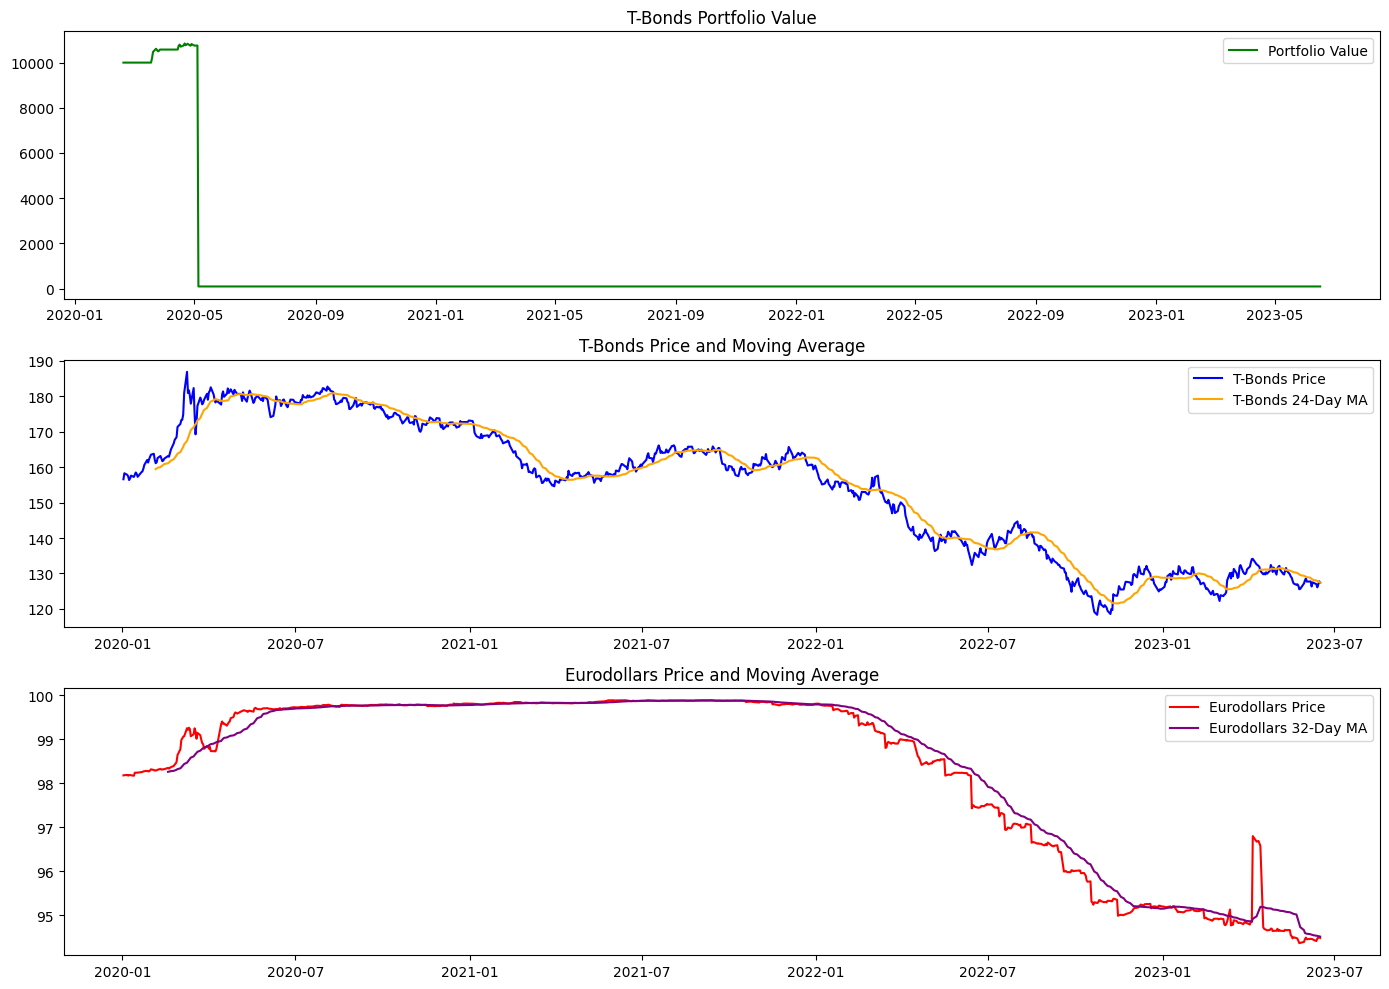

Final Portfolio Value: $93.53
Total Return: -99.06%


In [201]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Download historical data
start_date = '2020-01-02'
end_date = '2024-02-07'

# Download data for T-Bonds and Eurodollars
data_tbonds = yf.download('ZB=F', start=start_date, end=end_date, interval='1d')  # 30-Year T-Bonds
data_eurodollars = yf.download('GE=F', start=start_date, end=end_date, interval='1d')  # Eurodollars




# Clean data by flattening MultiIndex columns
data_tbonds.columns = data_tbonds.columns.droplevel(1)  # Flatten the MultiIndex columns for T-Bonds
data_eurodollars.columns = data_eurodollars.columns.droplevel(1)  # Flatten the MultiIndex columns for Eurodollars





# clean the data
data_tbonds.dropna(inplace=True)
data_eurodollars.dropna(inplace=True)

# Align data to the same index (dates)
data_tbonds, data_eurodollars = data_tbonds.align(data_eurodollars, join='inner')







# Step 2: Prepare data
data = pd.DataFrame({
    'TBonds': data_tbonds['Close'],
    'Eurodollars': data_eurodollars['Close']
})

# Calculate moving averages
len_tbonds = 24
len_eurodollars = 32
data['TBonds_MA'] = data['TBonds'].rolling(window=len_tbonds).mean()
data['Eurodollars_MA'] = data['Eurodollars'].rolling(window=len_eurodollars).mean()

# Step 3: Identify signals
data['Buy_Signal'] = (data['TBonds'] < data['TBonds_MA']) & (data['Eurodollars'] > data['Eurodollars_MA'])
data['Sell_Signal'] = (data['TBonds'] > data['TBonds_MA']) & (data['Eurodollars'] < data['Eurodollars_MA'])

# Step 4: Backtest
initial_cash = 10000
cash = initial_cash
shares = 0
portfolio_values = []

for i in range(max(len_tbonds, len_eurodollars), len(data)):
    if data['Buy_Signal'].iloc[i] and cash > 0:
        shares = cash // data['TBonds'].iloc[i]
        cash -= shares * data['TBonds'].iloc[i]
    elif data['Sell_Signal'].iloc[i] and shares > 0:
        cash += shares * data['TBonds'].iloc[i]
        shares = 0
    portfolio_value = cash + shares * data['TBonds'].iloc[i]
    portfolio_values.append(portfolio_value)

# Step 5: Visualizations
plt.figure(figsize=(14, 10))

# Portfolio Value
plt.subplot(3, 1, 1)
plt.plot(data.index[max(len_tbonds, len_eurodollars):], portfolio_values, label='Portfolio Value', color='green')
plt.title('T-Bonds Portfolio Value')
plt.legend(loc='best')

# T-Bonds Price and MA
plt.subplot(3, 1, 2)
plt.plot(data['TBonds'], label='T-Bonds Price', color='blue')
plt.plot(data['TBonds_MA'], label=f'T-Bonds {len_tbonds}-Day MA', color='orange')
plt.title('T-Bonds Price and Moving Average')
plt.legend(loc='best')

# Eurodollars Price and MA
plt.subplot(3, 1, 3)
plt.plot(data['Eurodollars'], label='Eurodollars Price', color='red')
plt.plot(data['Eurodollars_MA'], label=f'Eurodollars {len_eurodollars}-Day MA', color='purple')
plt.title('Eurodollars Price and Moving Average')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# Final Results
final_value = portfolio_values[-1]
total_return = (final_value - initial_cash) / initial_cash * 100

print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Total Return: {total_return:.2f}%")


In [1]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=b119a809577d1dff01b9f53160a50ec118be55b2c4a7da06b132e94aa0505171
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


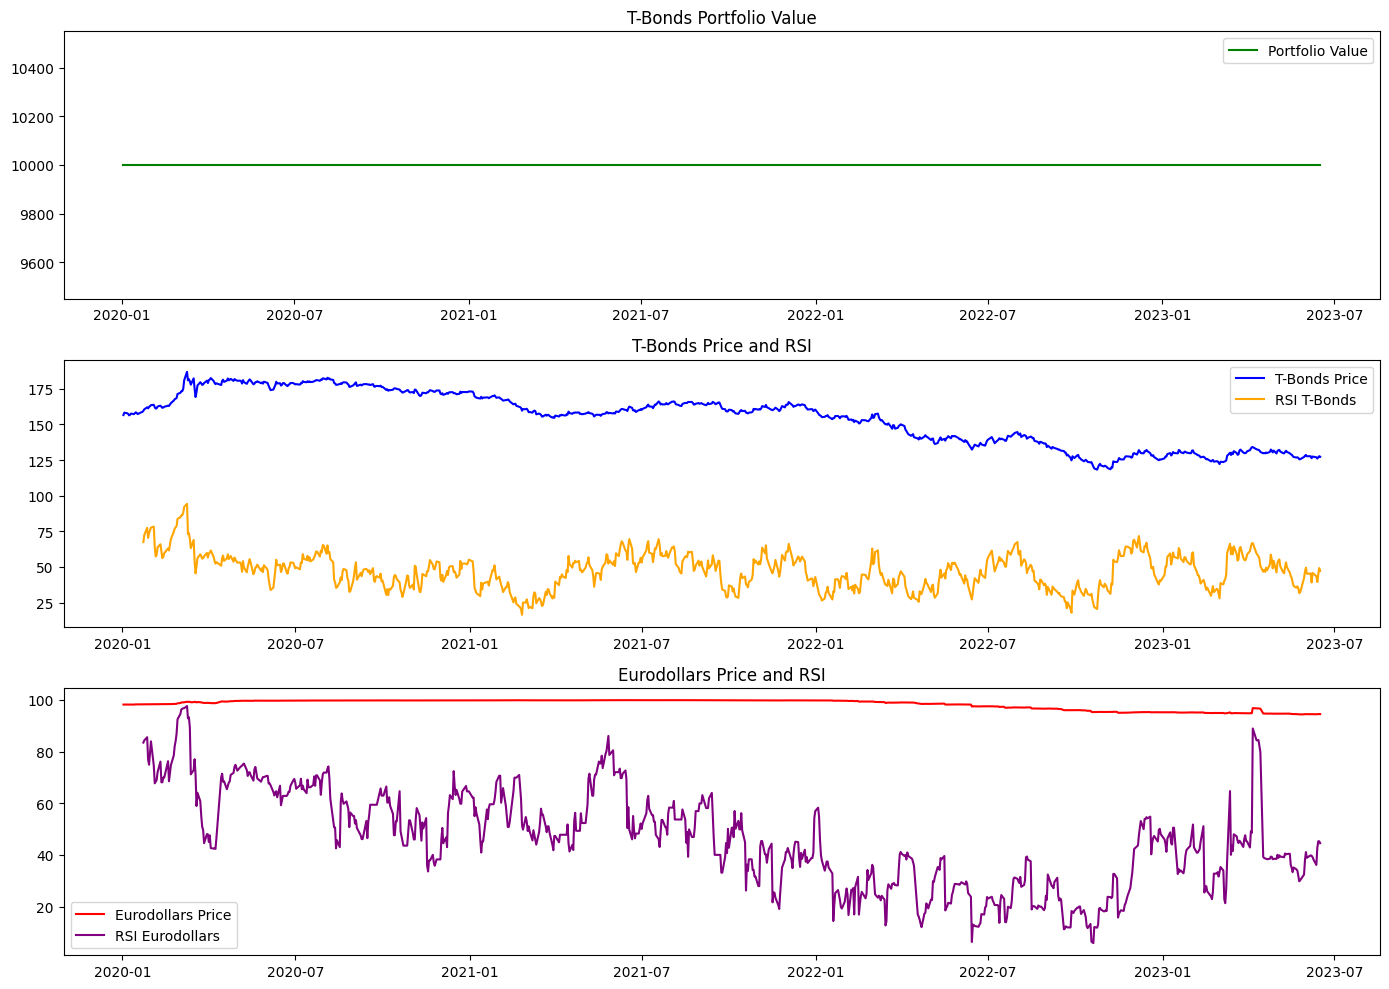

Final Portfolio Value: $10000.00
Total Return: 0.00%


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta

# Step 1: Download historical data
start_date = '2020-01-02'
end_date = '2024-02-07'

# Download data for T-Bonds and Eurodollars
data_tbonds = yf.download('ZB=F', start=start_date, end=end_date, interval='1d')  # 30-Year T-Bonds
data_eurodollars = yf.download('GE=F', start=start_date, end=end_date, interval='1d')  # Eurodollars




# Clean data by flattening MultiIndex columns
data_tbonds.columns = data_tbonds.columns.droplevel(1)  # Flatten the MultiIndex columns for T-Bonds
data_eurodollars.columns = data_eurodollars.columns.droplevel(1)  # Flatten the MultiIndex columns for Eurodollars





# clean the data
data_tbonds.dropna(inplace=True)
data_eurodollars.dropna(inplace=True)

# Align data to the same index (dates)
data_tbonds, data_eurodollars = data_tbonds.align(data_eurodollars, join='inner')



# Step 2: Prepare Data
data = pd.DataFrame({
    'TBonds': data_tbonds['Close'],
    'Eurodollars': data_eurodollars['Close']
})

# Step 3: Calculate RSI for T-Bonds and Eurodollars (14-period RSI)
data['RSI_TBonds'] = ta.rsi(data['TBonds'], length=14)
data['RSI_Eurodollars'] = ta.rsi(data['Eurodollars'], length=14)

# Step 4: Identify Divergence
def find_divergence(prices, rsi):
    # Bullish Divergence: Price makes lower low, but RSI makes higher low
    bullish_divergence = (prices < prices.shift(1)) & (rsi > rsi.shift(1))
    # Bearish Divergence: Price makes higher high, but RSI makes lower high
    bearish_divergence = (prices > prices.shift(1)) & (rsi < rsi.shift(1))

    return bullish_divergence, bearish_divergence

# Find Divergence for T-Bonds and Eurodollars
data['Bullish_Divergence_TBonds'], data['Bearish_Divergence_TBonds'] = find_divergence(data['TBonds'], data['RSI_TBonds'])
data['Bullish_Divergence_Eurodollars'], data['Bearish_Divergence_Eurodollars'] = find_divergence(data['Eurodollars'], data['RSI_Eurodollars'])

# Step 5: Generate Buy/Sell Signals based on Divergence
data['Buy_Signal'] = (data['Bullish_Divergence_TBonds'] & data['Bullish_Divergence_Eurodollars'])
data['Sell_Signal'] = (data['Bearish_Divergence_TBonds'] & data['Bearish_Divergence_Eurodollars'])

# Step 6: Backtest (Simple Strategy)
initial_cash = 10000
cash = initial_cash
shares = 0
portfolio_values = []

for i in range(1, len(data)):
    if data['Buy_Signal'].iloc[i] and cash > 0:  # Buy T-Bonds
        shares = cash // data['TBonds'].iloc[i]
        cash -= shares * data['TBonds'].iloc[i]
    elif data['Sell_Signal'].iloc[i] and shares > 0:  # Sell T-Bonds
        cash += shares * data['TBonds'].iloc[i]
        shares = 0
    portfolio_value = cash + shares * data['TBonds'].iloc[i]
    portfolio_values.append(portfolio_value)

# Step 7: Visualization
plt.figure(figsize=(14, 10))

# Portfolio Value
plt.subplot(3, 1, 1)
plt.plot(data.index[1:], portfolio_values, label='Portfolio Value', color='green')
plt.title('T-Bonds Portfolio Value')
plt.legend(loc='best')

# T-Bonds Price and RSI
plt.subplot(3, 1, 2)
plt.plot(data['TBonds'], label='T-Bonds Price', color='blue')
plt.plot(data['RSI_TBonds'], label='RSI T-Bonds', color='orange')
plt.title('T-Bonds Price and RSI')
plt.legend(loc='best')

# Eurodollars Price and RSI
plt.subplot(3, 1, 3)
plt.plot(data['Eurodollars'], label='Eurodollars Price', color='red')
plt.plot(data['RSI_Eurodollars'], label='RSI Eurodollars', color='purple')
plt.title('Eurodollars Price and RSI')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# Final Results
final_value = portfolio_values[-1]
total_return = (final_value - initial_cash) / initial_cash * 100

print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Total Return: {total_return:.2f}%")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


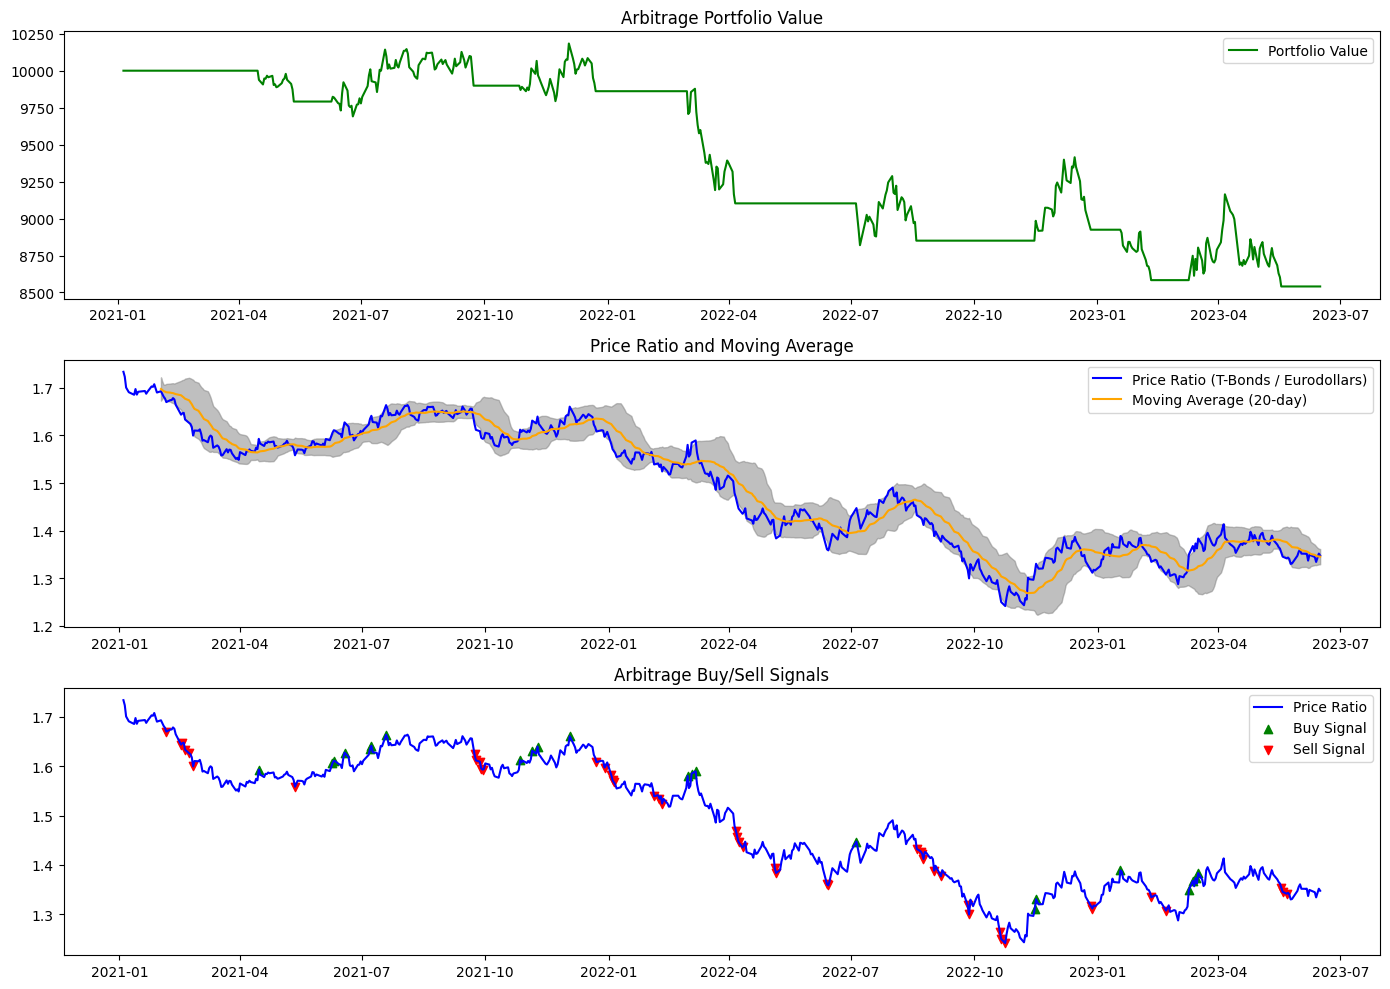

Final Portfolio Value: $8540.66
Total Return: -14.59%


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta

# Step 1: Download historical data
start_date = '2021-01-02'
end_date = '2024-02-07'

# Download data for T-Bonds and Eurodollars
data_tbonds = yf.download('ZB=F', start=start_date, end=end_date, interval='1d')  # 30-Year T-Bonds
data_eurodollars = yf.download('GE=F', start=start_date, end=end_date, interval='1d')  # Eurodollars





# Clean data by flattening MultiIndex columns
data_tbonds.columns = data_tbonds.columns.droplevel(1)  # Flatten the MultiIndex columns for T-Bonds
data_eurodollars.columns = data_eurodollars.columns.droplevel(1)  # Flatten the MultiIndex columns for Eurodollars





# clean the data
data_tbonds.dropna(inplace=True)
data_eurodollars.dropna(inplace=True)

# Align data to the same index (dates)
data_tbonds, data_eurodollars = data_tbonds.align(data_eurodollars, join='inner')

# Step 2: Prepare Data
data = pd.DataFrame({
    'TBonds': data_tbonds['Close'],
    'Eurodollars': data_eurodollars['Close']
})

# Step 3: Calculate the price ratio between T-Bonds and Eurodollars
data['Price_Ratio'] = data['TBonds'] / data['Eurodollars']

# Step 4: Calculate moving average and standard deviation of the price ratio
window_size = 20  # 30-day moving average
data['Price_Ratio_MA'] = data['Price_Ratio'].rolling(window=window_size).mean()
data['Price_Ratio_STD'] = data['Price_Ratio'].rolling(window=window_size).std()

# Step 5: Define the threshold for detecting arbitrage
threshold = 2  # 2 standard deviations

# Step 6: Detect arbitrage opportunities
data['Arbitrage_Opportunity'] = np.where(
    (data['Price_Ratio'] > data['Price_Ratio_MA'] + threshold * data['Price_Ratio_STD']) |
    (data['Price_Ratio'] < data['Price_Ratio_MA'] - threshold * data['Price_Ratio_STD']),
    1, 0)  # 1 indicates an arbitrage opportunity

# Step 7: Generate buy/sell signals for arbitrage
# Buy when the ratio is significantly higher (sell Eurodollars, buy T-Bonds)
data['Buy_Signal'] = (data['Arbitrage_Opportunity'] == 1) & (data['Price_Ratio'] > data['Price_Ratio_MA'] + threshold * data['Price_Ratio_STD'])

# Sell when the ratio is significantly lower (buy Eurodollars, sell T-Bonds)
data['Sell_Signal'] = (data['Arbitrage_Opportunity'] == 1) & (data['Price_Ratio'] < data['Price_Ratio_MA'] - threshold * data['Price_Ratio_STD'])

# Step 8: Backtest (Simple Strategy)
initial_cash = 10000
cash = initial_cash
shares_tbonds = 0
shares_eurodollars = 0
portfolio_values = []

for i in range(1, len(data)):
    if data['Buy_Signal'].iloc[i] and cash > 0:  # Buy T-Bonds and sell Eurodollars
        shares_tbonds = cash // data['TBonds'].iloc[i]
        shares_eurodollars = cash // data['Eurodollars'].iloc[i]
        cash -= shares_tbonds * data['TBonds'].iloc[i] + shares_eurodollars * data['Eurodollars'].iloc[i]
    elif data['Sell_Signal'].iloc[i] and shares_tbonds > 0 and shares_eurodollars > 0:  # Sell T-Bonds and buy Eurodollars
        cash += shares_tbonds * data['TBonds'].iloc[i] + shares_eurodollars * data['Eurodollars'].iloc[i]
        shares_tbonds = 0
        shares_eurodollars = 0
    portfolio_value = cash + shares_tbonds * data['TBonds'].iloc[i] + shares_eurodollars * data['Eurodollars'].iloc[i]
    portfolio_values.append(portfolio_value)

# Step 9: Visualization
plt.figure(figsize=(14, 10))

# Portfolio Value
plt.subplot(3, 1, 1)
plt.plot(data.index[1:], portfolio_values, label='Portfolio Value', color='green')
plt.title('Arbitrage Portfolio Value')
plt.legend(loc='best')

# Price Ratio and Moving Average
plt.subplot(3, 1, 2)
plt.plot(data['Price_Ratio'], label='Price Ratio (T-Bonds / Eurodollars)', color='blue')
plt.plot(data['Price_Ratio_MA'], label=f'Moving Average ({window_size}-day)', color='orange')
plt.fill_between(data.index, data['Price_Ratio_MA'] + threshold * data['Price_Ratio_STD'], data['Price_Ratio_MA'] - threshold * data['Price_Ratio_STD'], color='gray', alpha=0.5)
plt.title('Price Ratio and Moving Average')
plt.legend(loc='best')

# Buy/Sell Signals
plt.subplot(3, 1, 3)
plt.plot(data.index, data['Price_Ratio'], label='Price Ratio', color='blue')
plt.scatter(data.index[data['Buy_Signal'] == 1], data['Price_Ratio'][data['Buy_Signal'] == 1], marker='^', color='g', label='Buy Signal')
plt.scatter(data.index[data['Sell_Signal'] == 1], data['Price_Ratio'][data['Sell_Signal'] == 1], marker='v', color='r', label='Sell Signal')
plt.title('Arbitrage Buy/Sell Signals')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# Final Results
final_value = portfolio_values[-1]
total_return = (final_value - initial_cash) / initial_cash * 100

print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Total Return: {total_return:.2f}%")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


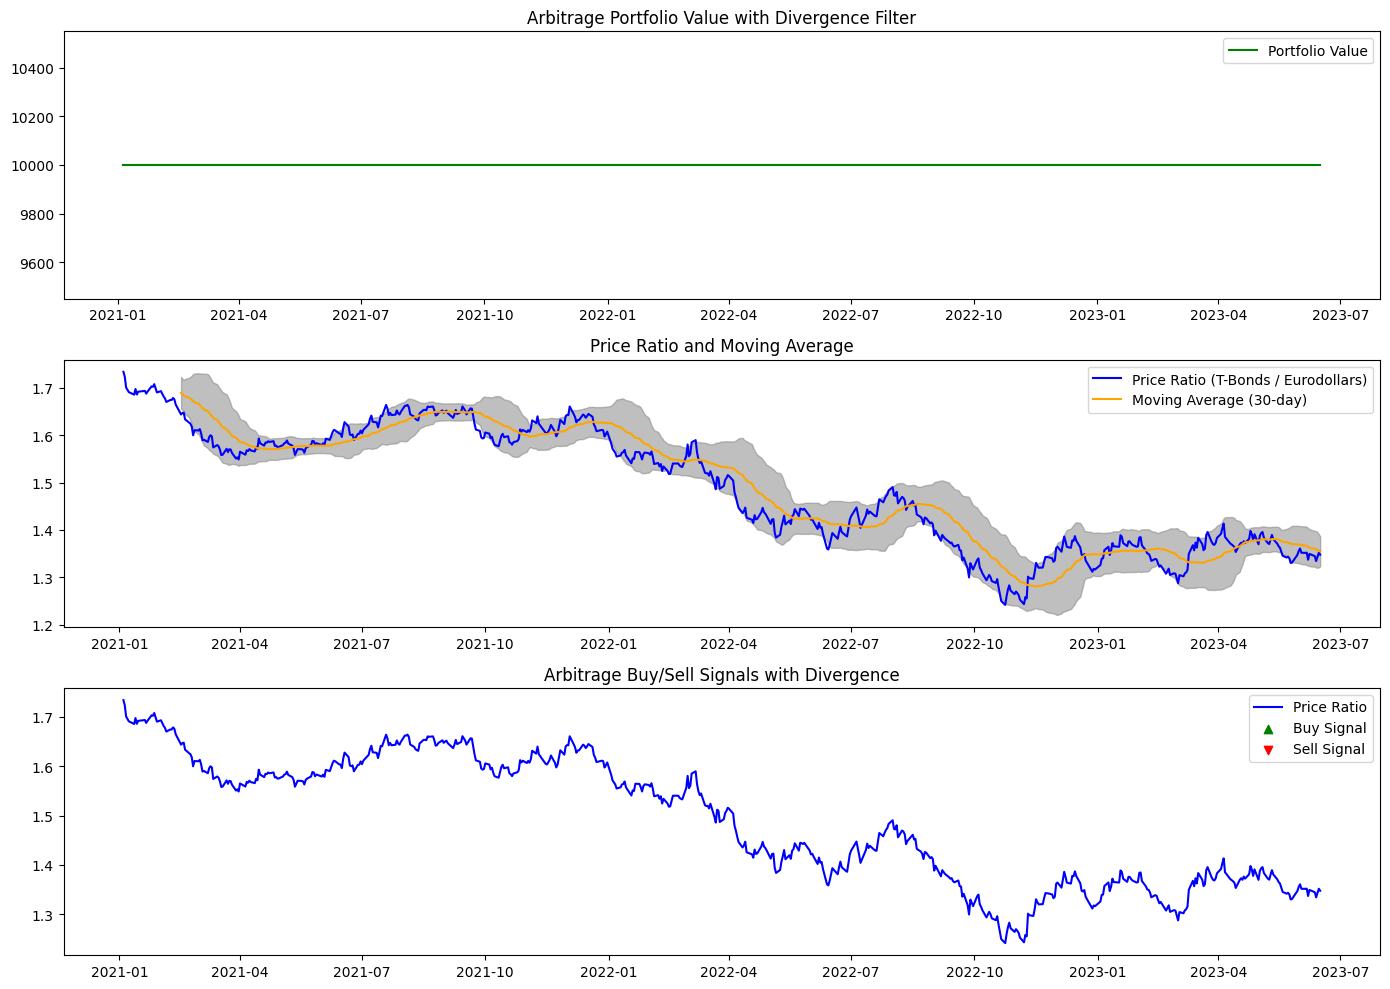

Final Portfolio Value: $10000.00
Total Return: 0.00%


In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta

# Step 1: Download historical data
start_date = '2021-01-02'
end_date = '2024-02-07'

# Download data for T-Bonds and Eurodollars
data_tbonds = yf.download('ZB=F', start=start_date, end=end_date, interval='1d')  # 30-Year T-Bonds
data_eurodollars = yf.download('GE=F', start=start_date, end=end_date, interval='1d')  # Eurodollars







# Clean data by flattening MultiIndex columns
data_tbonds.columns = data_tbonds.columns.droplevel(1)  # Flatten the MultiIndex columns for T-Bonds
data_eurodollars.columns = data_eurodollars.columns.droplevel(1)  # Flatten the MultiIndex columns for Eurodollars





# clean the data
data_tbonds.dropna(inplace=True)
data_eurodollars.dropna(inplace=True)

# Align data to the same index (dates)
data_tbonds, data_eurodollars = data_tbonds.align(data_eurodollars, join='inner')






# Step 2: Prepare Data
data = pd.DataFrame({
    'TBonds': data_tbonds['Close'],
    'Eurodollars': data_eurodollars['Close']
})

# Step 3: Calculate the price ratio between T-Bonds and Eurodollars
data['Price_Ratio'] = data['TBonds'] / data['Eurodollars']

# Step 4: Calculate moving average and standard deviation of the price ratio
window_size = 30  # 30-day moving average
data['Price_Ratio_MA'] = data['Price_Ratio'].rolling(window=window_size).mean()
data['Price_Ratio_STD'] = data['Price_Ratio'].rolling(window=window_size).std()

# Step 5: Calculate RSI for T-Bonds and Eurodollars
rsi_period = 14  # 14-day RSI
data['RSI_TBonds'] = ta.rsi(data['TBonds'], length=rsi_period)
data['RSI_Eurodollars'] = ta.rsi(data['Eurodollars'], length=rsi_period)

# Step 6: Define the threshold for detecting arbitrage
threshold = 2  # 2 standard deviations

# Step 7: Detect arbitrage opportunities
data['Arbitrage_Opportunity'] = np.where(
    (data['Price_Ratio'] > data['Price_Ratio_MA'] + threshold * data['Price_Ratio_STD']) |
    (data['Price_Ratio'] < data['Price_Ratio_MA'] - threshold * data['Price_Ratio_STD']),
    1, 0)  # 1 indicates an arbitrage opportunity

# Step 8: Detect Divergence (RSI Divergence)
data['Bullish_Divergence'] = ((data['TBonds'] < data['TBonds'].shift(1)) & (data['RSI_TBonds'] > data['RSI_TBonds'].shift(1)))
data['Bearish_Divergence'] = ((data['TBonds'] > data['TBonds'].shift(1)) & (data['RSI_TBonds'] < data['RSI_TBonds'].shift(1)))

# Step 9: Generate buy/sell signals for arbitrage with divergence
# Buy when the price ratio is significantly higher, and there's a bullish divergence
data['Buy_Signal'] = (data['Arbitrage_Opportunity'] == 1) & (data['Price_Ratio'] > data['Price_Ratio_MA'] + threshold * data['Price_Ratio_STD']) & (data['Bullish_Divergence'] == 1)

# Sell when the price ratio is significantly lower, and there's a bearish divergence
data['Sell_Signal'] = (data['Arbitrage_Opportunity'] == 1) & (data['Price_Ratio'] < data['Price_Ratio_MA'] - threshold * data['Price_Ratio_STD']) & (data['Bearish_Divergence'] == 1)

# Step 10: Backtest (Simple Strategy)
initial_cash = 10000
cash = initial_cash
shares_tbonds = 0
shares_eurodollars = 0
portfolio_values = []

for i in range(1, len(data)):
    if data['Buy_Signal'].iloc[i] and cash > 0:  # Buy T-Bonds and sell Eurodollars
        shares_tbonds = cash // data['TBonds'].iloc[i]
        shares_eurodollars = cash // data['Eurodollars'].iloc[i]
        cash -= shares_tbonds * data['TBonds'].iloc[i] + shares_eurodollars * data['Eurodollars'].iloc[i]
    elif data['Sell_Signal'].iloc[i] and shares_tbonds > 0 and shares_eurodollars > 0:  # Sell T-Bonds and buy Eurodollars
        cash += shares_tbonds * data['TBonds'].iloc[i] + shares_eurodollars * data['Eurodollars'].iloc[i]
        shares_tbonds = 0
        shares_eurodollars = 0
    portfolio_value = cash + shares_tbonds * data['TBonds'].iloc[i] + shares_eurodollars * data['Eurodollars'].iloc[i]
    portfolio_values.append(portfolio_value)

# Step 11: Visualization
plt.figure(figsize=(14, 10))

# Portfolio Value
plt.subplot(3, 1, 1)
plt.plot(data.index[1:], portfolio_values, label='Portfolio Value', color='green')
plt.title('Arbitrage Portfolio Value with Divergence Filter')
plt.legend(loc='best')

# Price Ratio and Moving Average
plt.subplot(3, 1, 2)
plt.plot(data['Price_Ratio'], label='Price Ratio (T-Bonds / Eurodollars)', color='blue')
plt.plot(data['Price_Ratio_MA'], label=f'Moving Average ({window_size}-day)', color='orange')
plt.fill_between(data.index, data['Price_Ratio_MA'] + threshold * data['Price_Ratio_STD'], data['Price_Ratio_MA'] - threshold * data['Price_Ratio_STD'], color='gray', alpha=0.5)
plt.title('Price Ratio and Moving Average')
plt.legend(loc='best')

# Buy/Sell Signals
plt.subplot(3, 1, 3)
plt.plot(data.index, data['Price_Ratio'], label='Price Ratio', color='blue')
plt.scatter(data.index[data['Buy_Signal'] == 1], data['Price_Ratio'][data['Buy_Signal'] == 1], marker='^', color='g', label='Buy Signal')
plt.scatter(data.index[data['Sell_Signal'] == 1], data['Price_Ratio'][data['Sell_Signal'] == 1], marker='v', color='r', label='Sell Signal')
plt.title('Arbitrage Buy/Sell Signals with Divergence')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# Final Results
final_value = portfolio_values[-1]
total_return = (final_value - initial_cash) / initial_cash * 100

print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Total Return: {total_return:.2f}%")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


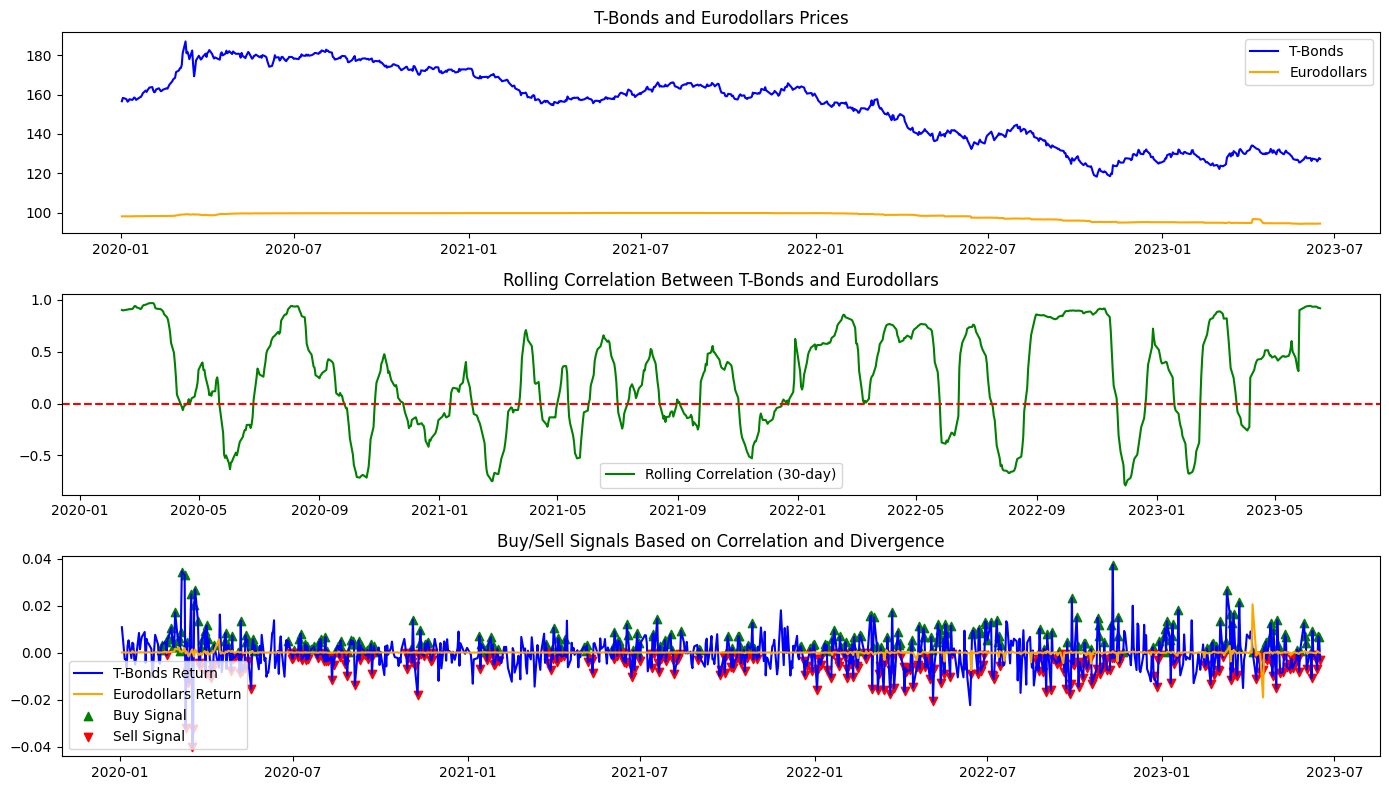

Total Buy Signals: 134
Total Sell Signals: 135


In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Download Historical Data
start_date = '2020-01-02'
end_date = '2024-02-07'

# Download data for T-Bonds and Eurodollars
data_tbonds = yf.download('ZB=F', start=start_date, end=end_date, interval='1d')  # 30-Year T-Bonds
data_eurodollars = yf.download('GE=F', start=start_date, end=end_date, interval='1d')  # Eurodollars




# Clean data by flattening MultiIndex columns
data_tbonds.columns = data_tbonds.columns.droplevel(1)  # Flatten the MultiIndex columns for T-Bonds
data_eurodollars.columns = data_eurodollars.columns.droplevel(1)  # Flatten the MultiIndex columns for Eurodollars





# clean the data
data_tbonds.dropna(inplace=True)
data_eurodollars.dropna(inplace=True)

# Align data to the same index (dates)
data_tbonds, data_eurodollars = data_tbonds.align(data_eurodollars, join='inner')









# Step 2: Prepare Data
data = pd.DataFrame({
    'TBonds': data_tbonds['Close'],
    'Eurodollars': data_eurodollars['Close']
}).dropna()

# Step 3: Calculate Rolling Correlation
correlation_window = 30  # 30-day rolling window
data['Rolling_Correlation'] = data['TBonds'].rolling(correlation_window).corr(data['Eurodollars'])

# Step 4: Calculate Returns
data['TBonds_Return'] = data['TBonds'].pct_change()
data['Eurodollars_Return'] = data['Eurodollars'].pct_change()

# Step 5: Generate Signals Based on Divergence in Correlation
data['Buy_Signal'] = np.where(
    (data['Rolling_Correlation'] > 0) & (data['TBonds_Return'] > 0), 1,  # Positive correlation, T-Bonds up -> Buy Eurodollars
    np.where(
        (data['Rolling_Correlation'] < 0) & (data['TBonds_Return'] > 0), -1, 0  # Negative correlation, T-Bonds up -> Sell Eurodollars
    )
)

data['Sell_Signal'] = np.where(
    (data['Rolling_Correlation'] > 0) & (data['TBonds_Return'] < 0), 1,  # Positive correlation, T-Bonds down -> Sell Eurodollars
    np.where(
        (data['Rolling_Correlation'] < 0) & (data['TBonds_Return'] < 0), -1, 0  # Negative correlation, T-Bonds down -> Buy Eurodollars
    )
)

# Step 6: Visualize Markets and Rolling Correlation
plt.figure(figsize=(14, 8))

# Plot T-Bonds and Eurodollars
plt.subplot(3, 1, 1)
plt.plot(data.index, data['TBonds'], label='T-Bonds', color='blue')
plt.plot(data.index, data['Eurodollars'], label='Eurodollars', color='orange')
plt.title('T-Bonds and Eurodollars Prices')
plt.legend(loc='best')

# Plot Rolling Correlation
plt.subplot(3, 1, 2)
plt.plot(data.index, data['Rolling_Correlation'], label='Rolling Correlation (30-day)', color='green')
plt.axhline(0, color='red', linestyle='--')
plt.title('Rolling Correlation Between T-Bonds and Eurodollars')
plt.legend(loc='best')

# Plot Buy/Sell Signals
plt.subplot(3, 1, 3)
plt.plot(data.index, data['TBonds_Return'], label='T-Bonds Return', color='blue')
plt.plot(data.index, data['Eurodollars_Return'], label='Eurodollars Return', color='orange')
buy_signals = data.index[data['Buy_Signal'] == 1]
sell_signals = data.index[data['Sell_Signal'] == 1]
plt.scatter(buy_signals, data.loc[buy_signals, 'TBonds_Return'], color='green', label='Buy Signal', marker='^')
plt.scatter(sell_signals, data.loc[sell_signals, 'TBonds_Return'], color='red', label='Sell Signal', marker='v')
plt.title('Buy/Sell Signals Based on Correlation and Divergence')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# Print a summary of signals
print("Total Buy Signals:", data['Buy_Signal'].sum())
print("Total Sell Signals:", data['Sell_Signal'].sum())





Initial Capital: $ 100000
Final Portfolio Value: $ 97451.13
Total Profit/Loss: $ -2548.87
Total Trades: 276
Trade Log:
{'Type': 'Buy', 'Price': 98.31749725341797, 'Date': Timestamp('2020-02-13 00:00:00')}
{'Type': 'Sell', 'Price': 98.3324966430664, 'Date': Timestamp('2020-02-19 00:00:00'), 'Profit': -8.474392649583434}
{'Type': 'Buy', 'Price': 98.34750366210938, 'Date': Timestamp('2020-02-20 00:00:00')}
{'Type': 'Sell', 'Price': 99.2125015258789, 'Date': Timestamp('2020-03-10 00:00:00'), 'Profit': 77.95320995044142}
{'Type': 'Buy', 'Price': 99.25749969482422, 'Date': Timestamp('2020-03-11 00:00:00')}
{'Type': 'Sell', 'Price': 99.22750091552734, 'Date': Timestamp('2020-03-12 00:00:00'), 'Profit': -13.022318654923692}
{'Type': 'Buy', 'Price': 99.11060333251953, 'Date': Timestamp('2020-03-16 00:00:00')}
{'Type': 'Sell', 'Price': 99.24500274658203, 'Date': Timestamp('2020-03-17 00:00:00'), 'Profit': 3.560548472456098}
{'Type': 'Buy', 'Price': 99.01000213623047, 'Date': Timestamp('2020-03-1

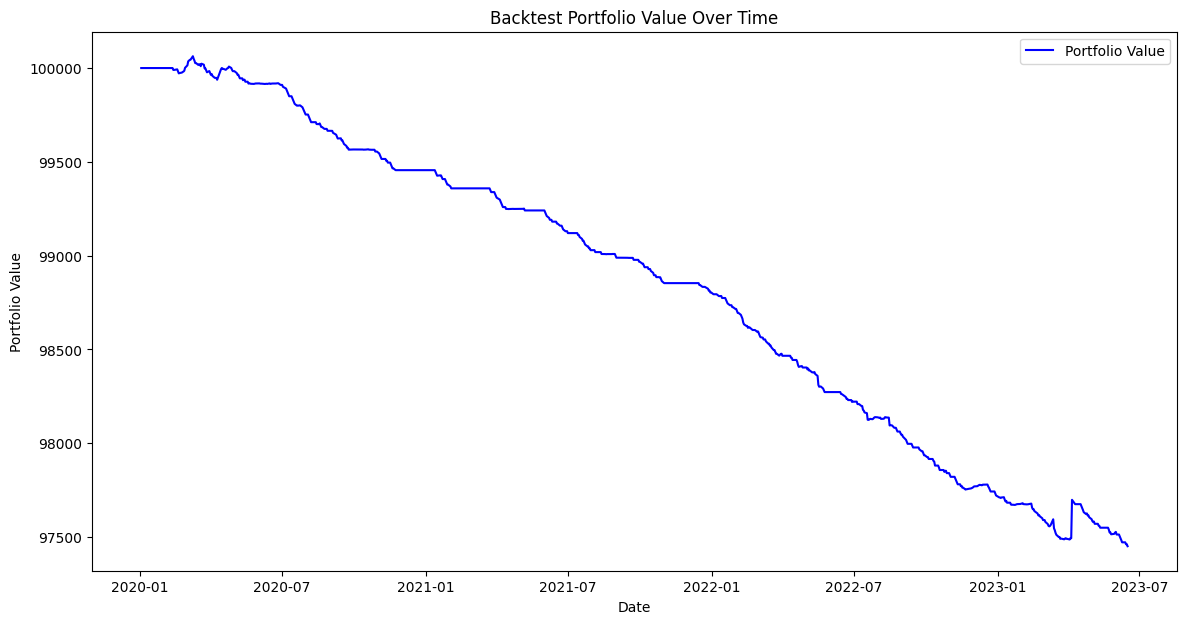

In [18]:
# Backtesting Parameters
initial_capital = 100000  # Starting with $100,000
position_size = initial_capital * 0.1  # 10% of capital per trade
transaction_cost = 0.001  # 0.1% transaction cost

# Add a column for daily returns (Adj Close)
data['Eurodollars_Returns'] = data['Eurodollars'].pct_change()

# Initialize variables for backtesting
capital = initial_capital
positions = 0  # Number of shares/contracts held
trade_log = []  # To store trade details

# Backtesting loop
for i in range(1, len(data)):
    # Check Buy Signal
    if data['Buy_Signal'].iloc[i] == 1 and positions == 0:
        # Buy Eurodollars
        entry_price = data['Eurodollars'].iloc[i]
        positions = position_size / entry_price  # Number of shares/contracts
        capital -= position_size * (1 + transaction_cost)  # Deduct from capital
        trade_log.append({'Type': 'Buy', 'Price': entry_price, 'Date': data.index[i]})

    # Check Sell Signal
    elif data['Sell_Signal'].iloc[i] == 1 and positions > 0:
        # Sell Eurodollars
        exit_price = data['Eurodollars'].iloc[i]
        profit = positions * (exit_price - entry_price) - position_size * transaction_cost
        capital += position_size + profit  # Add profit to capital
        positions = 0  # Reset positions
        trade_log.append({'Type': 'Sell', 'Price': exit_price, 'Date': data.index[i], 'Profit': profit})

    # Calculate the cumulative portfolio value
    data.loc[data.index[i], 'Portfolio_Value'] = capital + (positions * data['Eurodollars'].iloc[i] if positions > 0 else 0)

# Final Portfolio Value
final_portfolio_value = capital + (positions * data['Eurodollars'].iloc[-1] if positions > 0 else 0)

# Backtesting Results
print("Initial Capital: $", initial_capital)
print("Final Portfolio Value: $", round(final_portfolio_value, 2))
print("Total Profit/Loss: $", round(final_portfolio_value - initial_capital, 2))
print("Total Trades:", len(trade_log))
print("Trade Log:")
for trade in trade_log:
    print(trade)

# Visualization
plt.figure(figsize=(14, 7))

# Plot Portfolio Value
plt.plot(data.index, data['Portfolio_Value'], label='Portfolio Value', color='blue')
plt.title('Backtest Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()


# Conditional Purchase

Total Trades: 93
Trade Log:
{'Type': 'Buy', 'Price': 98.31749725341797, 'Date': Timestamp('2020-02-13 00:00:00')}
{'Type': 'Buy', 'Price': 98.36499786376953, 'Date': Timestamp('2020-02-21 00:00:00')}
{'Type': 'Buy', 'Price': 99.11060333251953, 'Date': Timestamp('2020-03-16 00:00:00')}
{'Type': 'Buy', 'Price': 99.13999938964844, 'Date': Timestamp('2020-03-20 00:00:00')}
{'Type': 'Buy', 'Price': 98.88500213623047, 'Date': Timestamp('2020-03-26 00:00:00')}
{'Type': 'Buy', 'Price': 98.82749938964844, 'Date': Timestamp('2020-04-02 00:00:00')}
{'Type': 'Buy', 'Price': 98.78109741210938, 'Date': Timestamp('2020-04-09 00:00:00')}
{'Type': 'Buy', 'Price': 99.61750030517578, 'Date': Timestamp('2020-05-04 00:00:00')}
{'Type': 'Buy', 'Price': 99.61750030517578, 'Date': Timestamp('2020-05-12 00:00:00')}
{'Type': 'Buy', 'Price': 99.69249725341797, 'Date': Timestamp('2020-05-19 00:00:00')}
{'Type': 'Buy', 'Price': 99.71749877929688, 'Date': Timestamp('2020-07-02 00:00:00')}
{'Type': 'Buy', 'Price': 9

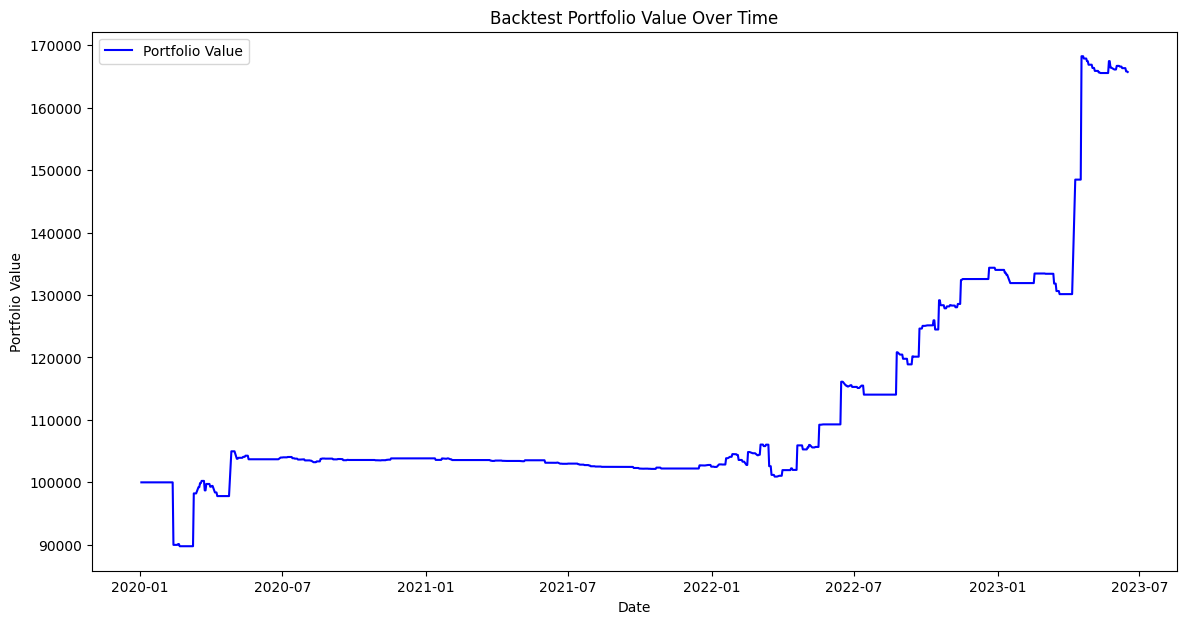

Final Capital: $175688.72
Total Profit: $75688.72
Total Trades: 2136


In [26]:
# Modified Backtesting Logic with Improved Conditions
capital = 100000
position = None  # Track current position ('buy', 'sell', or None)
entry_price = 0
min_holding_days = 2  # Minimum holding period to avoid quick flips
holding_period = 0  # Track holding period
trade_logs = []


# Enhanced Backtesting Logic
for i in range(1, len(data)):
    holding_period += 1  # Increment holding period if a position exists

    # Buy Signal Logic
    if data['Buy_Signal'].iloc[i] == 1 and position != 'buy' and holding_period >= min_holding_days:
        # Close any existing sell position
        if position == 'sell':
            exit_price = data['Eurodollars'].iloc[i]
            profit = (entry_price - exit_price) * position_size - (position_size * transaction_cost)
            capital += position_size + profit
            trade_log.append({'Type': 'Sell_Close', 'Price': exit_price, 'Date': data.index[i], 'Profit': profit})
            position = None

        # Open a new buy position
        entry_price = data['Eurodollars'].iloc[i]
        position = 'buy'
        capital -= position_size * (1 + transaction_cost)
        trade_log.append({'Type': 'Buy', 'Price': entry_price, 'Date': data.index[i]})
        holding_period = 0  # Reset holding period
        trade_logs.append({'Type': 'Buy', 'Price': entry_price, 'Date': data.index[i]})

    # Sell Signal Logic
    elif data['Sell_Signal'].iloc[i] == 1 and position != 'sell' and holding_period >= min_holding_days:
        # Close any existing buy position
        if position == 'buy':
            exit_price = data['Eurodollars'].iloc[i]
            profit = (exit_price - entry_price) * position_size - (position_size * transaction_cost)
            capital += position_size + profit
            trade_log.append({'Type': 'Buy_Close', 'Price': exit_price, 'Date': data.index[i], 'Profit': profit})
            position = None

        # Open a new sell position
        entry_price = data['Eurodollars'].iloc[i]
        position = 'sell'
        capital -= position_size * (1 + transaction_cost)
        trade_log.append({'Type': 'Sell', 'Price': entry_price, 'Date': data.index[i]})
        holding_period = 0  # Reset holding period

    # Update Portfolio Value
    data.loc[data.index[i], 'Portfolio_Value'] = capital

# Calculate Final Capital
if position is not None:
    # Close any open position at the end of backtest
    exit_price = data['Eurodollars'].iloc[-1]
    if position == 'buy':
        profit = (exit_price - entry_price) * position_size - (position_size * transaction_cost)
    else:
        profit = (entry_price - exit_price) * position_size - (position_size * transaction_cost)
    capital += position_size + profit
    trade_log.append({'Type': f'{position.capitalize()}_Close', 'Price': exit_price, 'Date': data.index[-1], 'Profit': profit})
    position = None




#####




####




print("Total Trades:", len(trade_logs))
print("Trade Log:")
for trade in trade_logs:
    print(trade)


# Visualization
plt.figure(figsize=(14, 7))

# Plot Portfolio Value
plt.plot(data.index, data['Portfolio_Value'], label='Portfolio Value', color='blue')
plt.title('Backtest Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

# Results
print(f"Final Capital: ${round(capital, 2)}")
print(f"Total Profit: ${round(capital - 100000, 2)}")
print(f"Total Trades: {len(trade_log)}")


# Update

Initial Capital: $ 100000
Final Portfolio Value: $ 175688.72
Total Profit/Loss: $ 75688.72
Total Trades: 372
Trade Log:
{'Type': 'Buy', 'Price': 98.31749725341797, 'Date': Timestamp('2020-02-13 00:00:00')}
{'Type': 'Buy_Close', 'Price': 98.3324966430664, 'Date': Timestamp('2020-02-19 00:00:00'), 'Profit': 139.993896484375}
{'Type': 'Sell', 'Price': 98.3324966430664, 'Date': Timestamp('2020-02-19 00:00:00')}
{'Type': 'Sell_Close', 'Price': 98.36499786376953, 'Date': Timestamp('2020-02-21 00:00:00'), 'Profit': -335.01220703125}
{'Type': 'Buy', 'Price': 98.36499786376953, 'Date': Timestamp('2020-02-21 00:00:00')}
{'Type': 'Buy_Close', 'Price': 99.2125015258789, 'Date': Timestamp('2020-03-10 00:00:00'), 'Profit': 8465.03662109375}
{'Type': 'Sell', 'Price': 99.2125015258789, 'Date': Timestamp('2020-03-10 00:00:00')}
{'Type': 'Sell_Close', 'Price': 99.11060333251953, 'Date': Timestamp('2020-03-16 00:00:00'), 'Profit': 1008.98193359375}
{'Type': 'Buy', 'Price': 99.11060333251953, 'Date': Time

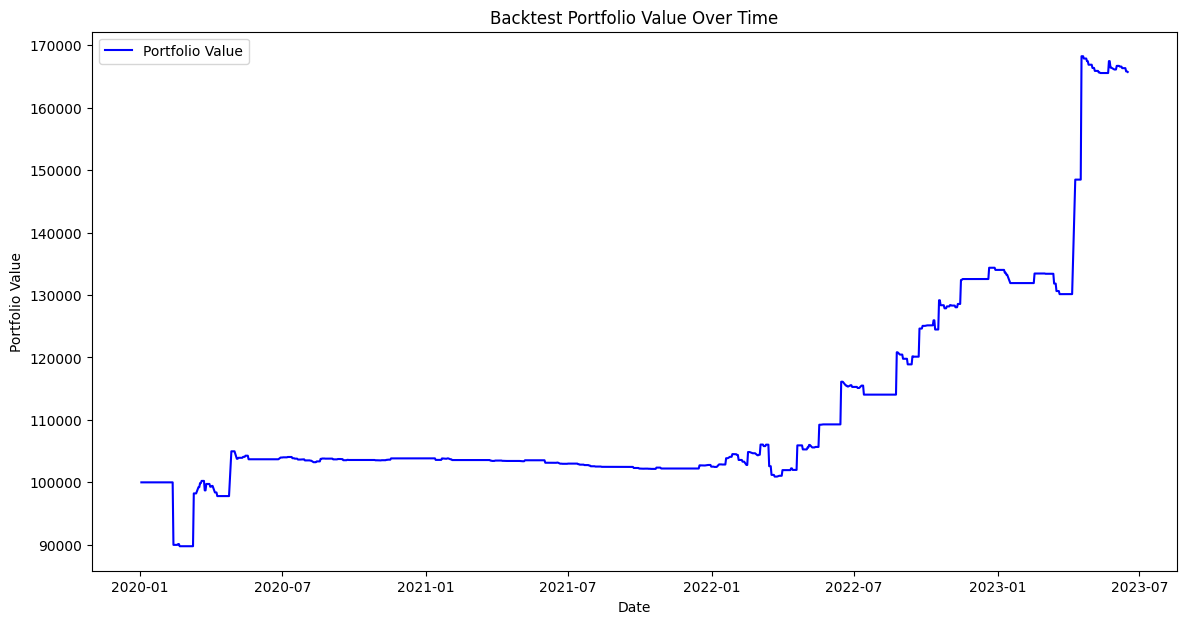

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Initialize variables
initial_capital = 100000
capital = initial_capital
position = None  # Track current position ('buy', 'sell', or None)
entry_price = 0
min_holding_days = 2  # Minimum holding period to avoid quick flips
holding_period = 0  # Track holding period
position_size = 10000  # Example position size
transaction_cost = 0.001  # Example transaction cost as a fraction
trade_log = []  # Store trade details

# Enhanced Backtesting Logic
for i in range(1, len(data)):
    holding_period += 1  # Increment holding period if a position exists

    # Check for Buy Signal
    if data['Buy_Signal'].iloc[i] == 1 and position != 'buy' and holding_period >= min_holding_days:
        # Close existing sell position
        if position == 'sell':
            exit_price = data['Eurodollars'].iloc[i]
            profit = (entry_price - exit_price) * position_size - (position_size * transaction_cost)
            capital += position_size + profit
            trade_log.append({'Type': 'Sell_Close', 'Price': exit_price, 'Date': data.index[i], 'Profit': profit})
            position = None

        # Open new buy position
        entry_price = data['Eurodollars'].iloc[i]
        position = 'buy'
        capital -= position_size * (1 + transaction_cost)
        trade_log.append({'Type': 'Buy', 'Price': entry_price, 'Date': data.index[i]})
        holding_period = 0  # Reset holding period

    # Check for Sell Signal
    elif data['Sell_Signal'].iloc[i] == 1 and position != 'sell' and holding_period >= min_holding_days:
        # Close existing buy position
        if position == 'buy':
            exit_price = data['Eurodollars'].iloc[i]
            profit = (exit_price - entry_price) * position_size - (position_size * transaction_cost)
            capital += position_size + profit
            trade_log.append({'Type': 'Buy_Close', 'Price': exit_price, 'Date': data.index[i], 'Profit': profit})
            position = None

        # Open new sell position
        entry_price = data['Eurodollars'].iloc[i]
        position = 'sell'
        capital -= position_size * (1 + transaction_cost)
        trade_log.append({'Type': 'Sell', 'Price': entry_price, 'Date': data.index[i]})
        holding_period = 0  # Reset holding period

    # Update Portfolio Value
    data.loc[data.index[i], 'Portfolio_Value'] = capital

# Close any remaining open position at the end of the backtest
if position is not None:
    exit_price = data['Eurodollars'].iloc[-1]
    if position == 'buy':
        profit = (exit_price - entry_price) * position_size - (position_size * transaction_cost)
    else:
        profit = (entry_price - exit_price) * position_size - (position_size * transaction_cost)
    capital += position_size + profit
    trade_log.append({'Type': f'{position.capitalize()}_Close', 'Price': exit_price, 'Date': data.index[-1], 'Profit': profit})
    position = None

# Final Portfolio Value
final_portfolio_value = capital

# Backtesting Results
print("Initial Capital: $", initial_capital)
print("Final Portfolio Value: $", round(final_portfolio_value, 2))
print("Total Profit/Loss: $", round(final_portfolio_value - initial_capital, 2))
print("Total Trades:", len(trade_log))
print("Trade Log:")
for trade in trade_log:
    print(trade)

# Visualization
plt.figure(figsize=(14, 7))

# Plot Portfolio Value
plt.plot(data.index, data['Portfolio_Value'], label='Portfolio Value', color='blue')
plt.title('Backtest Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


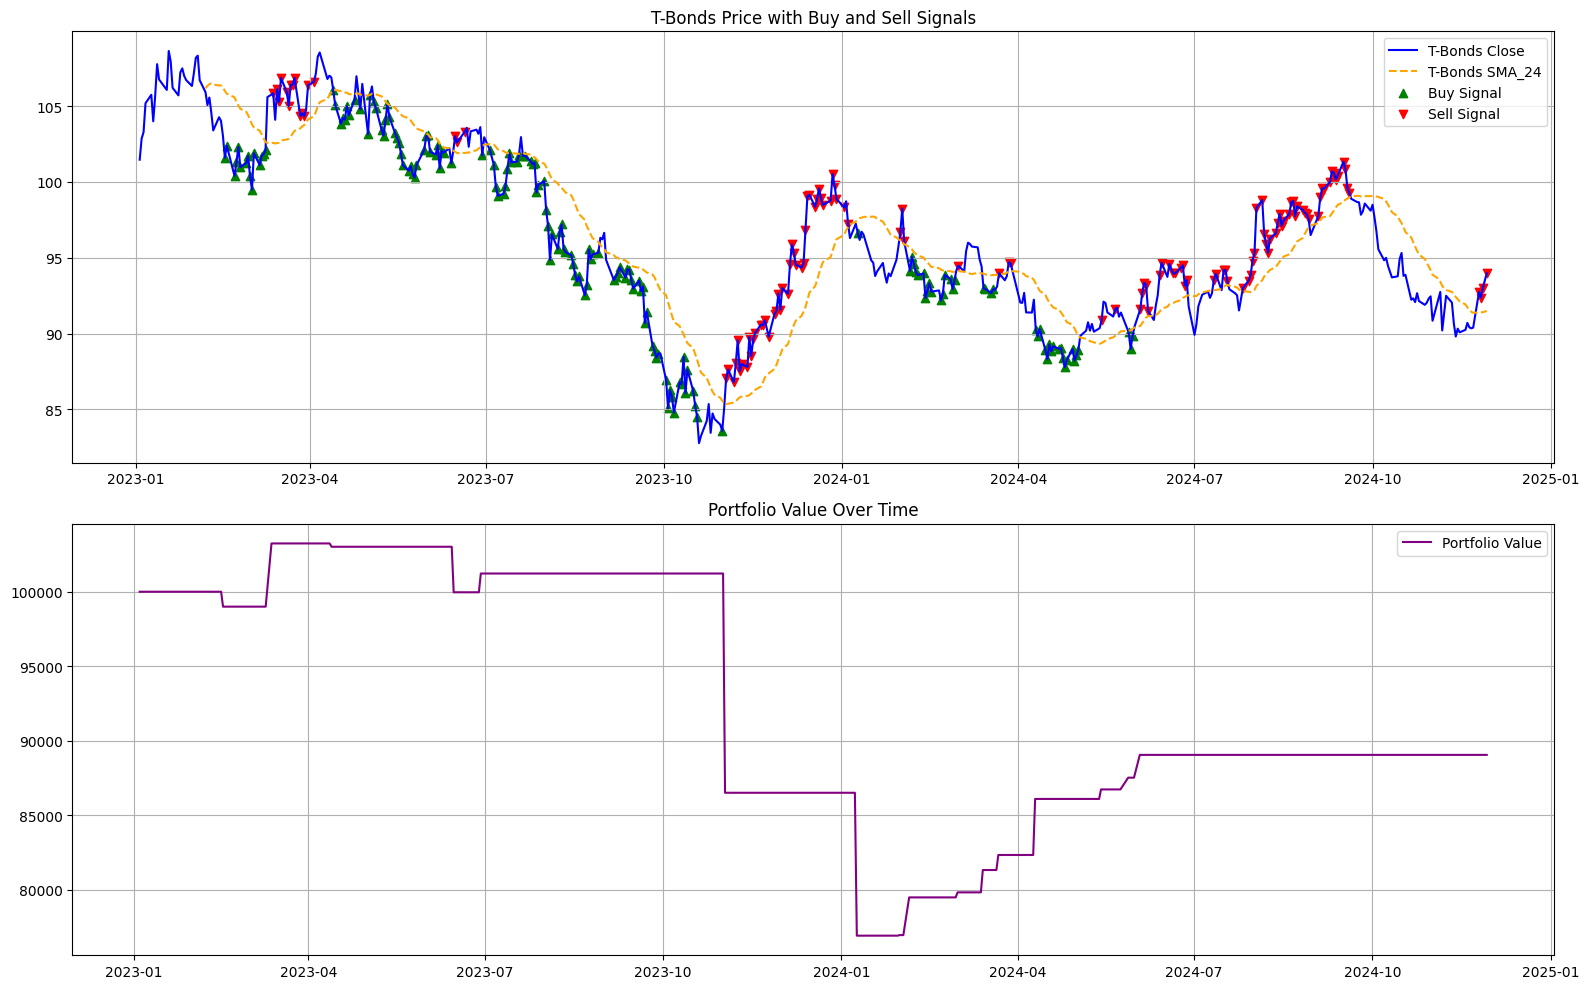

Final Capital: $87688.02
Total Profit: $-12311.98
Total Trades: 32
          Type       Price       Date        Profit
0          Buy  101.589996 2023-02-16           NaN
1    Buy_Close  105.830002 2023-03-13   4239.005493
2         Sell  105.830002 2023-03-13           NaN
3   Sell_Close  106.050003 2023-04-13   -221.001221
4          Buy  106.050003 2023-04-13           NaN
5    Buy_Close  103.000000 2023-06-15  -3051.003052
6         Sell  103.000000 2023-06-15           NaN
7   Sell_Close  101.739998 2023-06-29   1259.002136
8          Buy  101.739998 2023-06-29           NaN
9    Buy_Close   87.040001 2023-11-02 -14700.996948
10        Sell   87.040001 2023-11-02           NaN
11  Sell_Close   96.620003 2024-01-09  -9581.001831
12         Buy   96.620003 2024-01-09           NaN
13   Buy_Close   96.660004 2024-01-31     39.000916
14        Sell   96.660004 2024-01-31           NaN
15  Sell_Close   94.129997 2024-02-05   2529.006409
16         Buy   94.129997 2024-02-05           N

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_ta as ta

# Load Data
start_date = "2023-01-01"
end_date = "2024-12-01"
tbonds = yf.download("TLT", start=start_date, end=end_date)
eurodollars = yf.download("^IRX", start=start_date, end=end_date)


# Clean data by flattening MultiIndex columns
tbonds.columns = tbonds.columns.droplevel(1)  # Flatten the MultiIndex columns for T-Bonds
eurodollars.columns = eurodollars.columns.droplevel(1)  # Flatten the MultiIndex columns for Eurodollars





# clean the data
tbonds.dropna(inplace=True)
eurodollars.dropna(inplace=True)

# Align data to the same index (dates)
tbonds, eurodollars = tbonds.align(eurodollars, join='inner')



# Process Data
tbonds['SMA_24'] = tbonds['Close'].rolling(window=24).mean()
eurodollars['SMA_32'] = eurodollars['Close'].rolling(window=32).mean()

# Generate Signals
tbonds['Buy_Signal'] = (tbonds['Close'] < tbonds['SMA_24']) & (eurodollars['Close'] > eurodollars['SMA_32'])
tbonds['Sell_Signal'] = (tbonds['Close'] > tbonds['SMA_24']) & (eurodollars['Close'] < eurodollars['SMA_32'])

# Backtest Initialization
capital = 100000
position = None  # Track current position ('buy', 'sell', or None)
entry_price = 0
min_holding_days = 2  # Minimum holding period
holding_period = 0
position_size = 1000
transaction_cost = 0.001
trade_log = []

# Backtesting Logic
for i in range(1, len(tbonds)):
    holding_period += 1

    # Buy Signal Logic
    if tbonds['Buy_Signal'].iloc[i] and position != 'buy' and holding_period >= min_holding_days:
        if position == 'sell':  # Close sell position
            exit_price = tbonds['Close'].iloc[i]
            profit = (entry_price - exit_price) * position_size - (position_size * transaction_cost)
            capital += position_size + profit
            trade_log.append({'Type': 'Sell_Close', 'Price': exit_price, 'Date': tbonds.index[i], 'Profit': profit})
            position = None

        # Open buy position
        entry_price = tbonds['Close'].iloc[i]
        position = 'buy'
        capital -= position_size * (1 + transaction_cost)
        trade_log.append({'Type': 'Buy', 'Price': entry_price, 'Date': tbonds.index[i]})
        holding_period = 0

    # Sell Signal Logic
    elif tbonds['Sell_Signal'].iloc[i] and position != 'sell' and holding_period >= min_holding_days:
        if position == 'buy':  # Close buy position
            exit_price = tbonds['Close'].iloc[i]
            profit = (exit_price - entry_price) * position_size - (position_size * transaction_cost)
            capital += position_size + profit
            trade_log.append({'Type': 'Buy_Close', 'Price': exit_price, 'Date': tbonds.index[i], 'Profit': profit})
            position = None

        # Open sell position
        entry_price = tbonds['Close'].iloc[i]
        position = 'sell'
        capital -= position_size * (1 + transaction_cost)
        trade_log.append({'Type': 'Sell', 'Price': entry_price, 'Date': tbonds.index[i]})
        holding_period = 0

    # Update Portfolio Value
    tbonds.loc[tbonds.index[i], 'Portfolio_Value'] = capital

# Close Any Open Position at End of Period
if position is not None:
    exit_price = tbonds['Close'].iloc[-1]
    if position == 'buy':
        profit = (exit_price - entry_price) * position_size - (position_size * transaction_cost)
    else:
        profit = (entry_price - exit_price) * position_size - (position_size * transaction_cost)
    capital += position_size + profit
    trade_log.append({'Type': f'{position.capitalize()}_Close', 'Price': exit_price, 'Date': tbonds.index[-1], 'Profit': profit})

# Convert Trade Log to DataFrame
trade_log_df = pd.DataFrame(trade_log)

# Visualization
plt.figure(figsize=(16, 10))

# Plot T-Bonds Price and Signals
plt.subplot(2, 1, 1)
plt.plot(tbonds.index, tbonds['Close'], label="T-Bonds Close", color='blue')
plt.plot(tbonds.index, tbonds['SMA_24'], label="T-Bonds SMA_24", color='orange', linestyle='--')
plt.scatter(tbonds.loc[tbonds['Buy_Signal']].index, tbonds.loc[tbonds['Buy_Signal']]['Close'],
            label='Buy Signal', marker='^', color='green')
plt.scatter(tbonds.loc[tbonds['Sell_Signal']].index, tbonds.loc[tbonds['Sell_Signal']]['Close'],
            label='Sell Signal', marker='v', color='red')
plt.title("T-Bonds Price with Buy and Sell Signals")
plt.legend()
plt.grid()

# Plot Portfolio Value
plt.subplot(2, 1, 2)
plt.plot(tbonds.index, tbonds['Portfolio_Value'], label="Portfolio Value", color='purple')
plt.title("Portfolio Value Over Time")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Summary
total_trades = len(trade_log_df)
total_profit = capital - 100000
print(f"Final Capital: ${round(capital, 2)}")
print(f"Total Profit: ${round(total_profit, 2)}")
print(f"Total Trades: {total_trades}")
print(trade_log_df)
